## Watch Your Step: Realistic Fall Detection in Real-World Streaming Scenarios

This notebook describes the sets of experiments carried out in our paper. In all experiments, the test set is not segmented. `X_test` is the full 20-minute signal and `y_test` contains the fall points for each signal.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import joblib, json, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%load_ext autoreload
%autoreload 2
from scripts import farseeing as fs
from scripts import utils
from scripts.models import get_model_specs
from scripts.model_runner import run_models
from scripts.metric import aggregate

# Directories
RES_DIR = Path("results"); RES_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
CACHE = RES_DIR / "model_cache"; CACHE.mkdir(exist_ok=True)

2025-10-02 17:58:50.604075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-02 17:58:50.604114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-02 17:58:50.604957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Experiment Grid

In [2]:
WINDOW_SIZES = [3, 5, 7, 10, 15, 30, 60] # seconds
MODEL_SPECS = get_model_specs() # all models
# SEEDS = np.random.RandomState(14).choice(
# 	np.arange(10), size=3, replace=False).tolist()
SEEDS = [0, 1, 2] # for reproducibility
CV_FOLDS = 5
WINDOW_FREQ = 100 #Hz
print(f"Random seeds: {SEEDS}")

Random seeds: [0, 1, 2]


### Train/Test Subject Split
To avoid data leakage, we separate some subjects for final testing and use the training set only for cross-validation.

In [3]:
# Load train and test data if available, otherwise compute
try:
	subjects = json.load((open(RES_DIR/"subjects.json", "r")))
	TRAIN_SUBJ = subjects['train']
	TEST_SUBJ = subjects['test']
	print("Loaded train/test subjects from subjects.json")
except FileNotFoundError:
	print("No subjects.json found, computing train/test split...")
	TRAIN_SUBJ, TEST_SUBJ = utils.train_test_subjects_split(
		fs, test_size=0.2, random_state=42)
	json.dump({"train": TRAIN_SUBJ.tolist(), "test": TEST_SUBJ.tolist()},
			  open(RES_DIR/"subjects.json", "w"))

Loaded train/test subjects from subjects.json


### Initial Cross-validation and Window Size Selection

In [4]:
train_df = fs.load().query("SubjectID in @TRAIN_SUBJ")

In [ ]:
from scripts.cv_runner import CVRunner

kwargs = dict(
	multiphase=True,
	segment_test=False,
	thresh=1.4
)
run_kwargs = dict(
	verbose=True,
    model_specs=get_model_specs(kind="ensemble"),
    ensemble_models=True,         
    ensemble_by_kind=True                  
)

ALL_CV_ROWS = []
for win in WINDOW_SIZES:
	print(f"Running CV for window size {win} seconds")
	runner = CVRunner(
        df=train_df,
        dataset=fs,
        groups="SubjectID",
        split_df_fn=utils.split_df,
        run_models_fn=run_models,
        window_size=win,
        cv=CV_FOLDS,
        kwargs=kwargs
    )
	fold_df = runner.run(**run_kwargs)
	fold_df["window_size"] = win
	ALL_CV_ROWS.append(fold_df)
cv_metrics = pd.concat(ALL_CV_ROWS, ignore_index=True)
cv_metrics.to_csv(RES_DIR / "costcv_all_windows.csv", index=False)

2025-09-29 14:43:31,024 [INFO] Training models (seed=0)


Running CV for window size 3 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1080, 300), y: (1080,)    ([ADLs, Falls]) [978 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]
2025-09-29 14:45:19,817 [INFO] ✅ Evaluation complete
2025-09-29 14:45:19,864 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1140, 300), y: (1140,)    ([ADLs, Falls]) [1053   87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]
2025-09-29 14:47:09,892 [INFO] ✅ Evaluation complete
2025-09-29 14:47:09,916 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (969, 300), y: (969,)    ([ADLs, Falls]) [856 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]
2025-09-29 14:48:42,870 [INFO] ✅ Evaluation complete
2025-09-29 14:48:42,891 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1182, 300), y: (1182,)    ([ADLs, Falls]) [1074  108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]
2025-09-29 14:50:24,896 [INFO] ✅ Evaluation complete
2025-09-29 14:50:24,916 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (713, 300), y: (713,)    ([ADLs, Falls]) [627  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:14<00:00, 14.36s/it]
2025-09-29 14:52:01,126 [INFO] ✅ Evaluation complete
2025-09-29 14:52:01,214 [INFO] Training models (seed=0)


Running CV for window size 5 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1063, 500), y: (1063,)    ([ADLs, Falls]) [961 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:11<00:00, 11.67s/it]
2025-09-29 14:53:50,606 [INFO] ✅ Evaluation complete
2025-09-29 14:53:50,648 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1124, 500), y: (1124,)    ([ADLs, Falls]) [1037   87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:16<00:00, 16.02s/it]
2025-09-29 14:55:46,794 [INFO] ✅ Evaluation complete
2025-09-29 14:55:46,817 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (949, 500), y: (949,)    ([ADLs, Falls]) [836 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]
2025-09-29 14:57:24,490 [INFO] ✅ Evaluation complete
2025-09-29 14:57:24,511 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1165, 500), y: (1165,)    ([ADLs, Falls]) [1057  108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:07<00:00,  7.10s/it]
2025-09-29 14:59:12,606 [INFO] ✅ Evaluation complete
2025-09-29 14:59:12,626 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (703, 500), y: (703,)    ([ADLs, Falls]) [617  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:17<00:00, 17.43s/it]
2025-09-29 15:00:54,542 [INFO] ✅ Evaluation complete
2025-09-29 15:00:54,619 [INFO] Training models (seed=0)


Running CV for window size 7 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1052, 700), y: (1052,)    ([ADLs, Falls]) [950 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:13<00:00, 13.82s/it]
2025-09-29 15:02:52,377 [INFO] ✅ Evaluation complete
2025-09-29 15:02:52,424 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1114, 700), y: (1114,)    ([ADLs, Falls]) [1027   87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:22<00:00, 22.34s/it]
2025-09-29 15:05:01,040 [INFO] ✅ Evaluation complete
2025-09-29 15:05:01,061 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (940, 700), y: (940,)    ([ADLs, Falls]) [827 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]
2025-09-29 15:06:45,284 [INFO] ✅ Evaluation complete
2025-09-29 15:06:45,306 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1154, 700), y: (1154,)    ([ADLs, Falls]) [1046  108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:10<00:00, 10.14s/it]
2025-09-29 15:08:45,038 [INFO] ✅ Evaluation complete
2025-09-29 15:08:45,058 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (700, 700), y: (700,)    ([ADLs, Falls]) [614  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:24<00:00, 24.11s/it]
2025-09-29 15:10:37,295 [INFO] ✅ Evaluation complete
2025-09-29 15:10:37,373 [INFO] Training models (seed=0)


Running CV for window size 10 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (1027, 1000), y: (1027,)    ([ADLs, Falls]) [925 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:17<00:00, 17.02s/it]
2025-09-29 15:12:49,910 [INFO] ✅ Evaluation complete
2025-09-29 15:12:49,954 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1090, 1000), y: (1090,)    ([ADLs, Falls]) [1003   87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:24<00:00, 24.03s/it]
2025-09-29 15:15:15,237 [INFO] ✅ Evaluation complete
2025-09-29 15:15:15,264 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (918, 1000), y: (918,)    ([ADLs, Falls]) [805 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]
2025-09-29 15:17:07,462 [INFO] ✅ Evaluation complete
2025-09-29 15:17:07,485 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1129, 1000), y: (1129,)    ([ADLs, Falls]) [1021  108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:10<00:00, 10.15s/it]
2025-09-29 15:19:19,790 [INFO] ✅ Evaluation complete
2025-09-29 15:19:19,811 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (688, 1000), y: (688,)    ([ADLs, Falls]) [602  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:25<00:00, 25.85s/it]
2025-09-29 15:21:19,122 [INFO] ✅ Evaluation complete
2025-09-29 15:21:19,200 [INFO] Training models (seed=0)


Running CV for window size 15 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (998, 1500), y: (998,)    ([ADLs, Falls]) [896 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:21<00:00, 21.97s/it]
2025-09-29 15:23:55,067 [INFO] ✅ Evaluation complete
2025-09-29 15:23:55,114 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1057, 1500), y: (1057,)    ([ADLs, Falls]) [970  87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:30<00:00, 30.66s/it]
2025-09-29 15:26:46,805 [INFO] ✅ Evaluation complete
2025-09-29 15:26:46,834 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (889, 1500), y: (889,)    ([ADLs, Falls]) [776 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:08<00:00,  8.02s/it]
2025-09-29 15:29:00,659 [INFO] ✅ Evaluation complete
2025-09-29 15:29:00,684 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1096, 1500), y: (1096,)    ([ADLs, Falls]) [988 108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:13<00:00, 13.72s/it]
2025-09-29 15:31:37,580 [INFO] ✅ Evaluation complete
2025-09-29 15:31:37,611 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (676, 1500), y: (676,)    ([ADLs, Falls]) [590  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:33<00:00, 33.80s/it]
2025-09-29 15:33:57,998 [INFO] ✅ Evaluation complete
2025-09-29 15:33:58,079 [INFO] Training models (seed=0)


Running CV for window size 30 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (957, 3000), y: (957,)    ([ADLs, Falls]) [855 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:28<00:00, 28.00s/it]
2025-09-29 15:37:39,445 [INFO] ✅ Evaluation complete
2025-09-29 15:37:39,501 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (1018, 3000), y: (1018,)    ([ADLs, Falls]) [931  87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:38<00:00, 38.83s/it]
2025-09-29 15:41:33,381 [INFO] ✅ Evaluation complete
2025-09-29 15:41:33,402 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (847, 3000), y: (847,)    ([ADLs, Falls]) [734 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:10<00:00, 10.49s/it]
2025-09-29 15:44:45,499 [INFO] ✅ Evaluation complete
2025-09-29 15:44:45,536 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (1057, 3000), y: (1057,)    ([ADLs, Falls]) [949 108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:17<00:00, 17.82s/it]
2025-09-29 15:48:37,798 [INFO] ✅ Evaluation complete
2025-09-29 15:48:37,828 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (657, 3000), y: (657,)    ([ADLs, Falls]) [571  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:43<00:00, 43.59s/it]
2025-09-29 15:51:48,932 [INFO] ✅ Evaluation complete
2025-09-29 15:51:49,036 [INFO] Training models (seed=0)


Running CV for window size 60 seconds

– Fold 1/5: testing on 7 subjects –
Train set: 102 samples, Test set: 22 samples
Train set: X: (864, 6000), y: (864,)    ([ADLs, Falls]) [762 102]
Test set: X: 22, y: 22


Evaluating models: 100%|██████████| 1/1 [00:39<00:00, 39.18s/it]
2025-09-29 15:57:41,756 [INFO] ✅ Evaluation complete
2025-09-29 15:57:41,816 [INFO] Training models (seed=0)



– Fold 2/5: testing on 7 subjects –
Train set: 87 samples, Test set: 37 samples
Train set: X: (927, 6000), y: (927,)    ([ADLs, Falls]) [840  87]
Test set: X: 37, y: 37


Evaluating models: 100%|██████████| 1/1 [00:52<00:00, 52.35s/it]
2025-09-29 16:04:03,506 [INFO] ✅ Evaluation complete
2025-09-29 16:04:03,532 [INFO] Training models (seed=0)



– Fold 3/5: testing on 6 subjects –
Train set: 113 samples, Test set: 11 samples
Train set: X: (771, 6000), y: (771,)    ([ADLs, Falls]) [658 113]
Test set: X: 11, y: 11


Evaluating models: 100%|██████████| 1/1 [00:13<00:00, 13.70s/it]
2025-09-29 16:09:04,116 [INFO] ✅ Evaluation complete
2025-09-29 16:09:04,154 [INFO] Training models (seed=0)



– Fold 4/5: testing on 6 subjects –
Train set: 108 samples, Test set: 16 samples
Train set: X: (973, 6000), y: (973,)    ([ADLs, Falls]) [865 108]
Test set: X: 16, y: 16


Evaluating models: 100%|██████████| 1/1 [00:22<00:00, 22.92s/it]
2025-09-29 16:15:13,608 [INFO] ✅ Evaluation complete
2025-09-29 16:15:13,643 [INFO] Training models (seed=0)



– Fold 5/5: testing on 6 subjects –
Train set: 86 samples, Test set: 38 samples
Train set: X: (621, 6000), y: (621,)    ([ADLs, Falls]) [535  86]
Test set: X: 38, y: 38


Evaluating models: 100%|██████████| 1/1 [00:56<00:00, 56.48s/it]
2025-09-29 16:19:53,005 [INFO] ✅ Evaluation complete


### CV Results

In [4]:
cv_metrics_old = pd.read_csv(RES_DIR / "cv_all_windows.csv")
# Select only with QUANT and ExtraTrees
cv_metrics_old = cv_metrics_old[
	cv_metrics_old["model"].isin(["QUANT", "ExtraTrees"])]
cv_metrics_no_std = pd.read_csv(RES_DIR / "cv_all_windows_new (no std).csv")
# select only with ResNet and MiniRocket
cv_metrics_no_std = cv_metrics_no_std[
    cv_metrics_no_std["model"].isin(["MiniRocket"])]
cost_cv_metrics = pd.read_csv(RES_DIR / "costcv_all_windows.csv")
cv_metrics = pd.concat([cv_metrics_old, cv_metrics_no_std, cost_cv_metrics], ignore_index=True)
cv_metrics.to_csv(RES_DIR / "cv_metrics_2Oct2025.csv", index=False)
cv_metrics

model  seed  window_size    runtime     delay  precision    recall  \
0    ExtraTrees   0.0            3   0.200628  0.909091   0.909091  0.909091   
1         QUANT   0.0            3   2.357866  0.772727   0.833333  0.909091   
2    ExtraTrees   0.0            3   0.168541  4.559118   0.892857  0.735294   
3         QUANT   0.0            3   2.319509 -0.349118   0.846154  0.970588   
4    ExtraTrees   0.0            3   0.124129  1.333333   0.666667  0.888889   
..          ...   ...          ...        ...       ...        ...       ...   
135      CostCV   0.0           60  14.747112 -0.227273   0.777778  0.954545   
136      CostCV   0.0           60  12.797236 -0.064706   0.931034  0.794118   
137      CostCV   0.0           60  12.656064  1.333333   0.727273  0.888889   
138      CostCV   0.0           60  12.697310  0.138000   0.800000  0.800000   
139      CostCV   0.0           60  12.762466  4.895405   0.771429  0.729730   

     specificity  f1-score       auc  false alarm rate  miss rate      gain  \
0       0.999999  0.909091  0.954545          0.272725   0.272725  0.001000   
1       0.999998  0.869565  0.954545          0.545450   0.272725  0.001000   
2       0.999999  0.806452  0.867647          0.264704   0.794111  0.001000   
3       0.999999  0.904110  0.985293          0.529407   0.088235  0.001000   
4       0.999996  0.761905  0.944443          1.333322   0.333331  0.001000   
..           ...       ...       ...               ...        ...       ...   
135     0.999761  0.857143  0.977153          0.818175   0.136363 -0.000022   
136     0.999948  0.857143  0.897033          0.176469   0.617642 -0.000044   
137     0.999708  0.800000  0.944298          0.999992   0.333331 -0.000014   
138     0.999825  0.800000  0.899912          0.599995   0.599995 -0.000025   
139     0.999809  0.750000  0.864769          0.652138   0.815173 -0.000078   

     fold  thresh  
0       1     NaN  
1       1     NaN  
2       2     NaN  
3       2     NaN  
4       3     NaN  
..    ...     ...  
135     1     0.5  
136     2     0.5  
137     3     0.5  
138     4     0.5  
139     5     0.5  

[140 rows x 15 columns]

In [5]:
best_rows = (
    cv_metrics
    .groupby(["model", "window_size"])
    ["f1-score"].mean()
    .unstack("window_size")
    .idxmax(axis=1) # window with highest mean F1
)
BEST_WINDOW = best_rows.to_dict()
json.dump(BEST_WINDOW, open(RES_DIR/"best_window_size_costcv.json","w"))

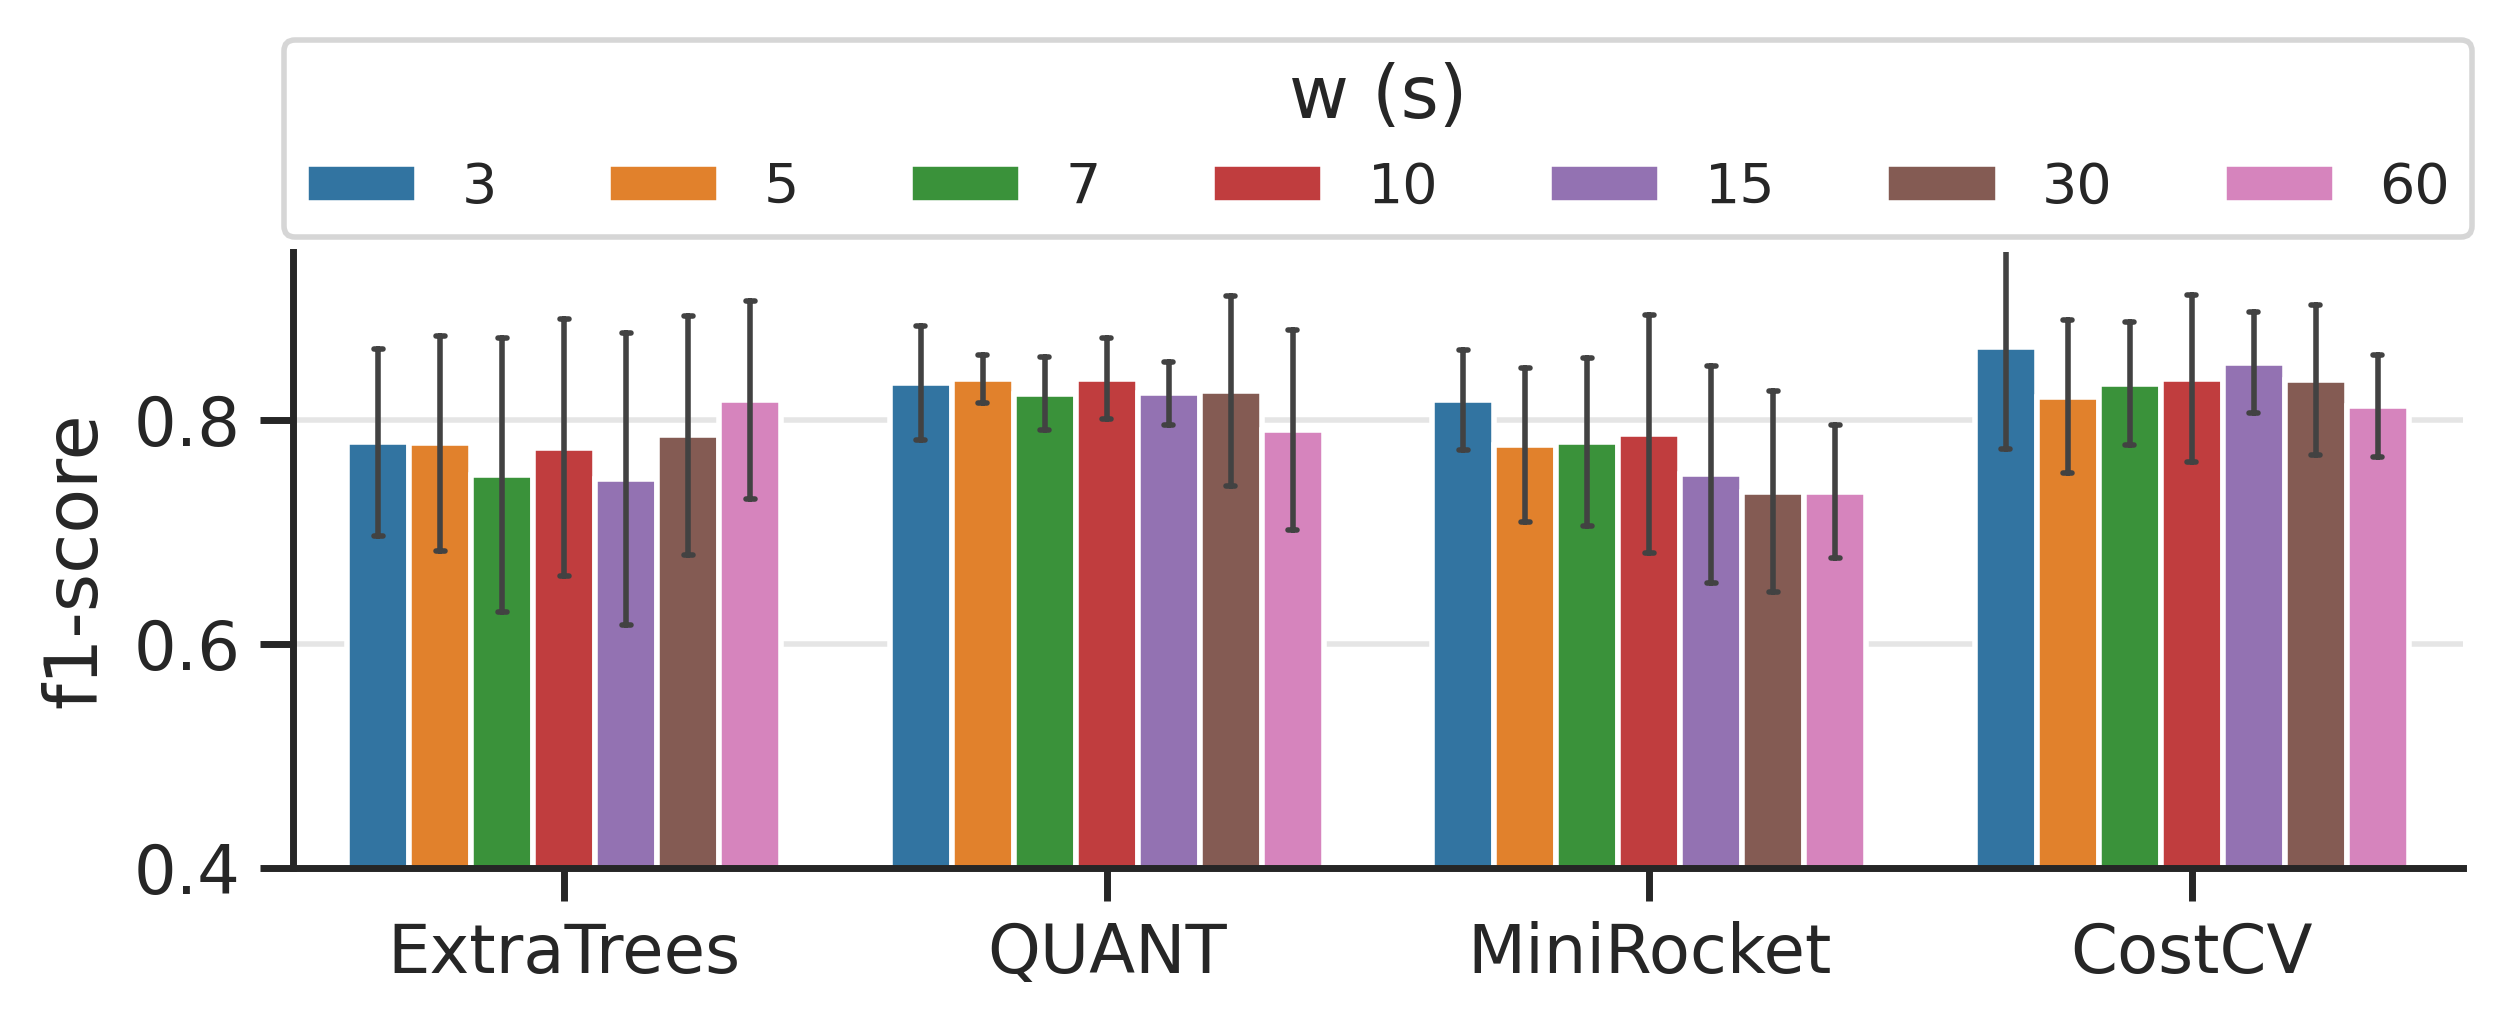

In [6]:
from scripts.plotting import window_bar

plt.figure(figsize=(7, 2), dpi=400)
ax = window_bar(cv_metrics.query("seed==0.0"),
                metric="f1-score", ci="sd",
                x="model", hue="window_size")
ax.set_xlabel("")
ax.set_title("")
ax.set_ylim(0.4, 0.95)
ax.grid(axis='y', alpha=0.5, which='both')
ax.legend(loc=9, ncol=7, 
          title="w (s)",
          bbox_to_anchor=(0.5, 1.39),
          fontsize=10)
ax.set_title("")
plt.savefig(FIG_DIR / "bar_plot_by_w_cost.pdf", bbox_inches='tight')
plt.show()

In [7]:
# aggregate metrics
agg_metrics = aggregate(cv_metrics)
agg_metrics.to_csv(RES_DIR / "agg_metrics.csv", index=False)

In [8]:
grps = cv_metrics.groupby(['model', 'window_size']).mean(numeric_only=True)
# pick best model and window size
best_model = grps['f1-score'].idxmax()[0]
best_window = grps['f1-score'].idxmax()[1]
print(f"Best model: {best_model} with window size of {best_window} seconds")

Best model: CostCV with window size of 3 seconds


### Final Testing

In [5]:
best_windows = json.load(open(RES_DIR/"best_window_size_costcv.json", "r"))
# win_sizes = set([best_windows[m.name] for m in MODEL_SPECS\
#                   if m.kind != "baseline"\
#                         and not m.name in ["ResNet", "Catch22"]])
# create datasets for each window size
win_sizes = [10]
whole_df = fs.load()
datasets = {}
for win in win_sizes:
    datasets[win] = utils.split_df(
		whole_df, fs, test_set=TEST_SUBJ,
        window_size=win, segment_test=False,
        thresh=1.4, multiphase=True
	)

Train set: 124 samples, Test set: 21 samples
Train set: X: (1213, 1000), y: (1213,)    ([ADLs, Falls]) [1089  124]
Test set: X: 21, y: 21


In [9]:
# how many subjects in train and test sets
print(f"Train subjects: {len(TRAIN_SUBJ)}, "
	  f"Test subjects: {len(TEST_SUBJ)}")

Train subjects: 32, Test subjects: 9


In [6]:
from scripts.model_runner import run_models

costcv_metrics = []
costcv = get_model_specs(kind="ensemble")
w = 10 # seconds
print(f"Running CostCV window size {w} seconds")
X_tr, X_te, y_tr, y_te = datasets[w]
res = run_models(
	X_tr, X_te, y_tr, y_te,
	model_specs=costcv,
	verbose=True,
	ensemble_models=False,
	ensemble_by_kind=False,
	window_size=w,
    saved_tuned_dir=CACHE
)
res["window_size"] = w
res["fn_factor"] = 2
costcv_metrics.append(res)
print("")
costcv_df = pd.concat(costcv_metrics, ignore_index=True)
costcv_df.to_csv(RES_DIR / "costcv_metrics.csv", index=False)

2025-10-02 17:59:14,804 [INFO] Training models (seed=0)


Running CostCV window size 10 seconds


Evaluating models: 100%|██████████| 2/2 [01:24<00:00, 42.48s/it]
2025-10-02 18:05:00,086 [INFO] ✅ Evaluation complete


In [7]:
costcv_df = pd.read_csv(RES_DIR / "costcv_metrics.csv")
quant_df = pd.read_csv(RES_DIR / "quant_thresh_metrics_26August.csv")
compare_df = pd.concat([costcv_df, quant_df], ignore_index=True)
compare_df

model  seed  window_size    runtime     delay  precision  \
0   CostCVStacking     0           10  16.946190  0.512381   0.944444   
1  CostCVDirichlet     0           10  16.923698 -0.297143   0.947368   
2            QUANT     0           10   4.566170 -3.630476   0.840000   

     recall  specificity  f1-score       auc  false alarm rate  miss rate  \
0  0.809524     0.999960  0.871795  0.904742          0.143592   0.574367   
1  0.857143     0.999960  0.900000  0.928551          0.143592   0.430776   
2  1.000000     0.999839  0.913043  0.999920          0.574367   0.000000   

       gain   thresh  fn_factor  
0 -0.000025  0.50000          2  
1 -0.000019  0.50000          2  
2 -0.000011  0.40404          2

In [12]:
costcv[0].estimator.named_steps['costclassifiercv']

CostClassifierCV(base_estimators=[ExtraTreesClassifier(criterion='entropy',
                                                       max_features=0.1,
                                                       n_estimators=150),
                                  MiniRocketClassifier(n_jobs=-1),
                                  QUANTClassifier()],
                 random_state=0)

2025-08-19 16:03:17,960 [INFO] Training models (seed=0)


Running models for window size 10 seconds, no tuning


Evaluating models:   0%|          | 0/1 [00:00<?, ?it/s]

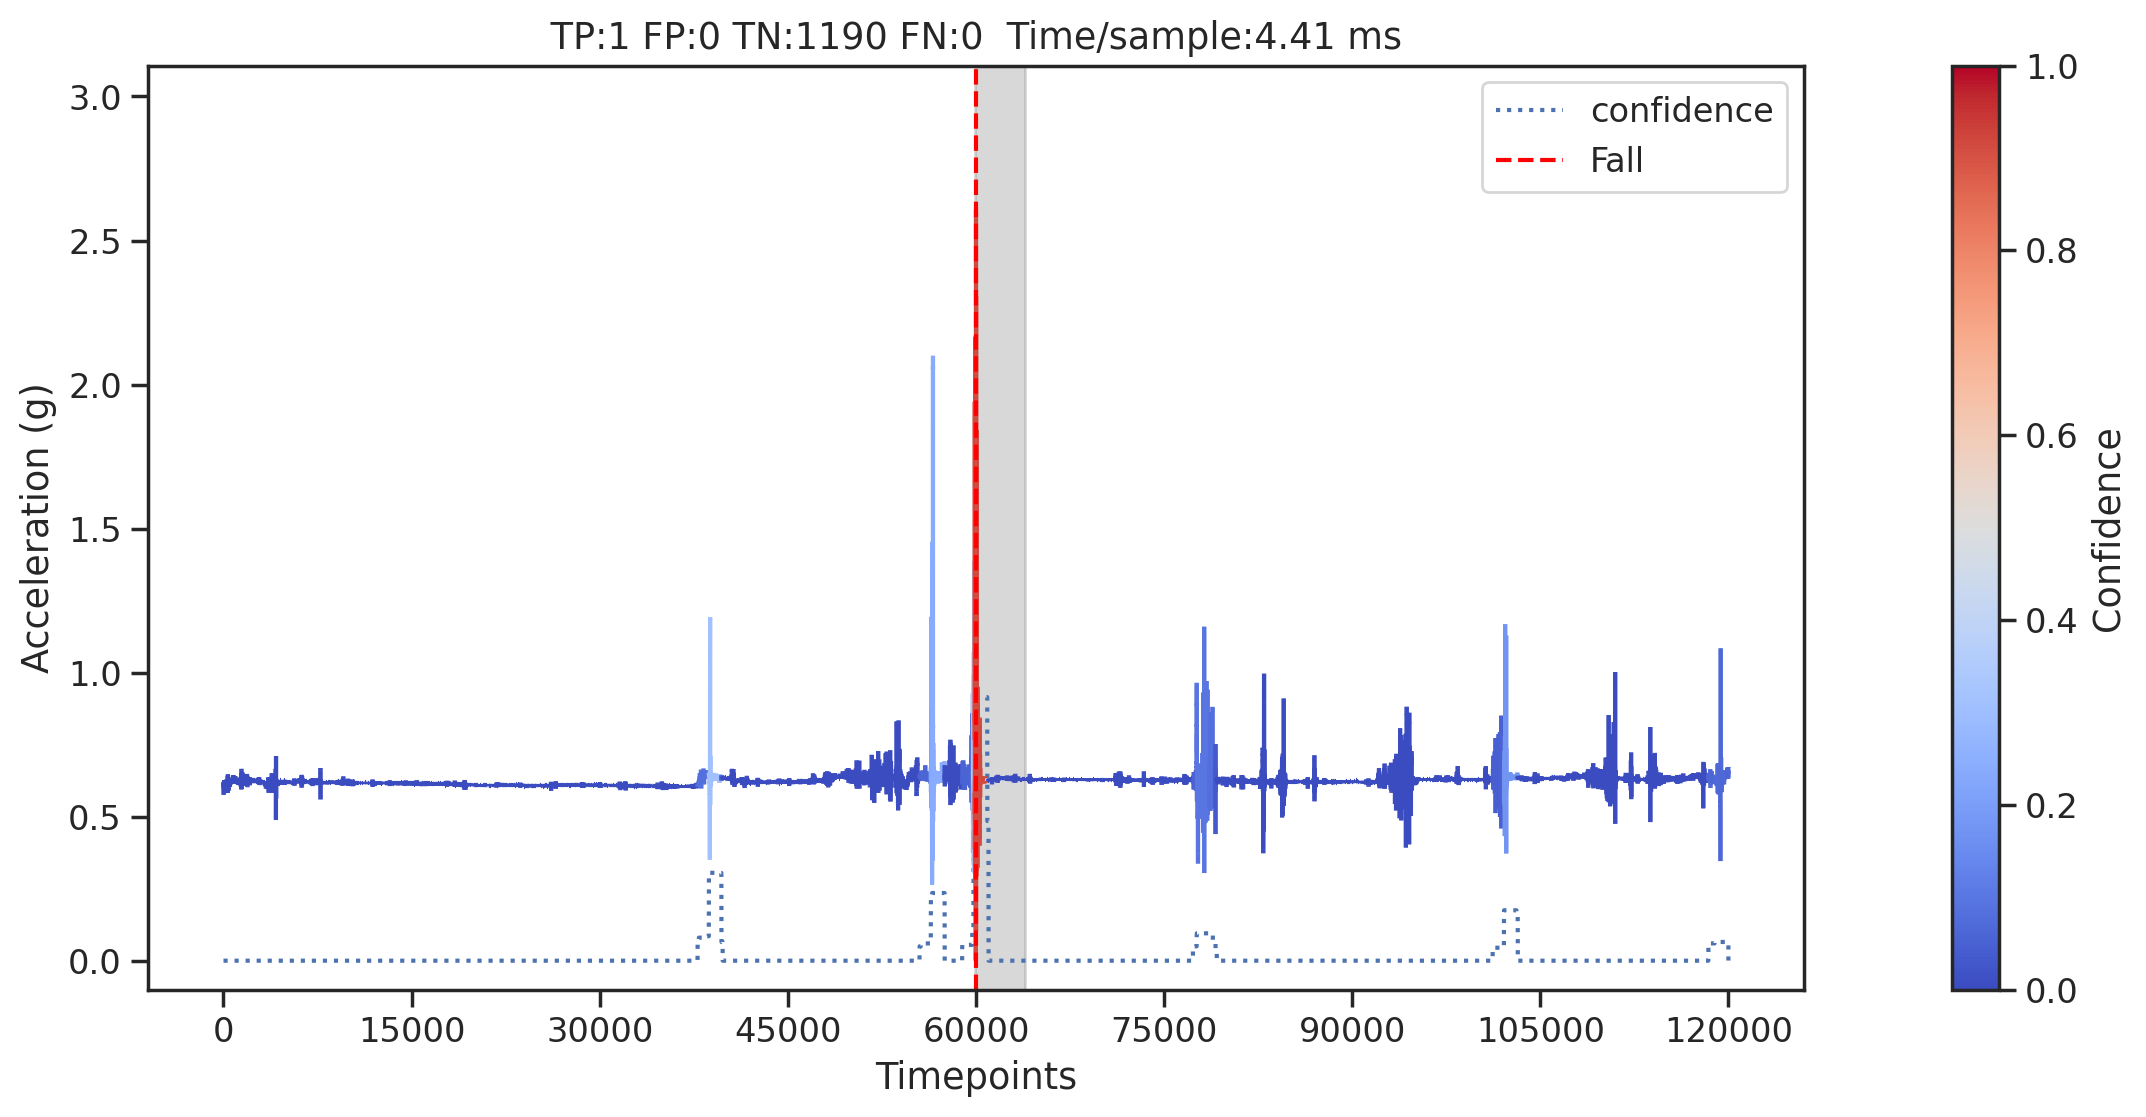

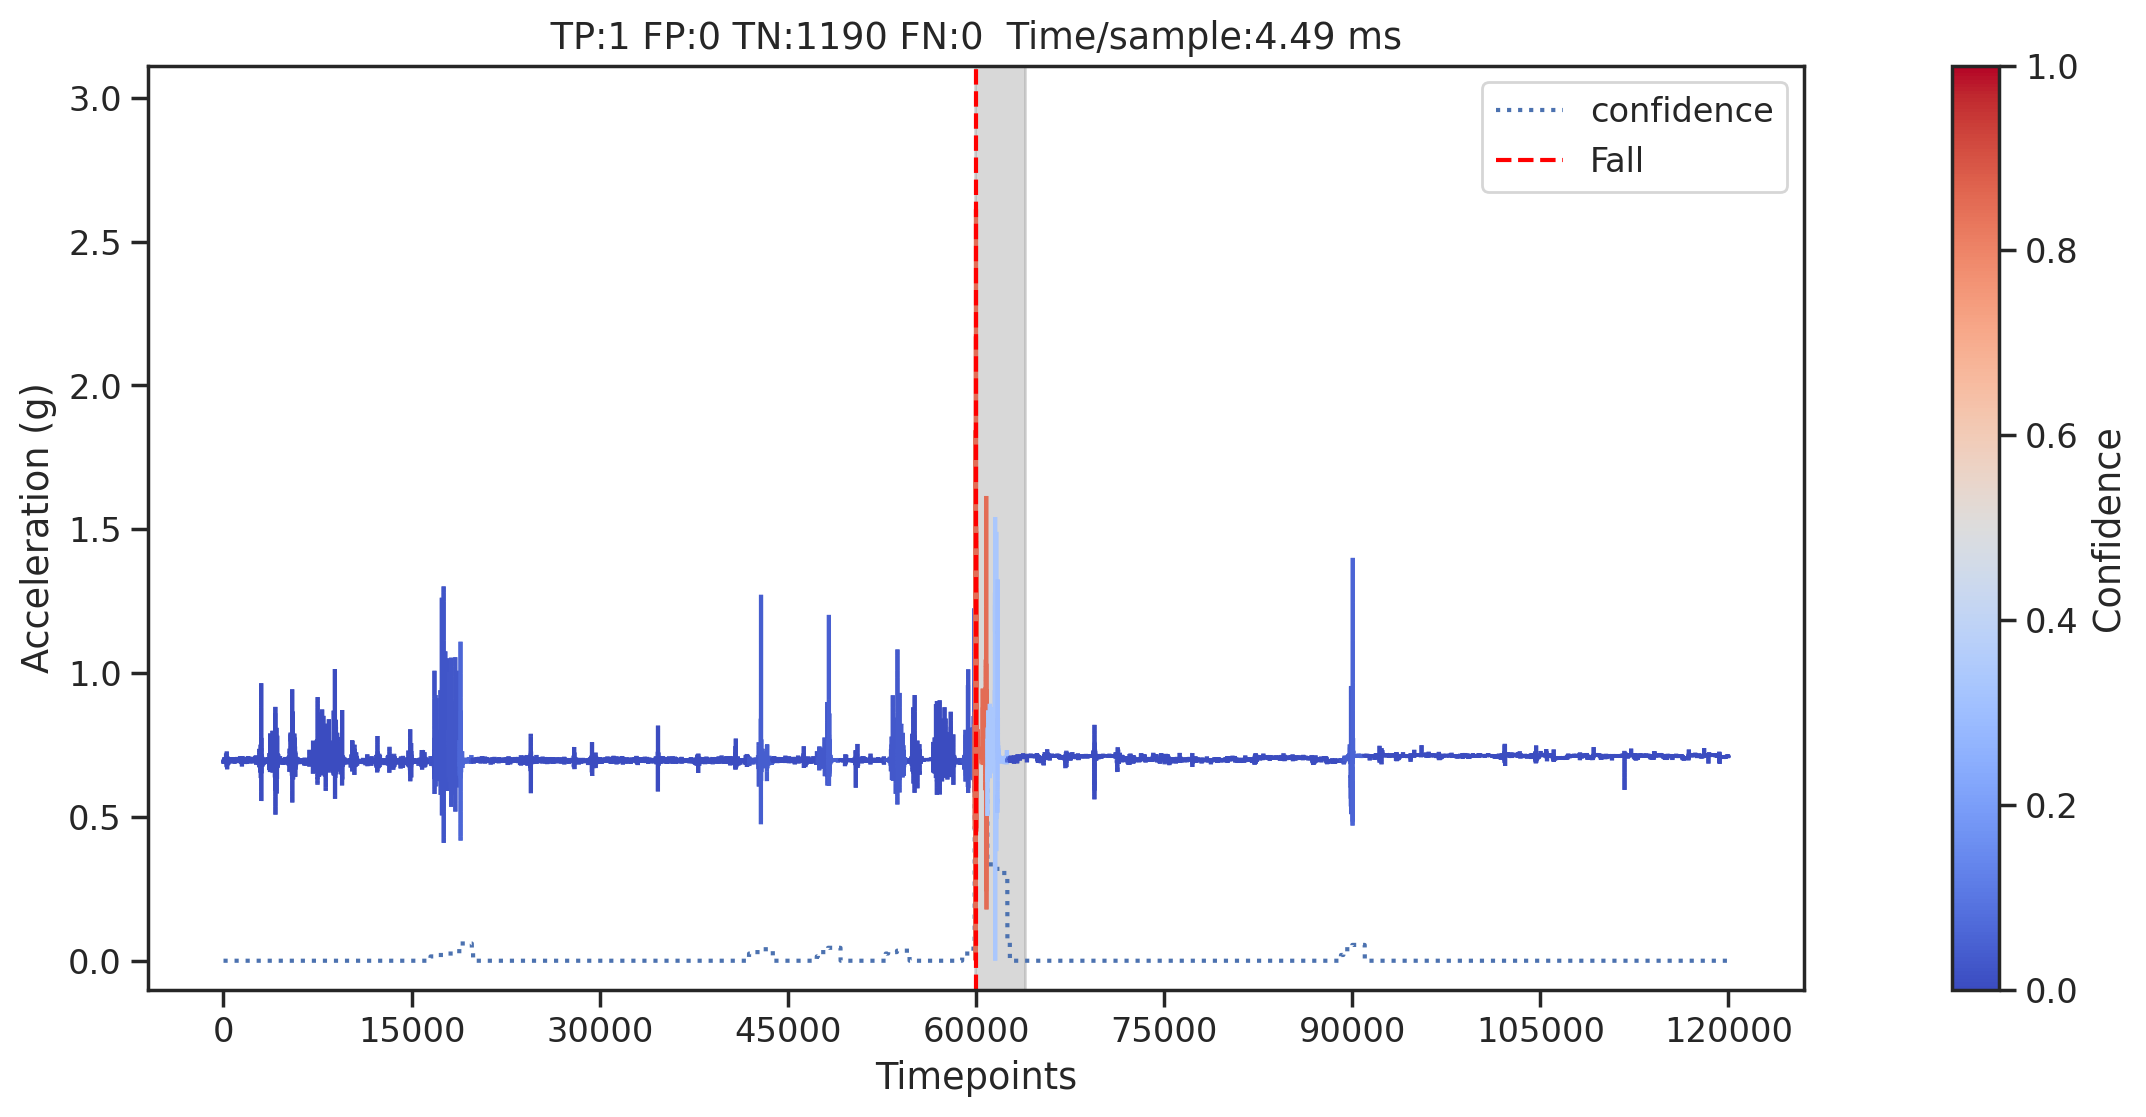

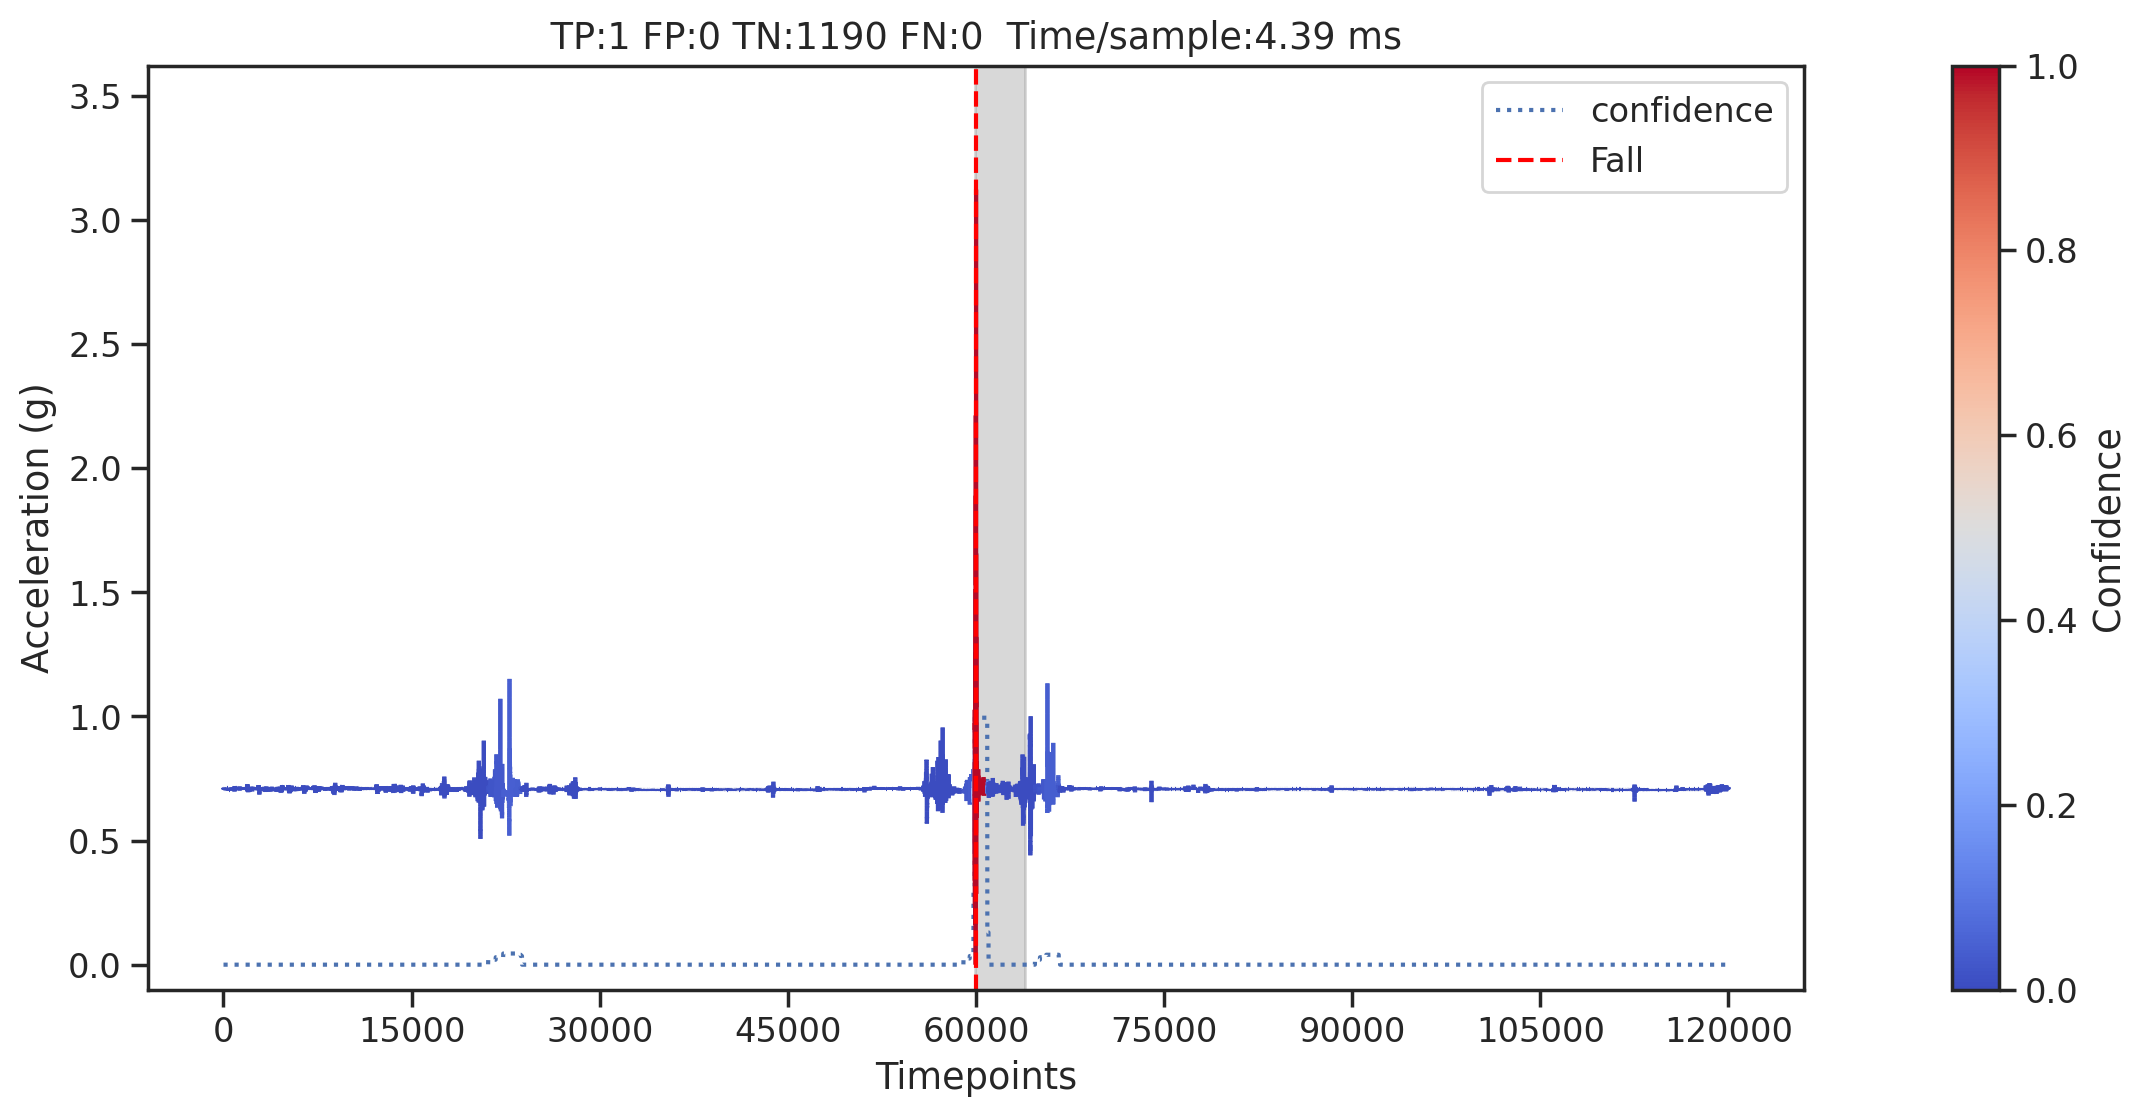

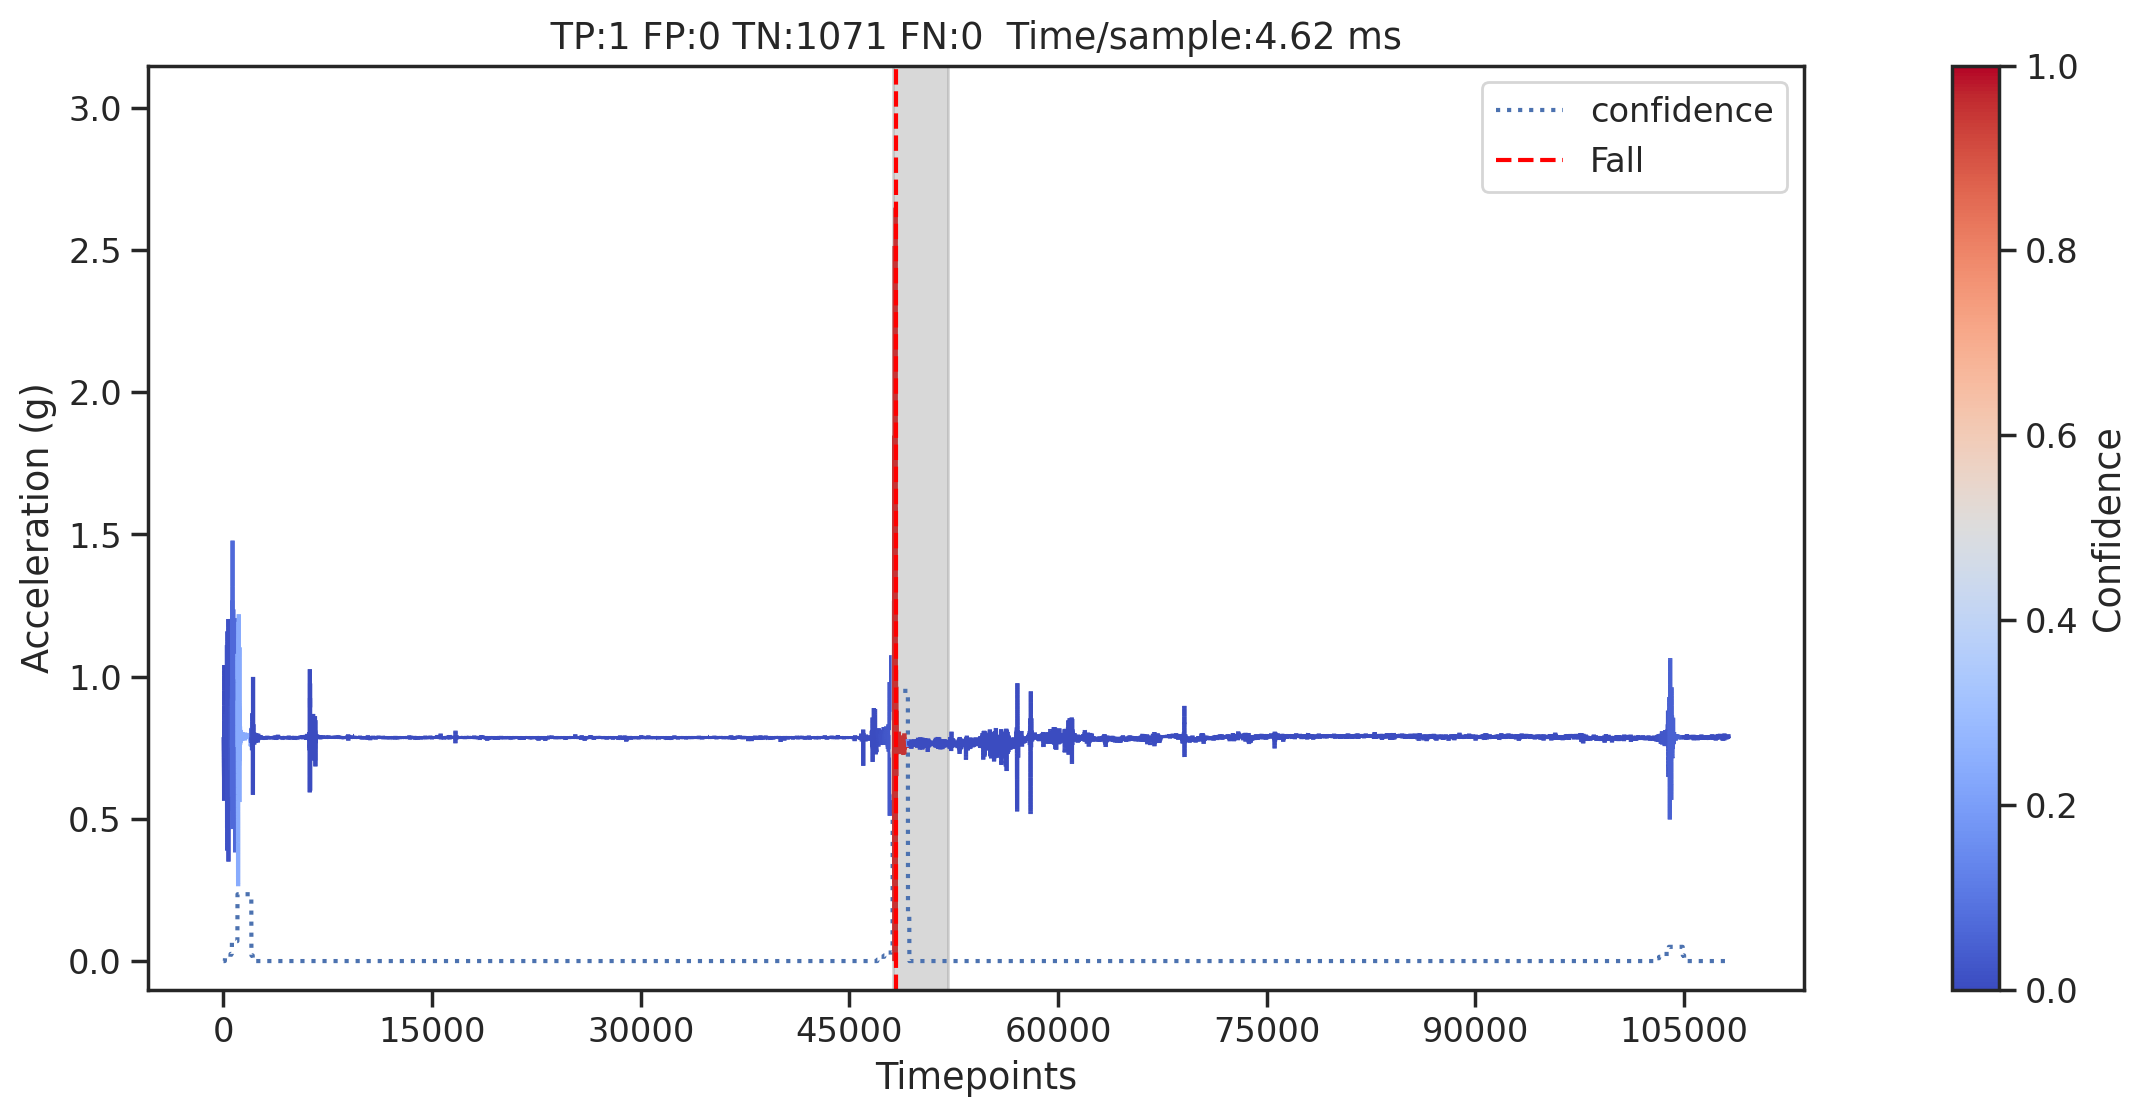

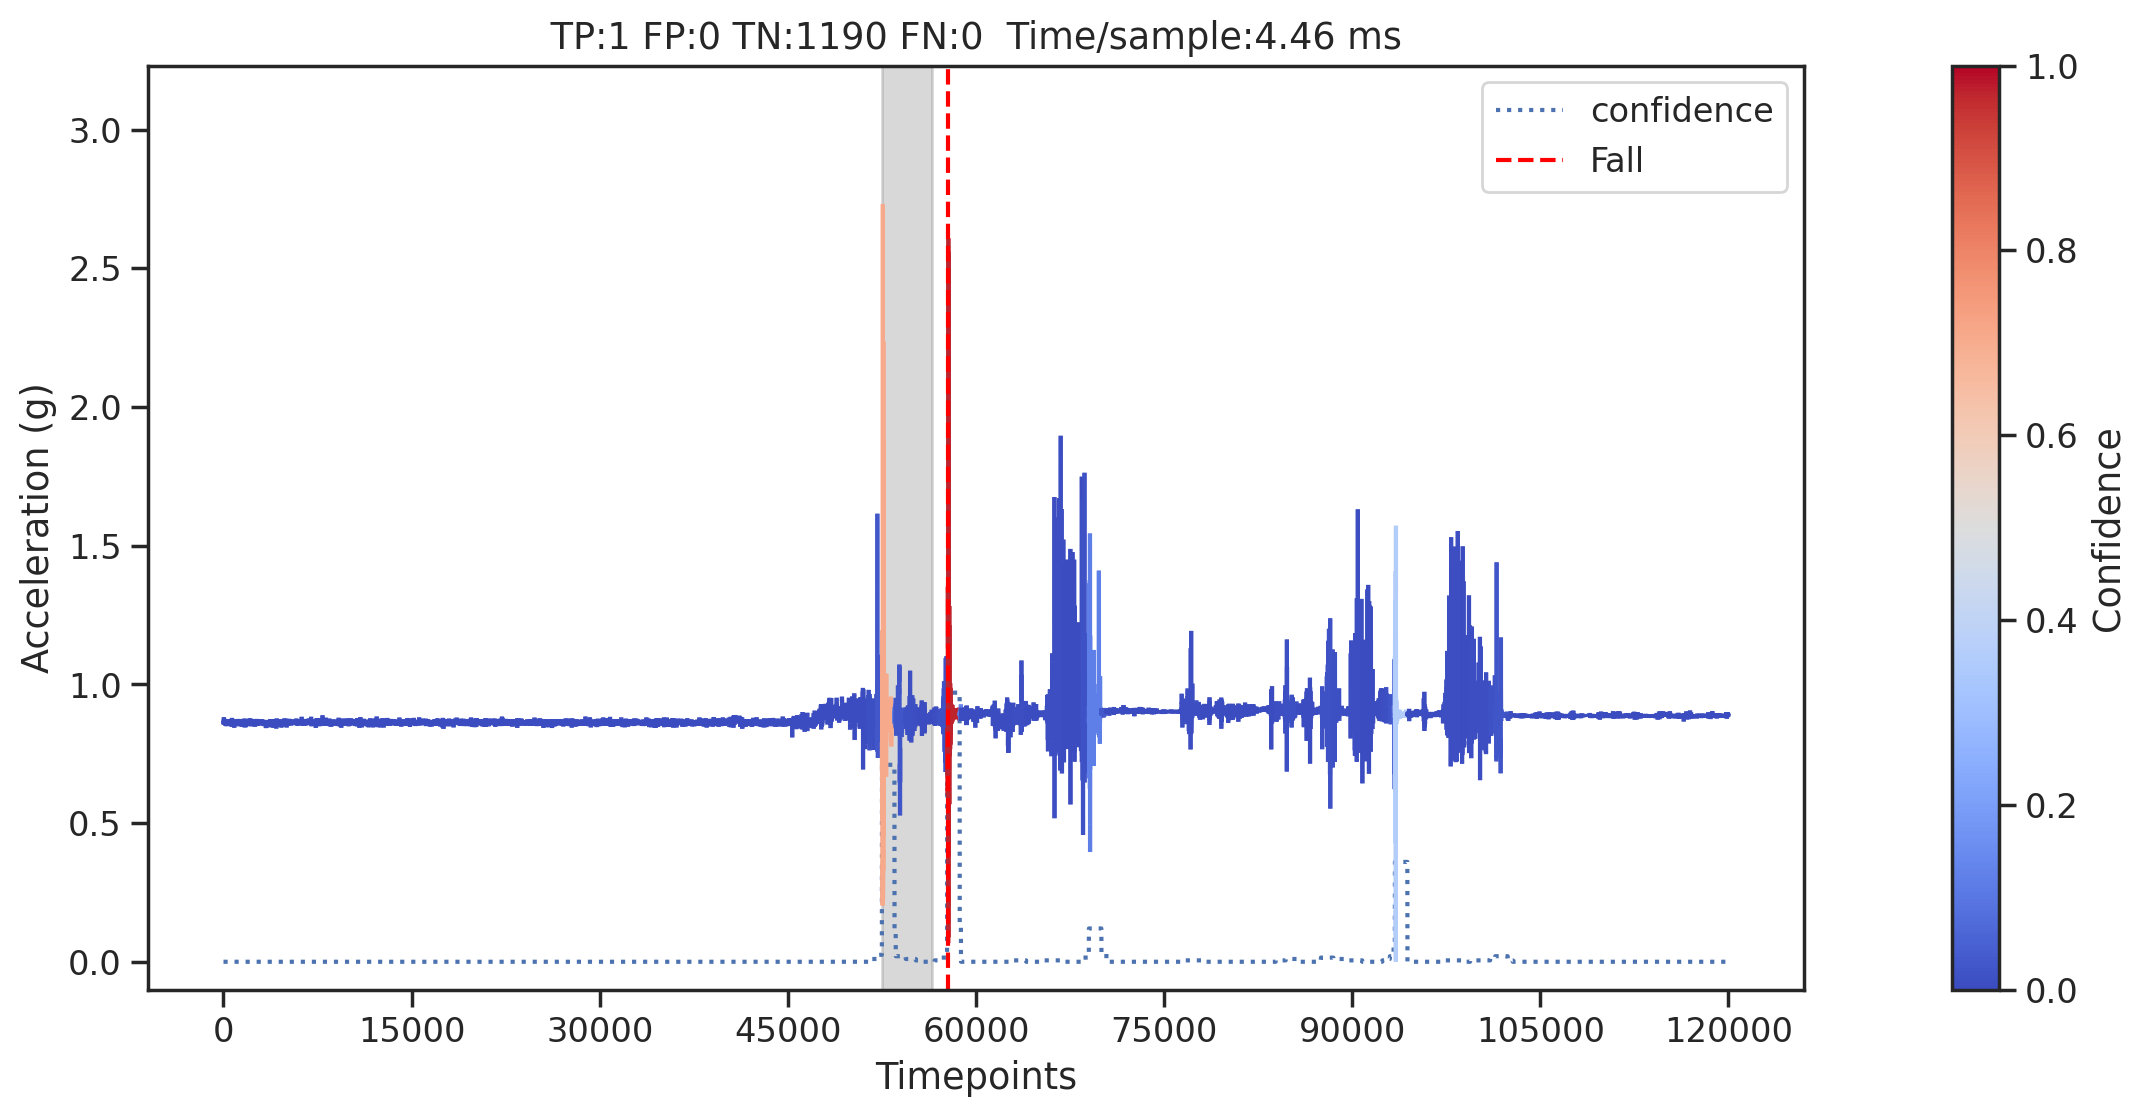

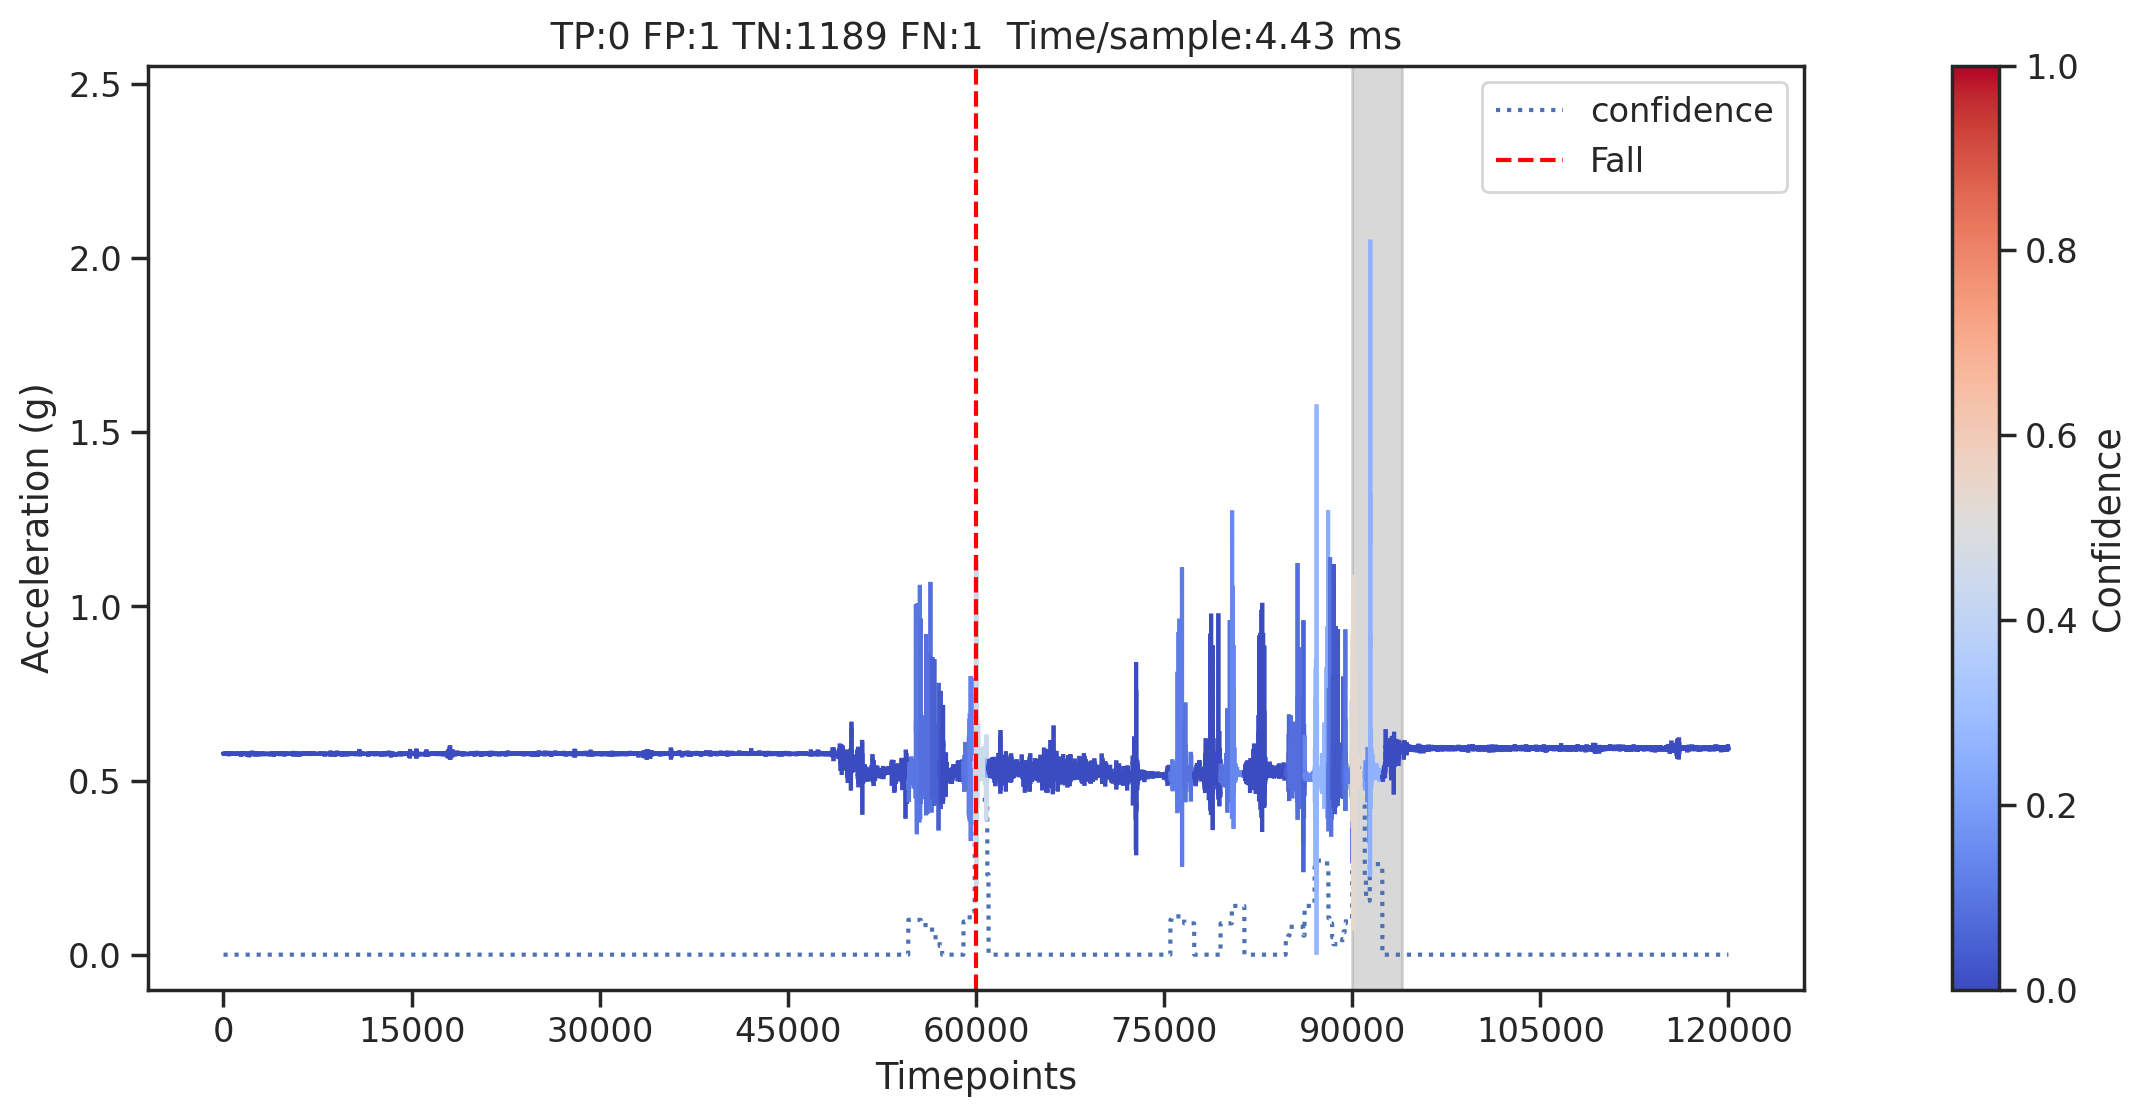

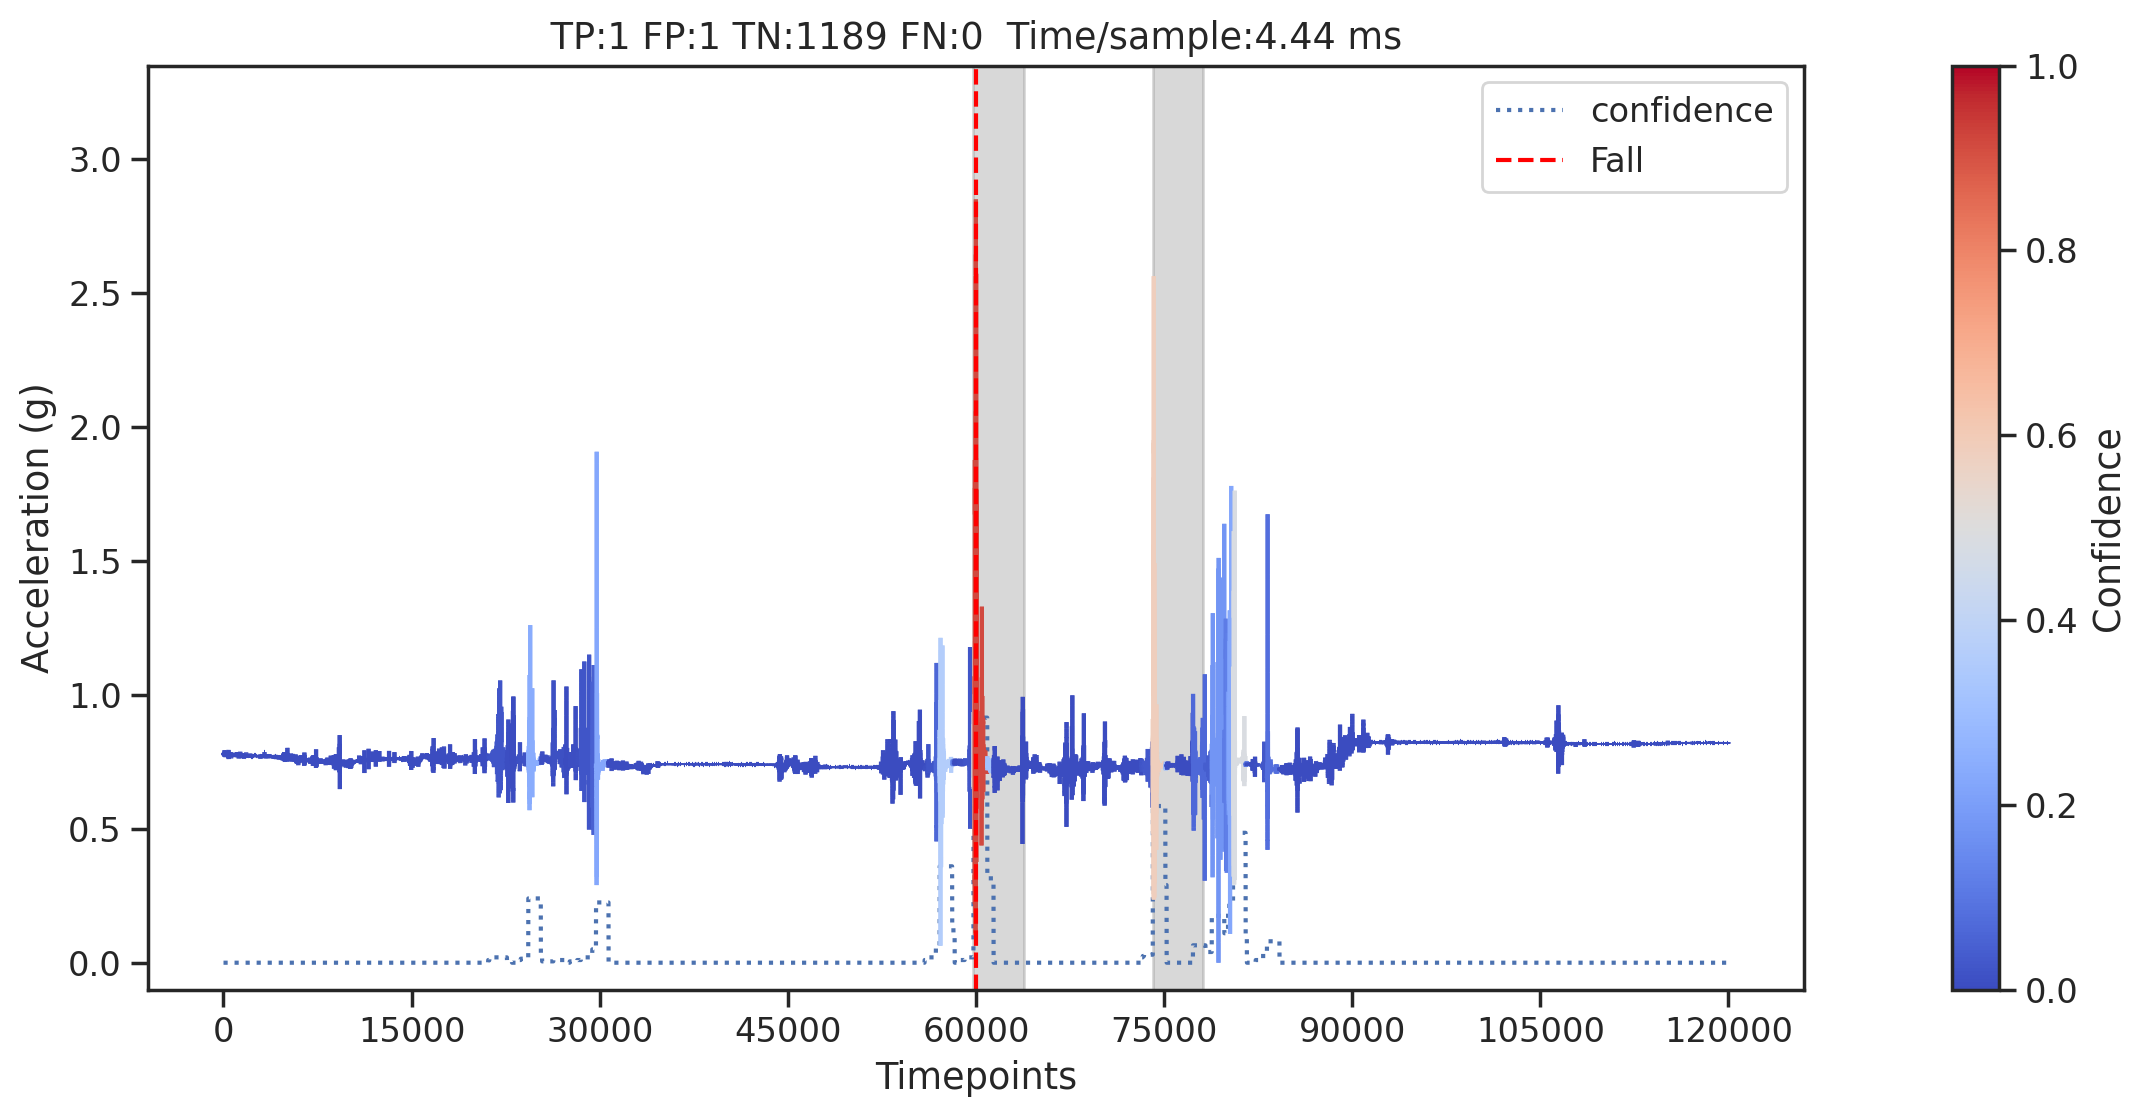

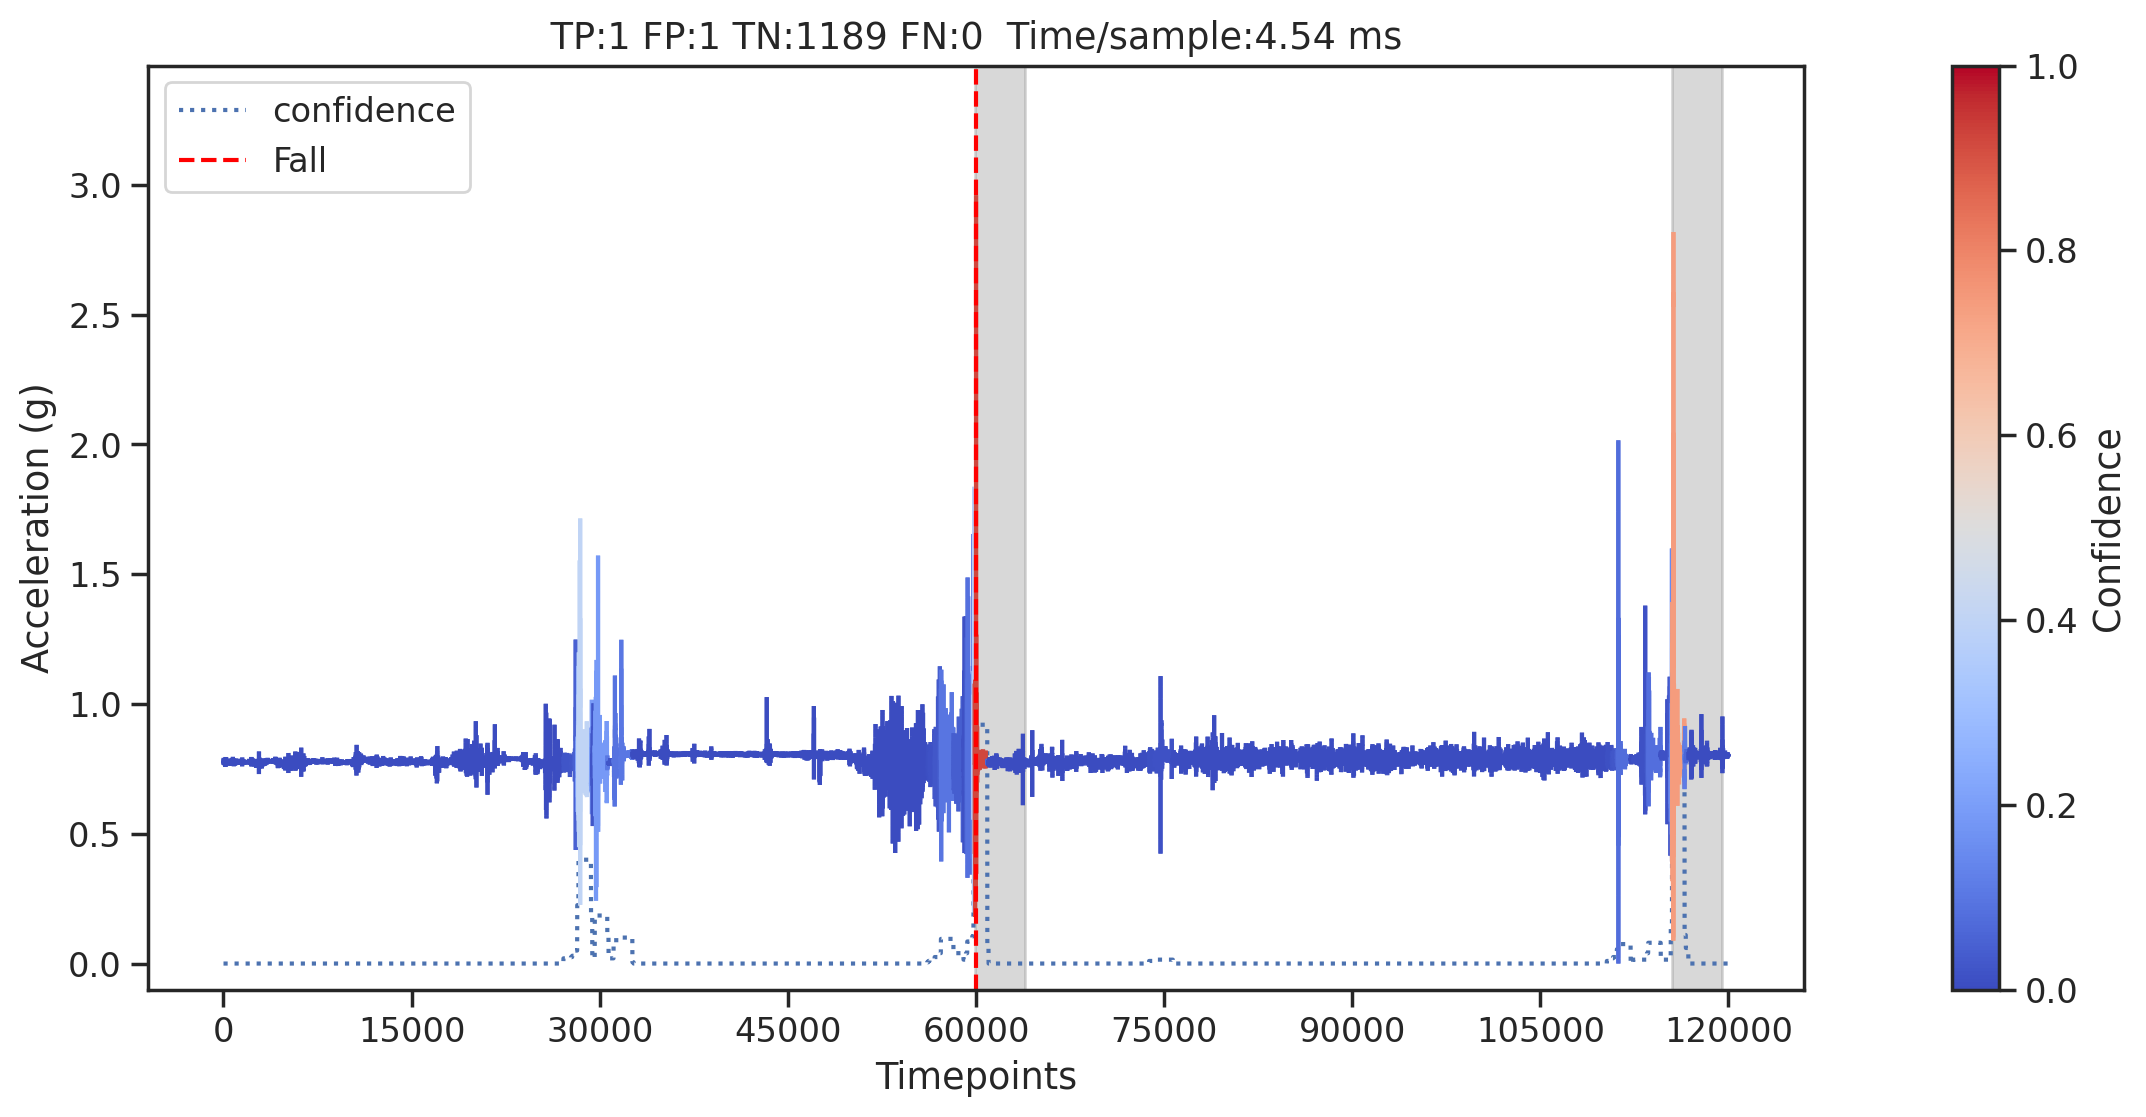

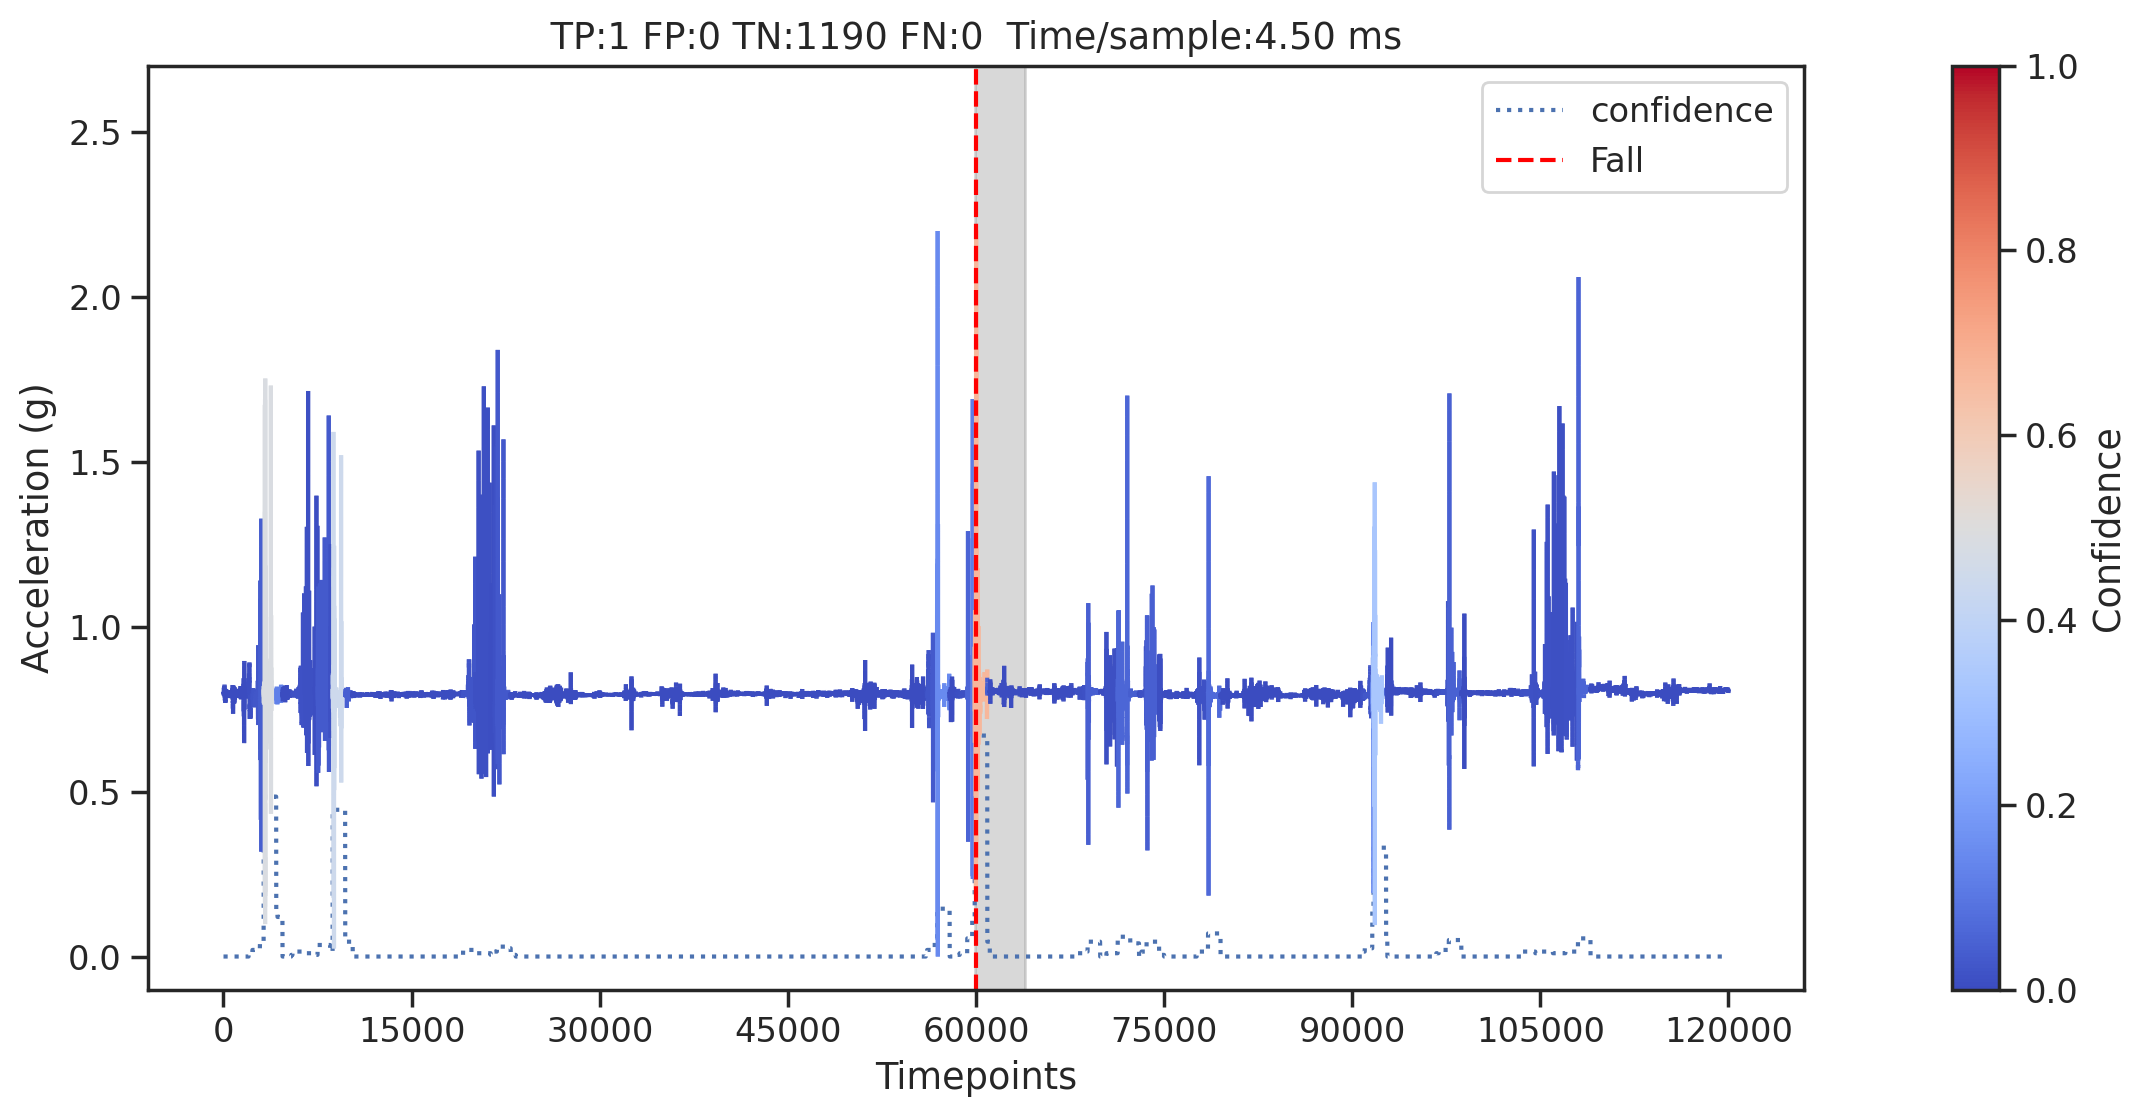

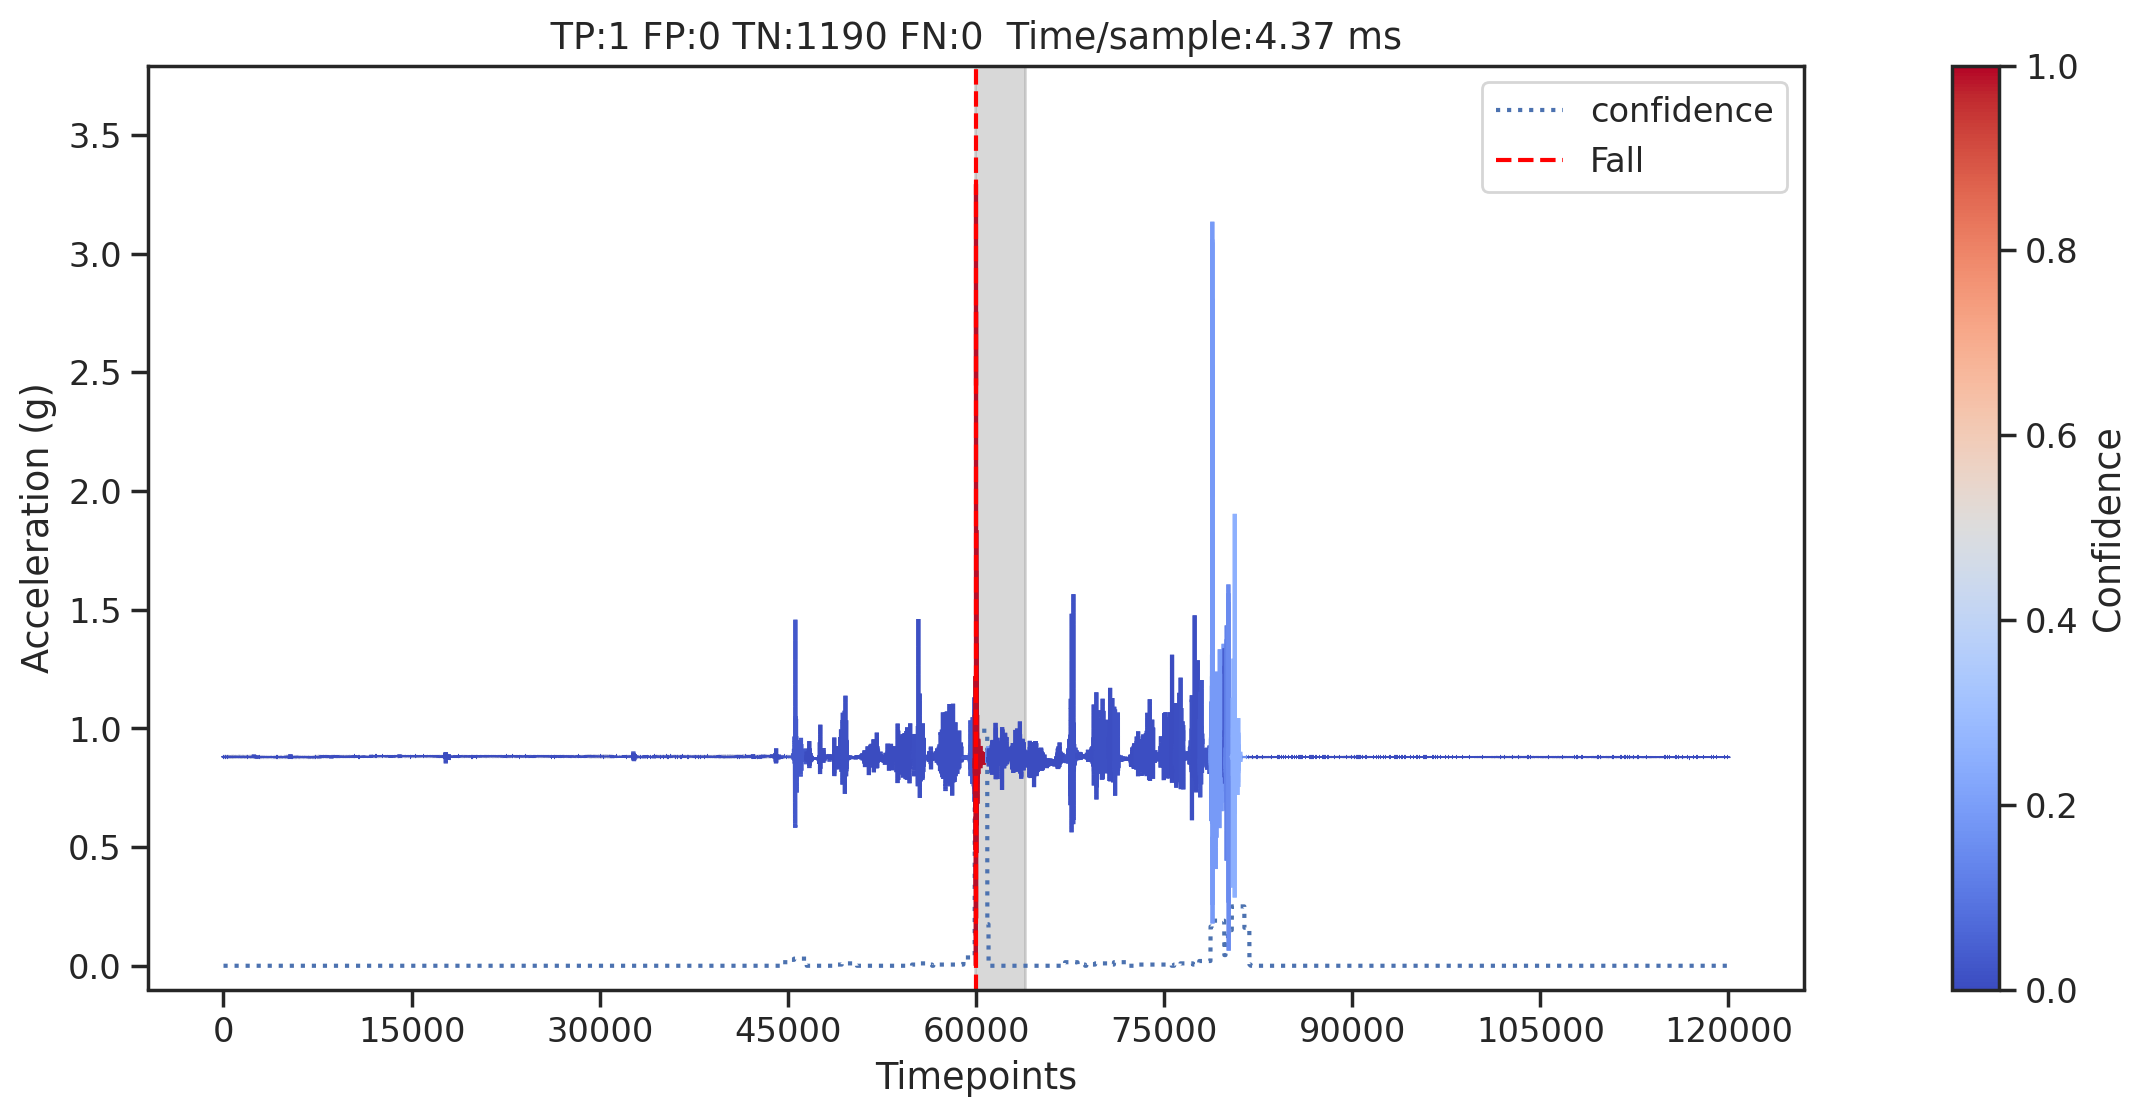

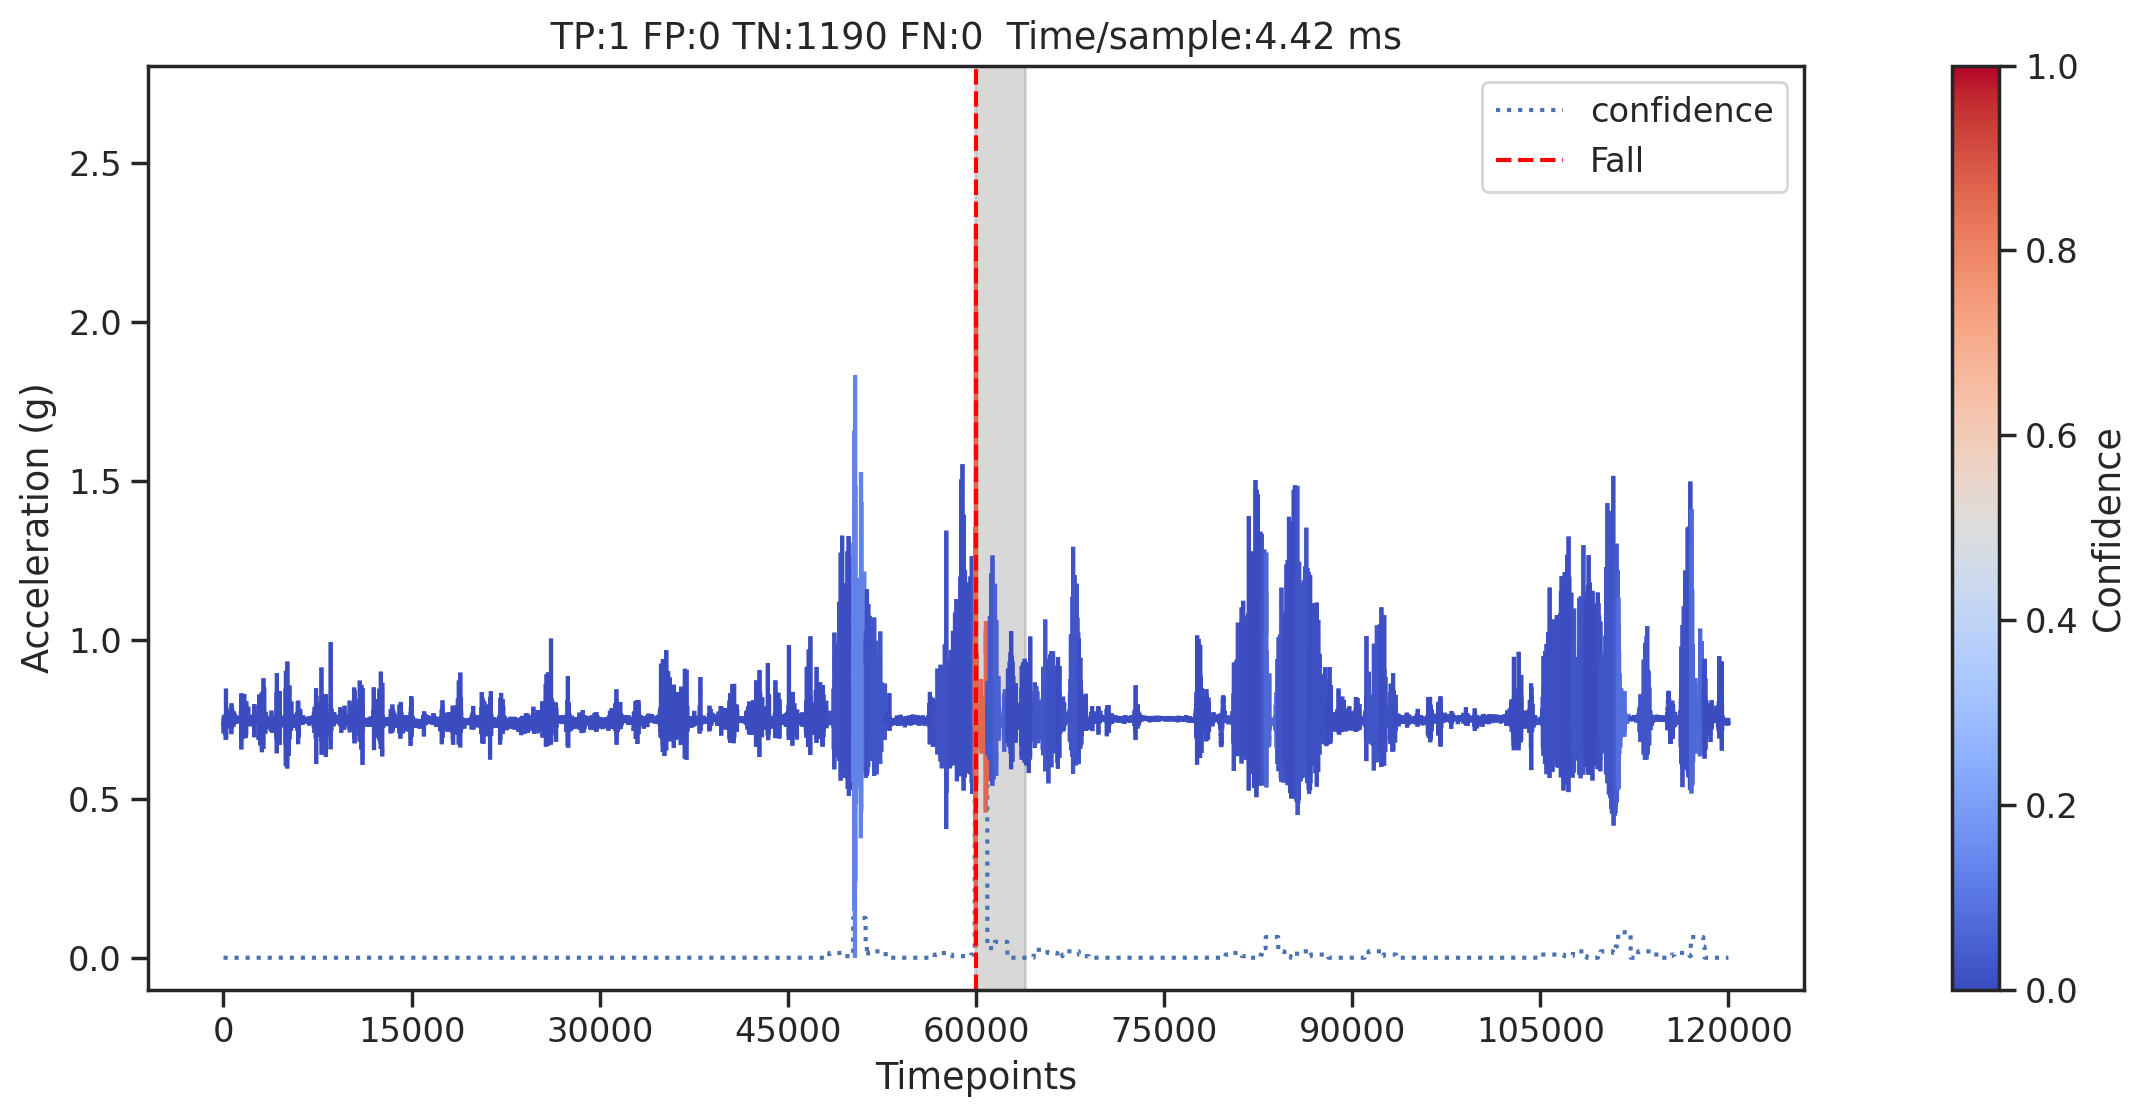

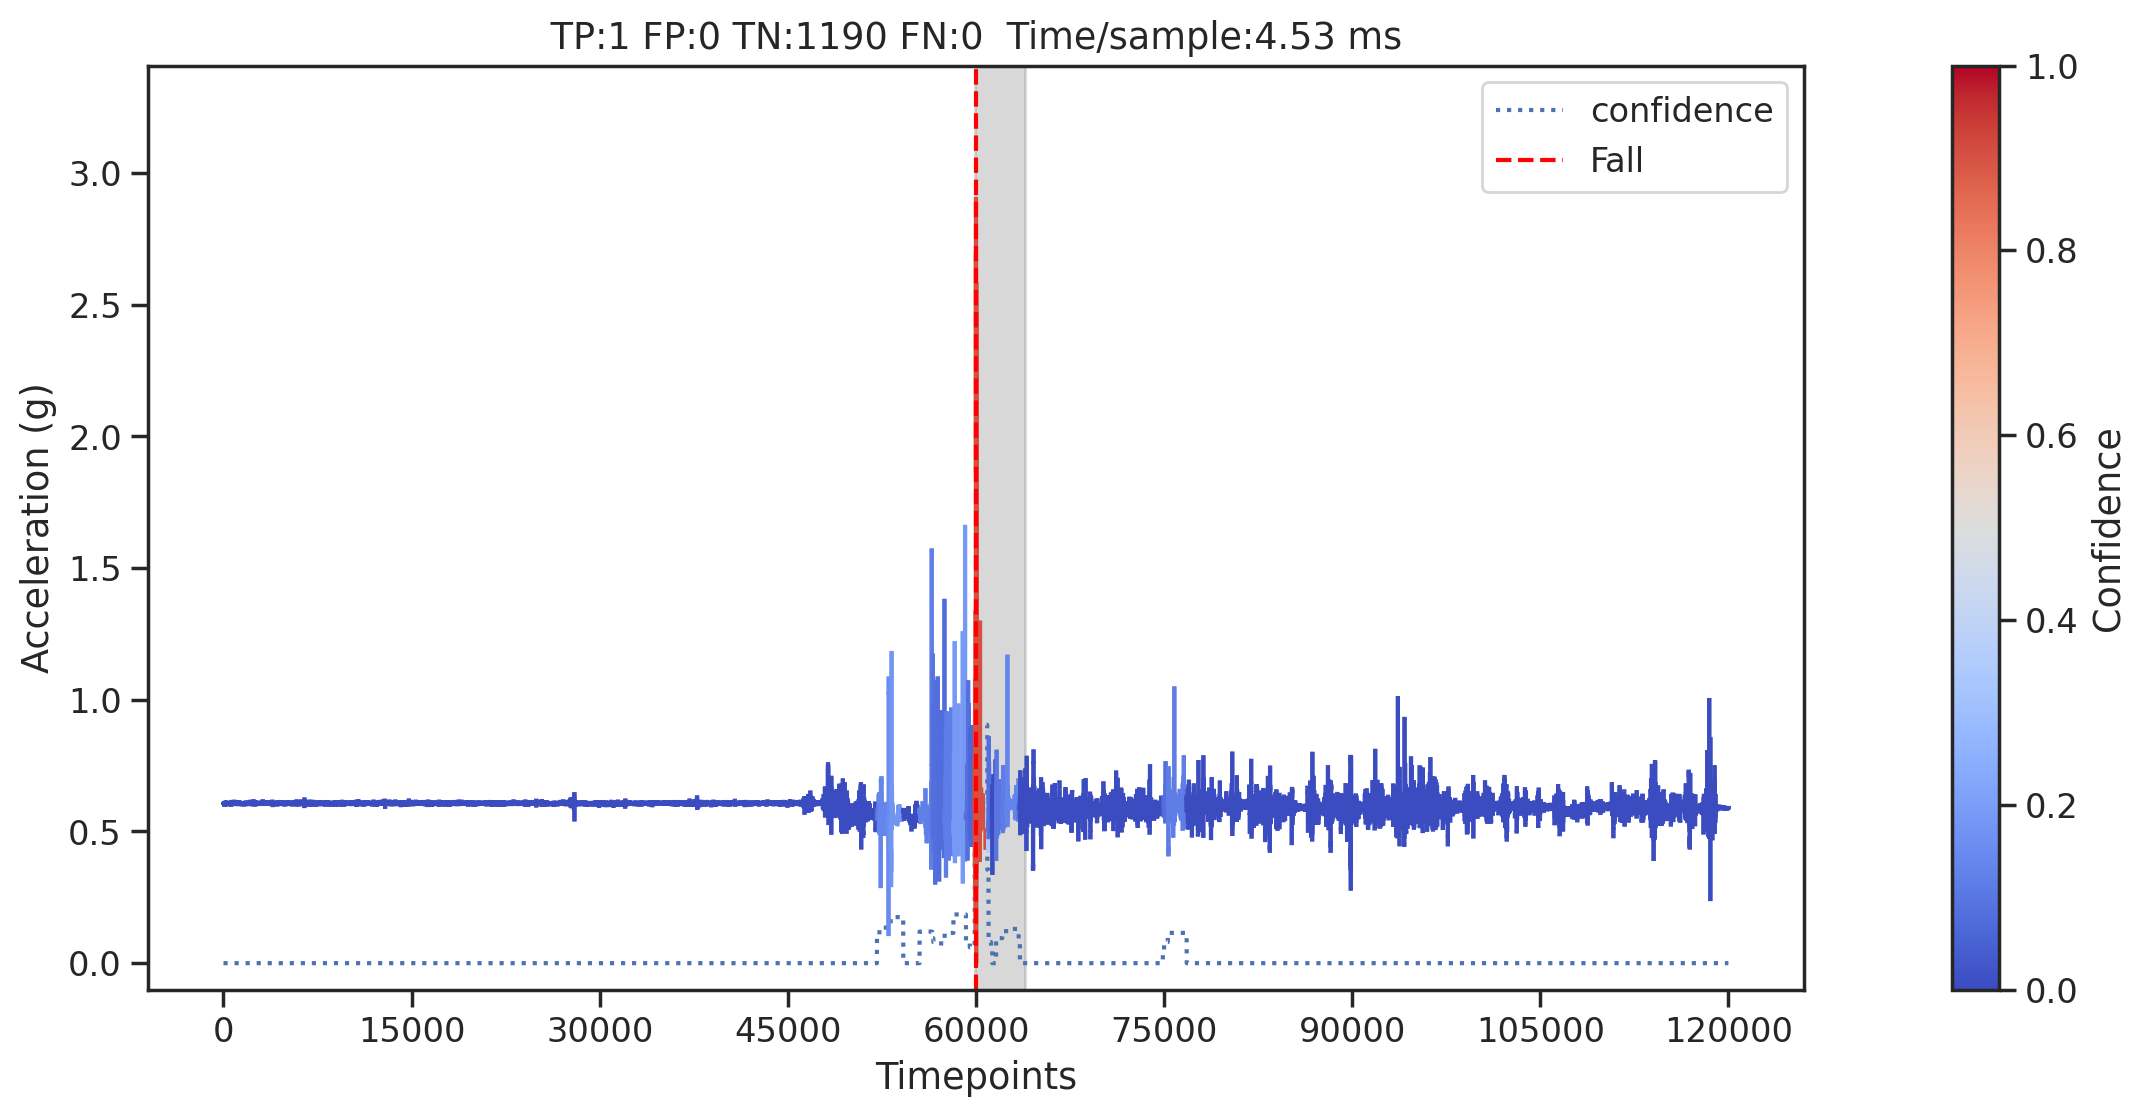

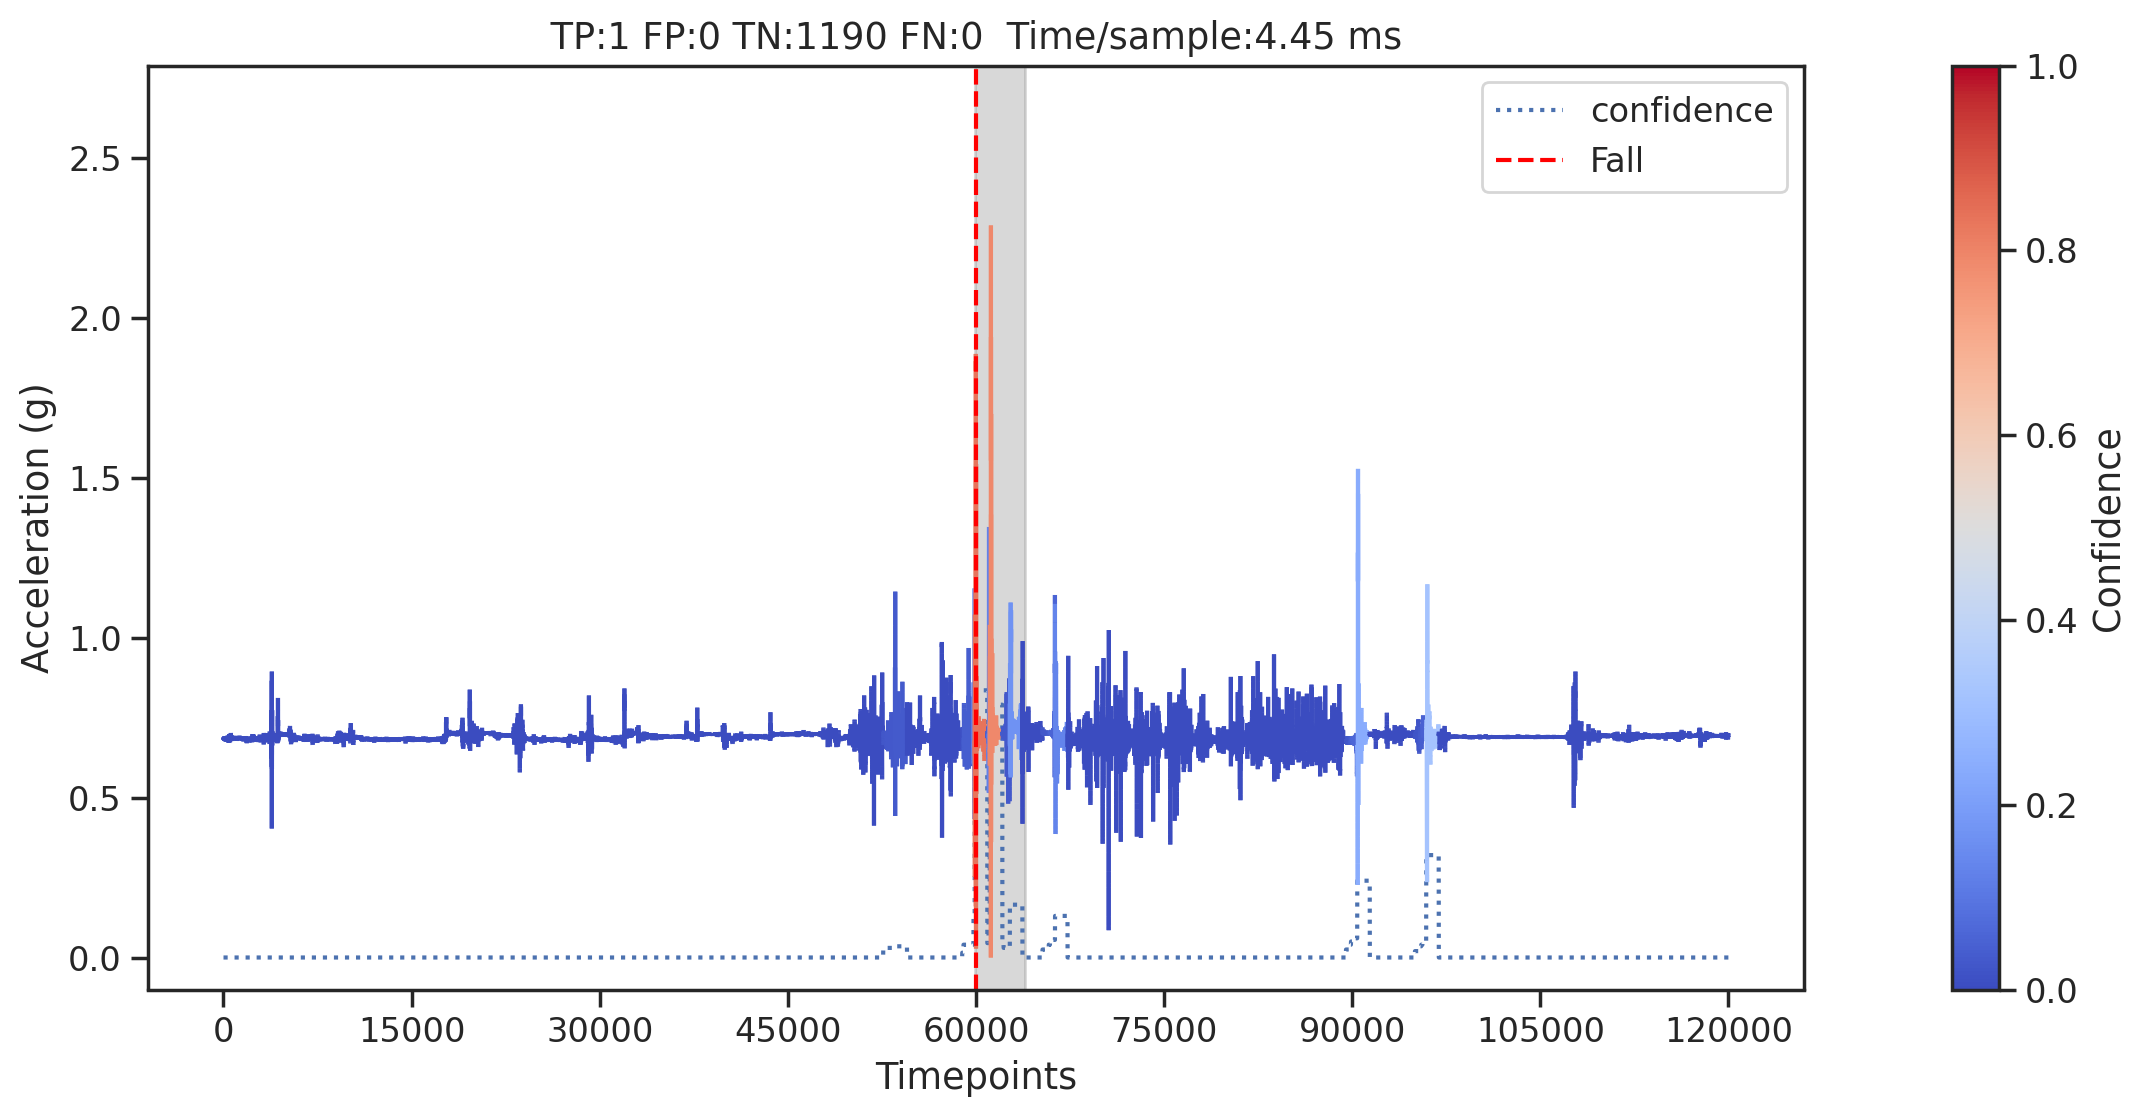

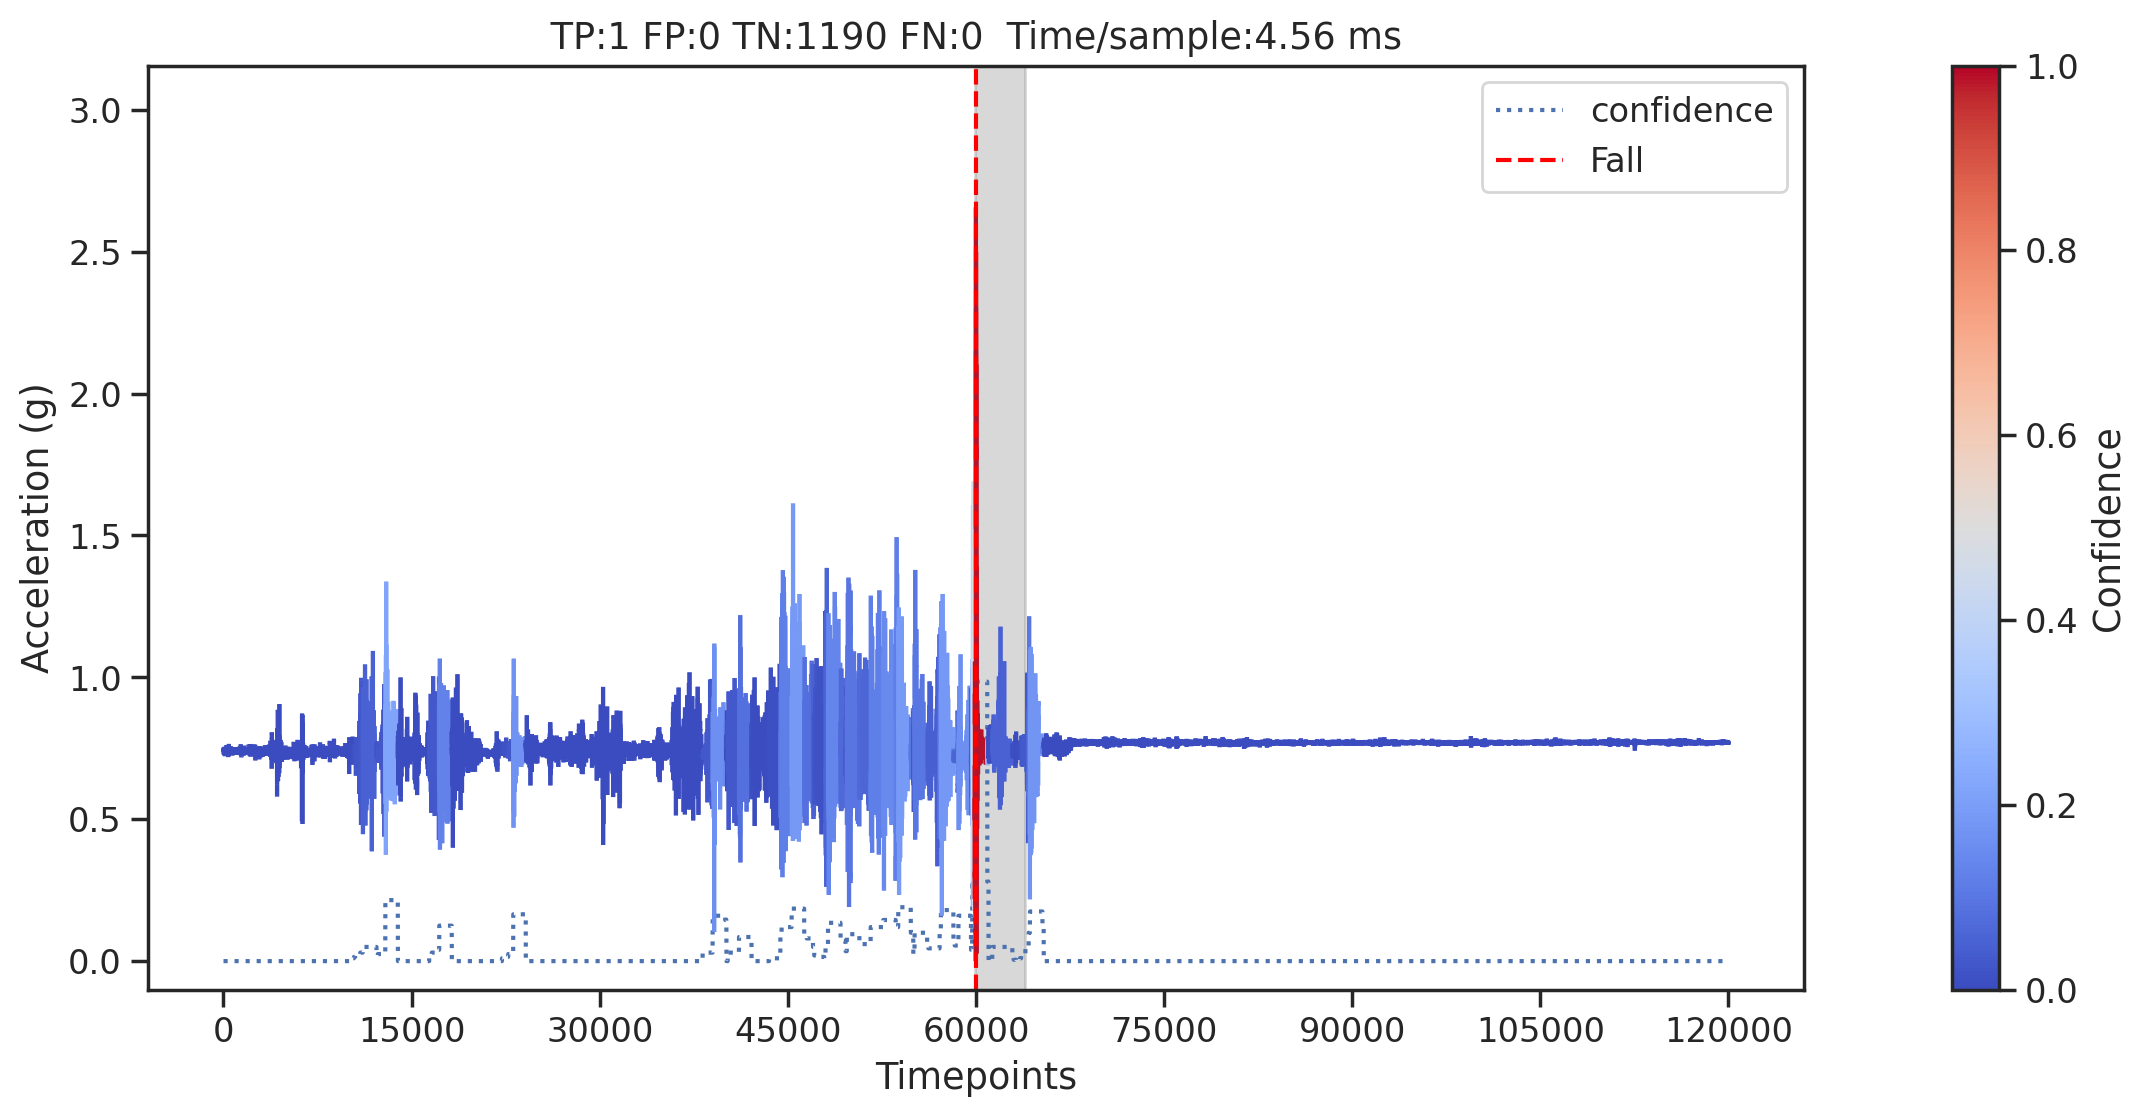

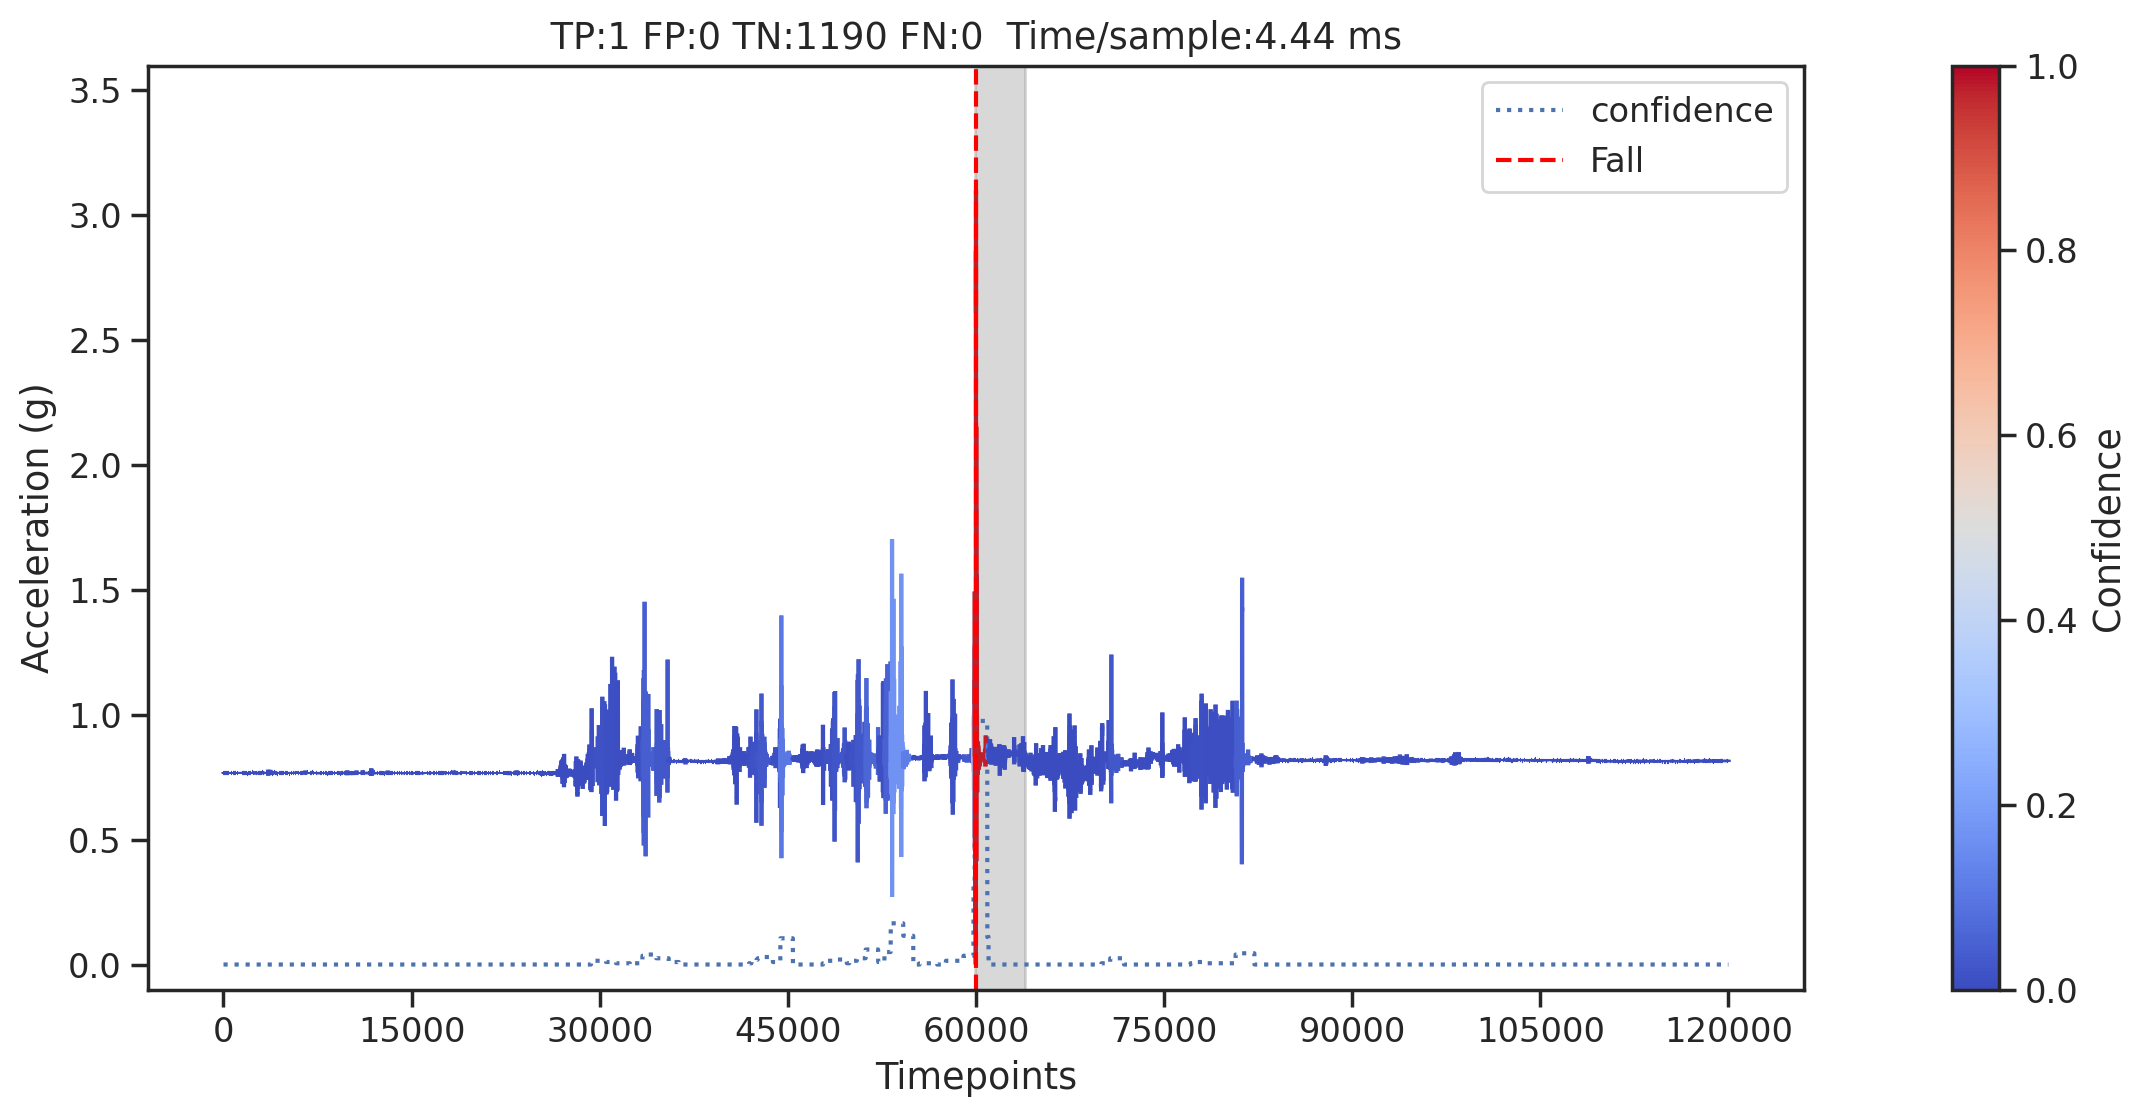

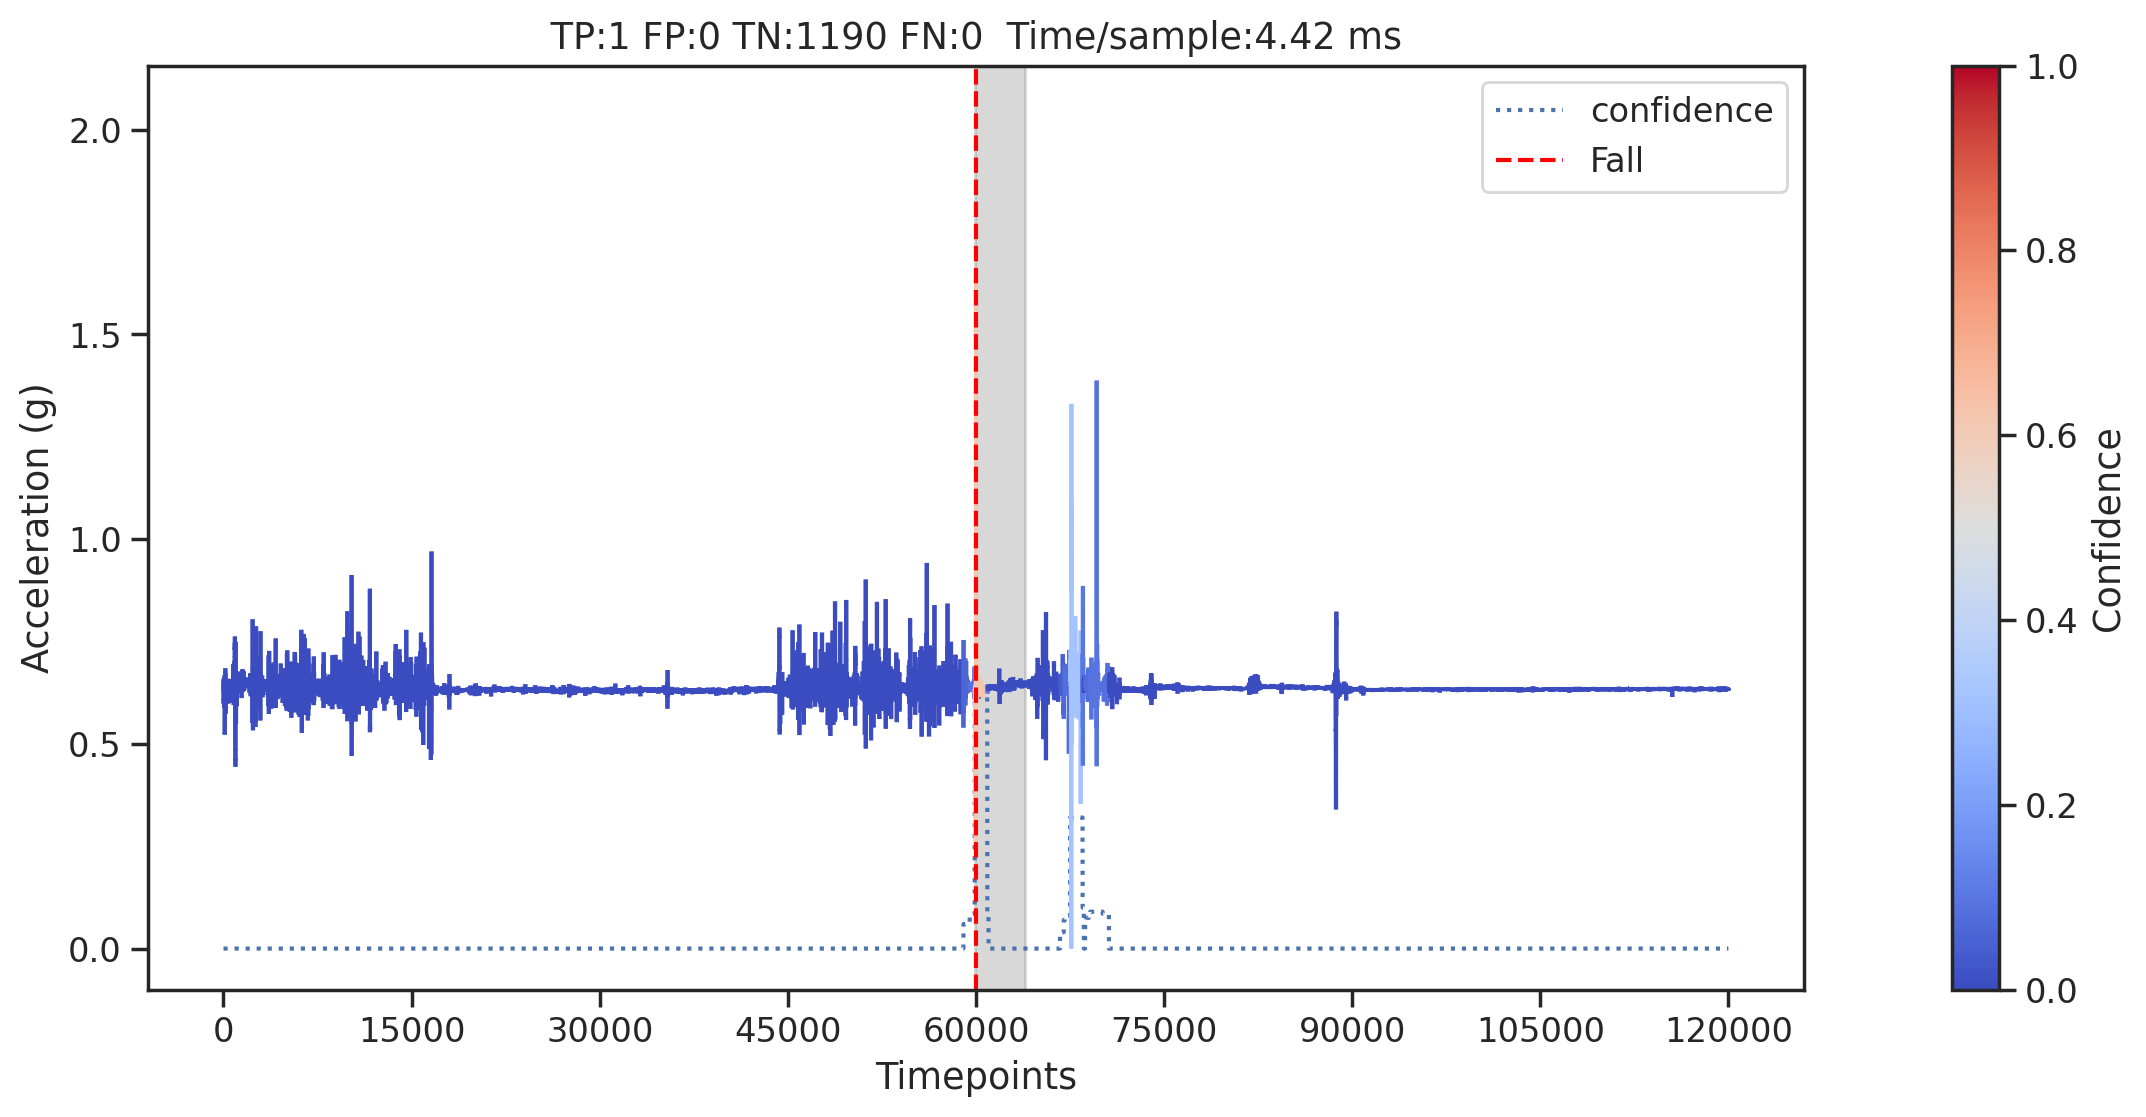

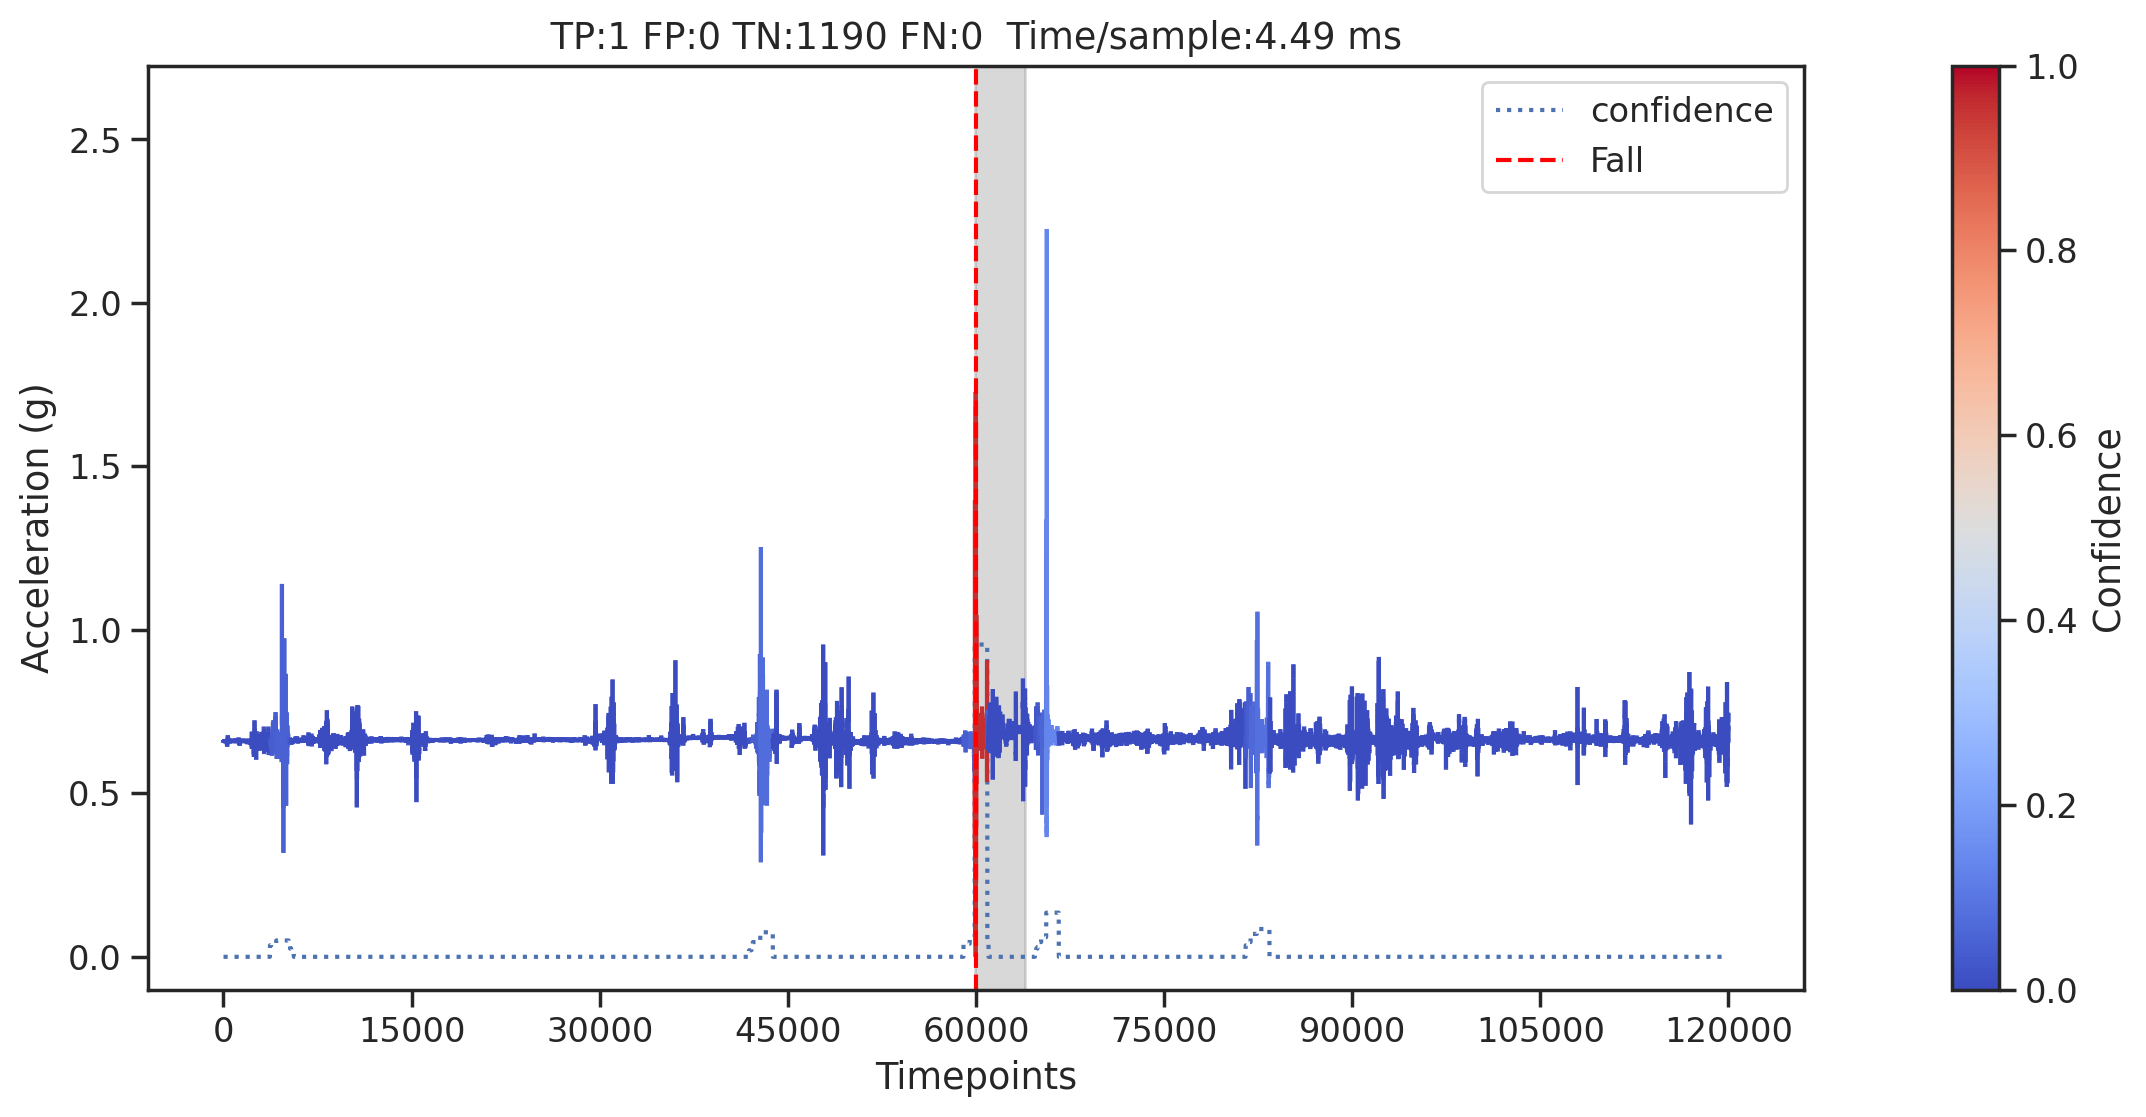

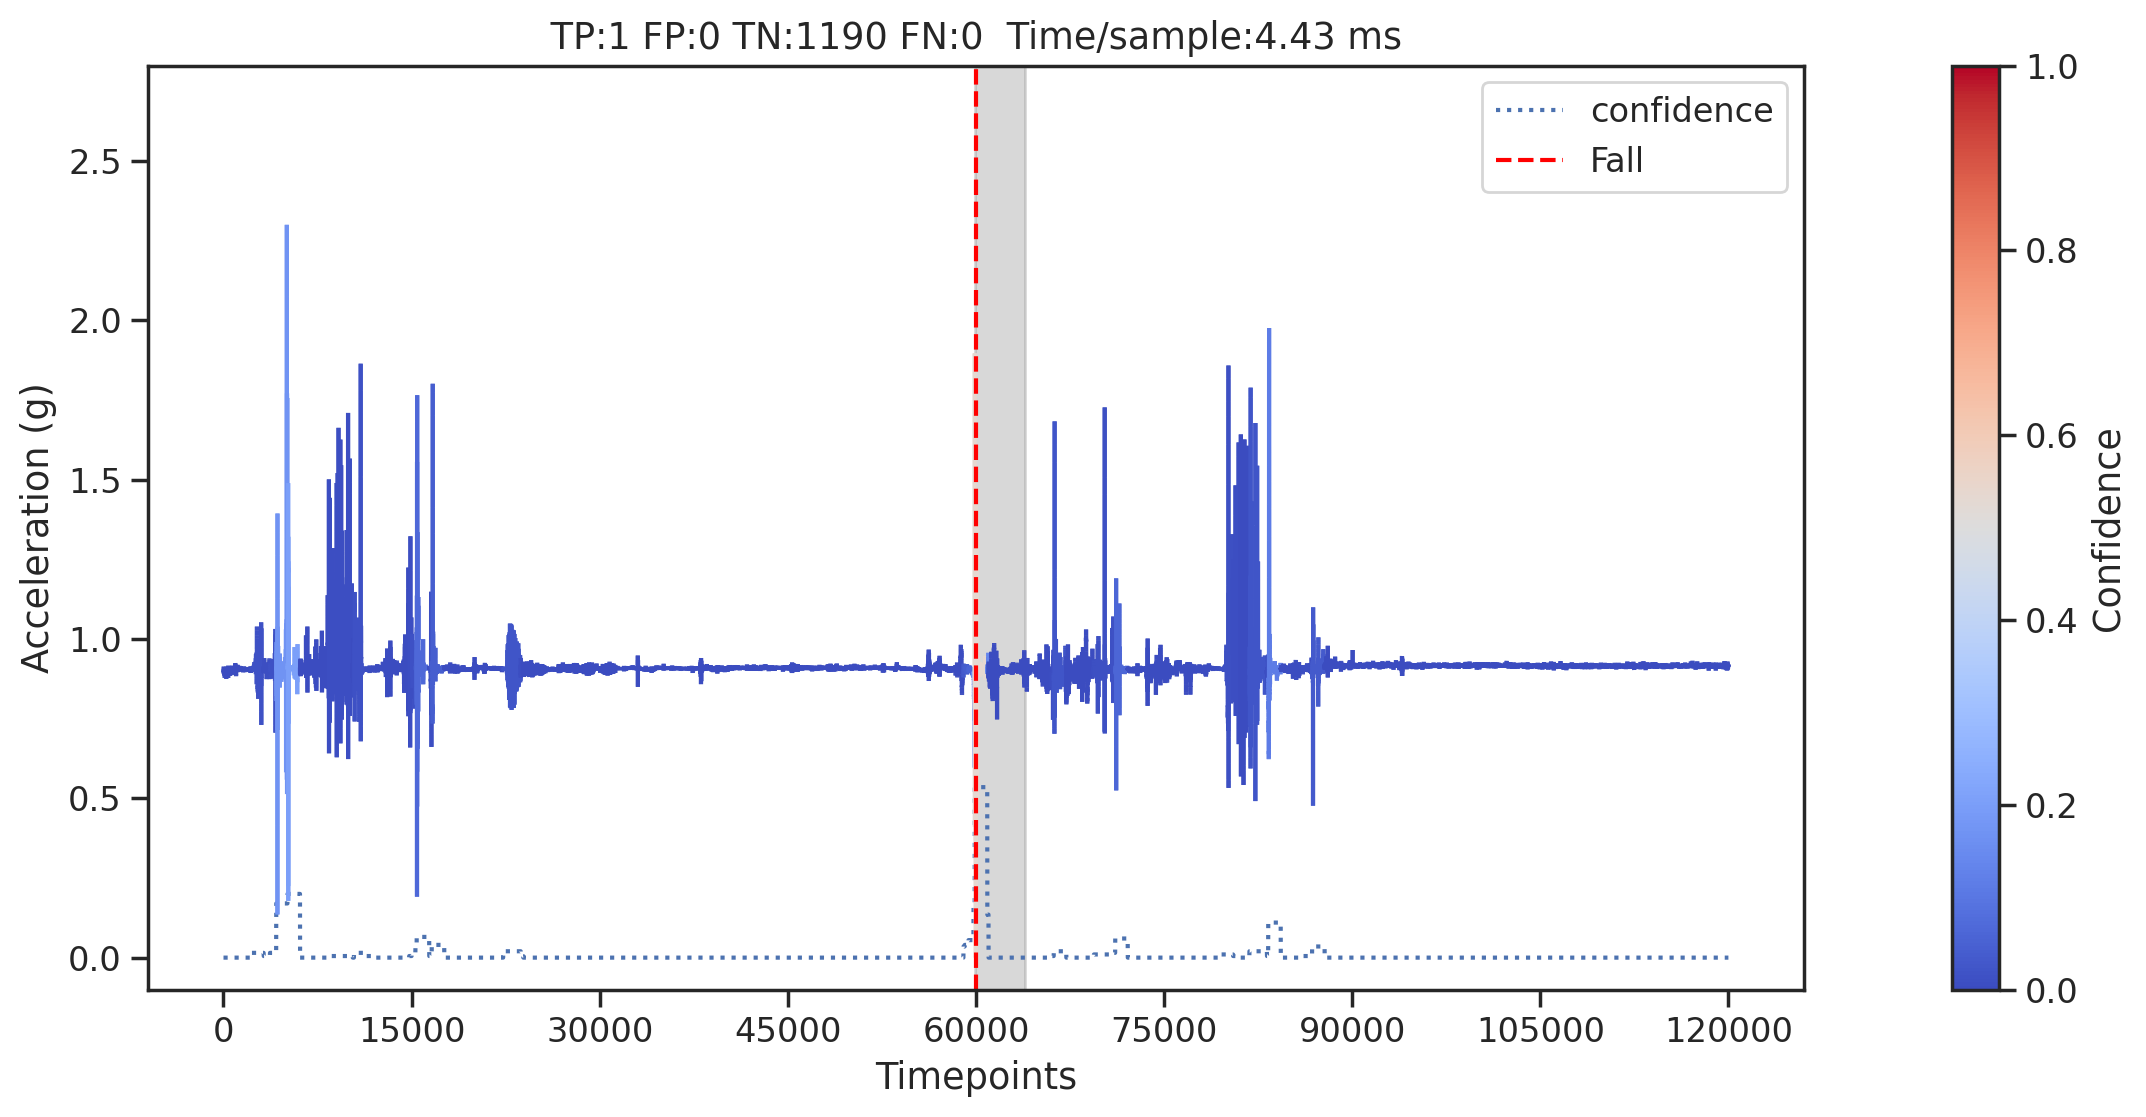

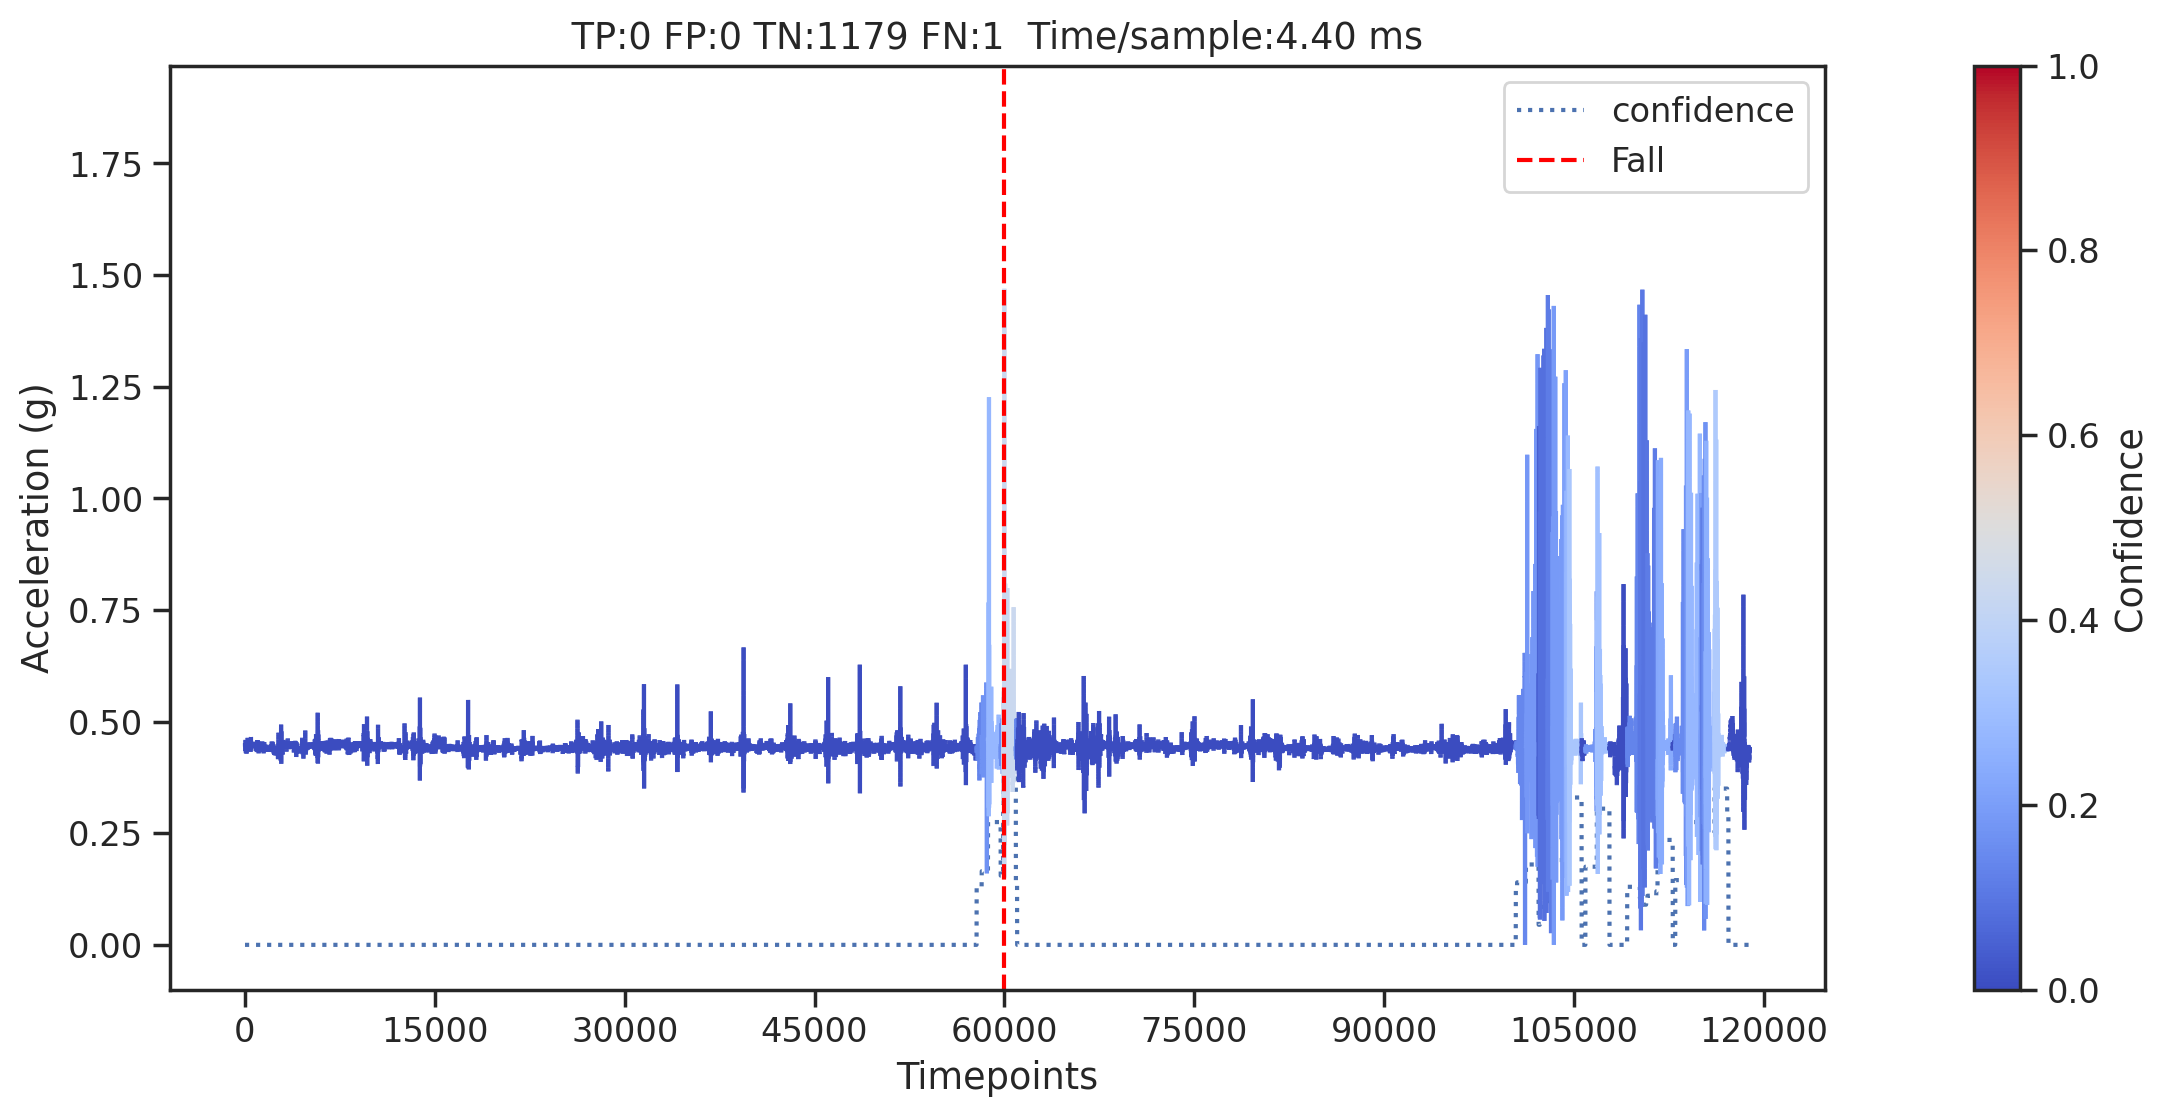

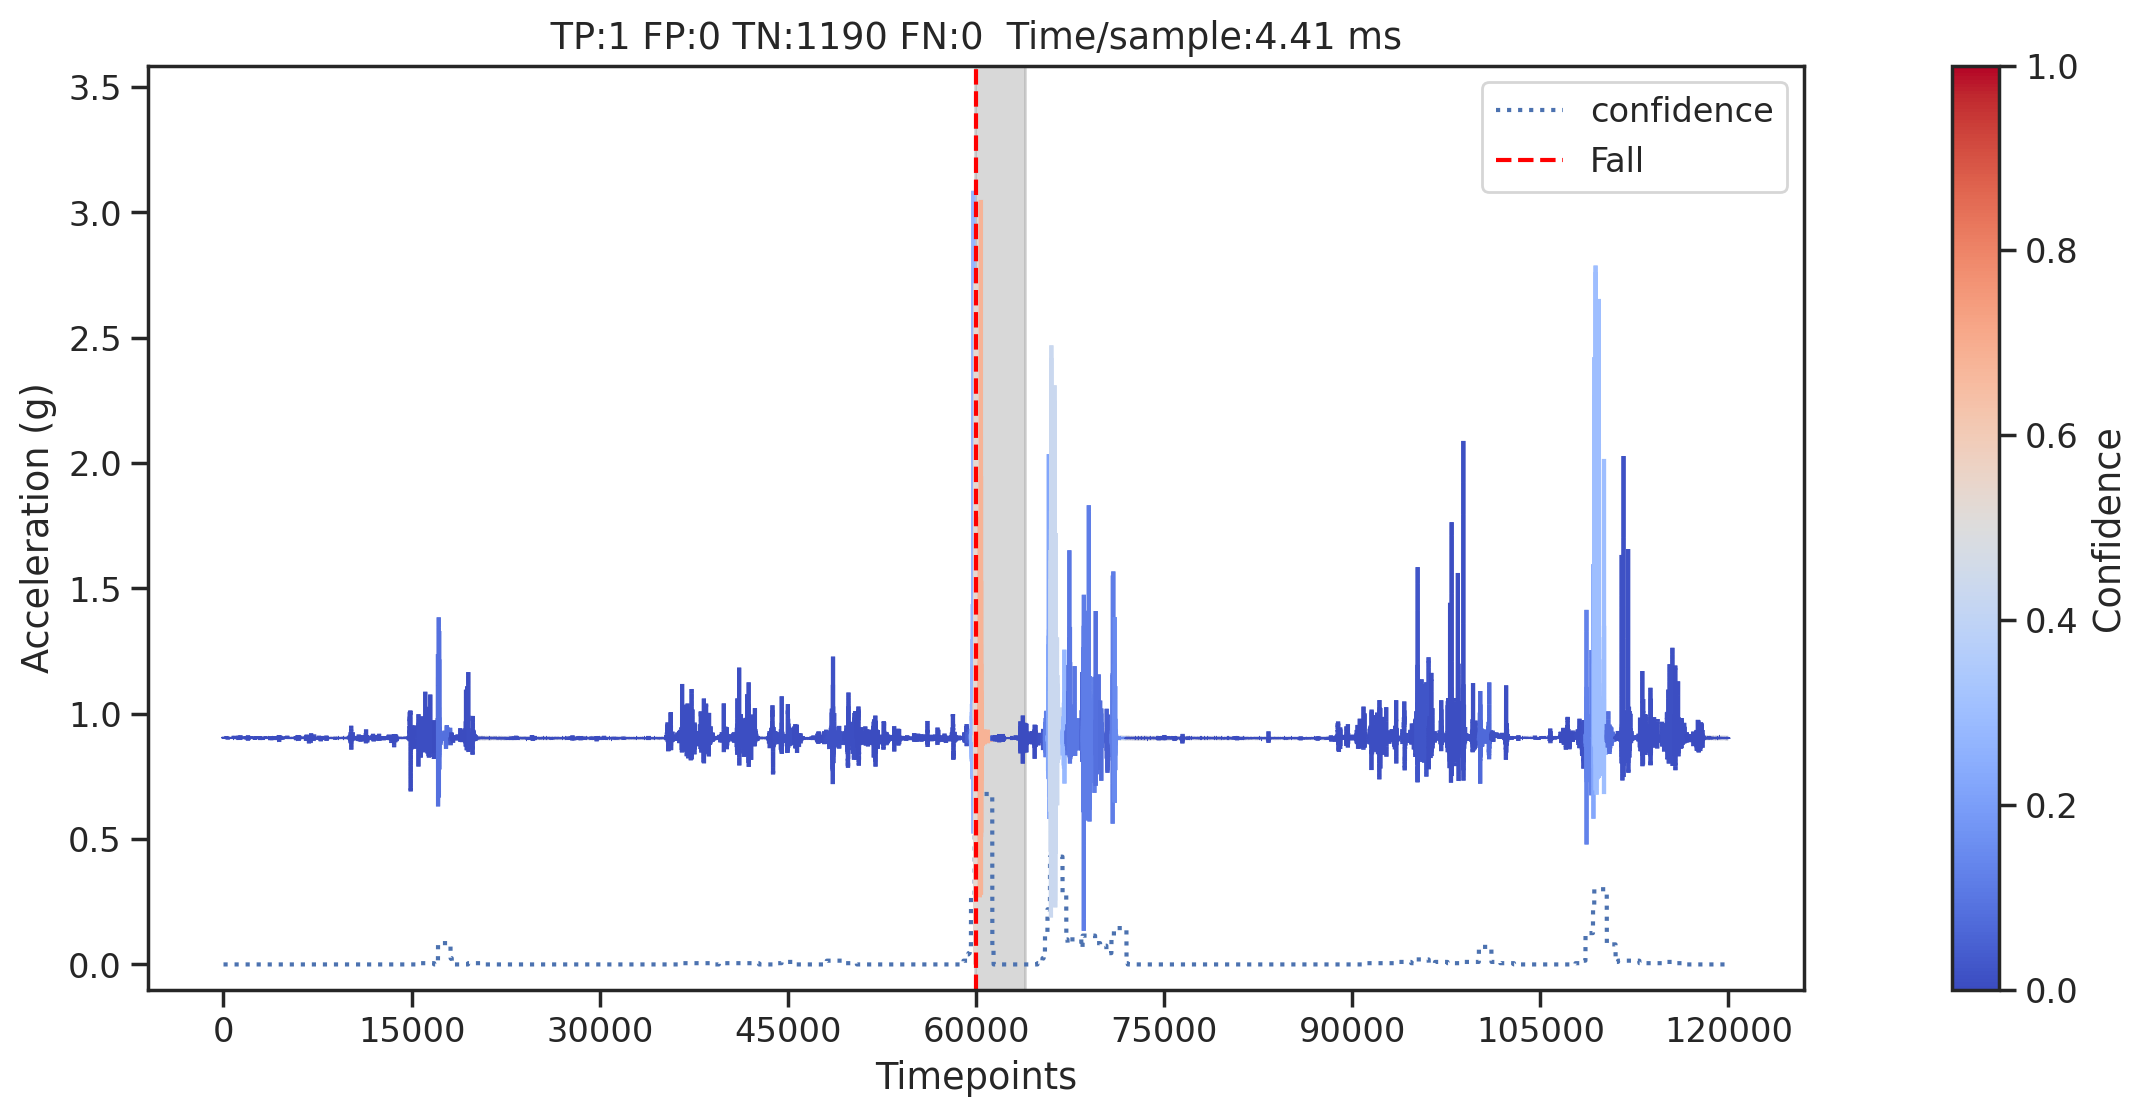

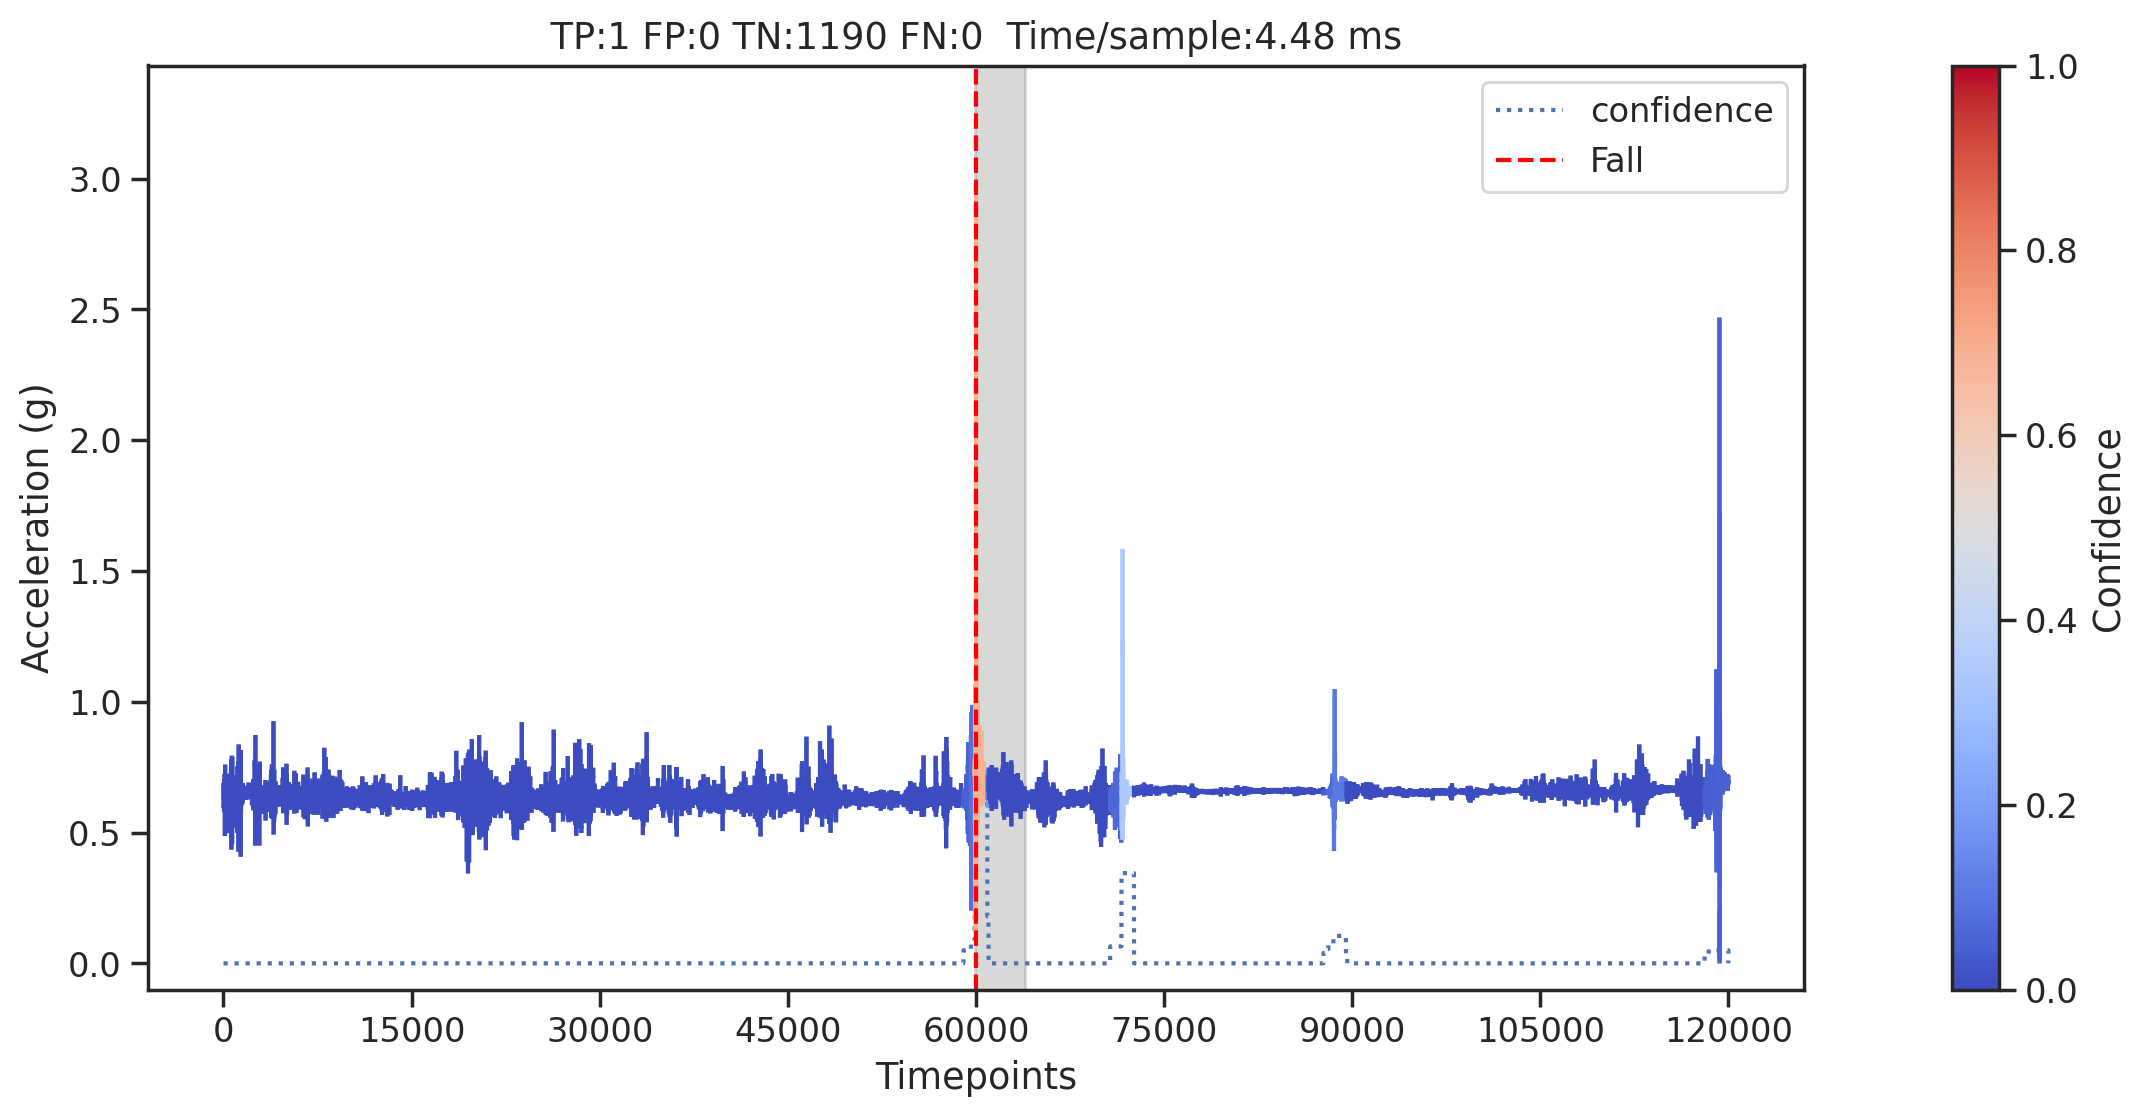

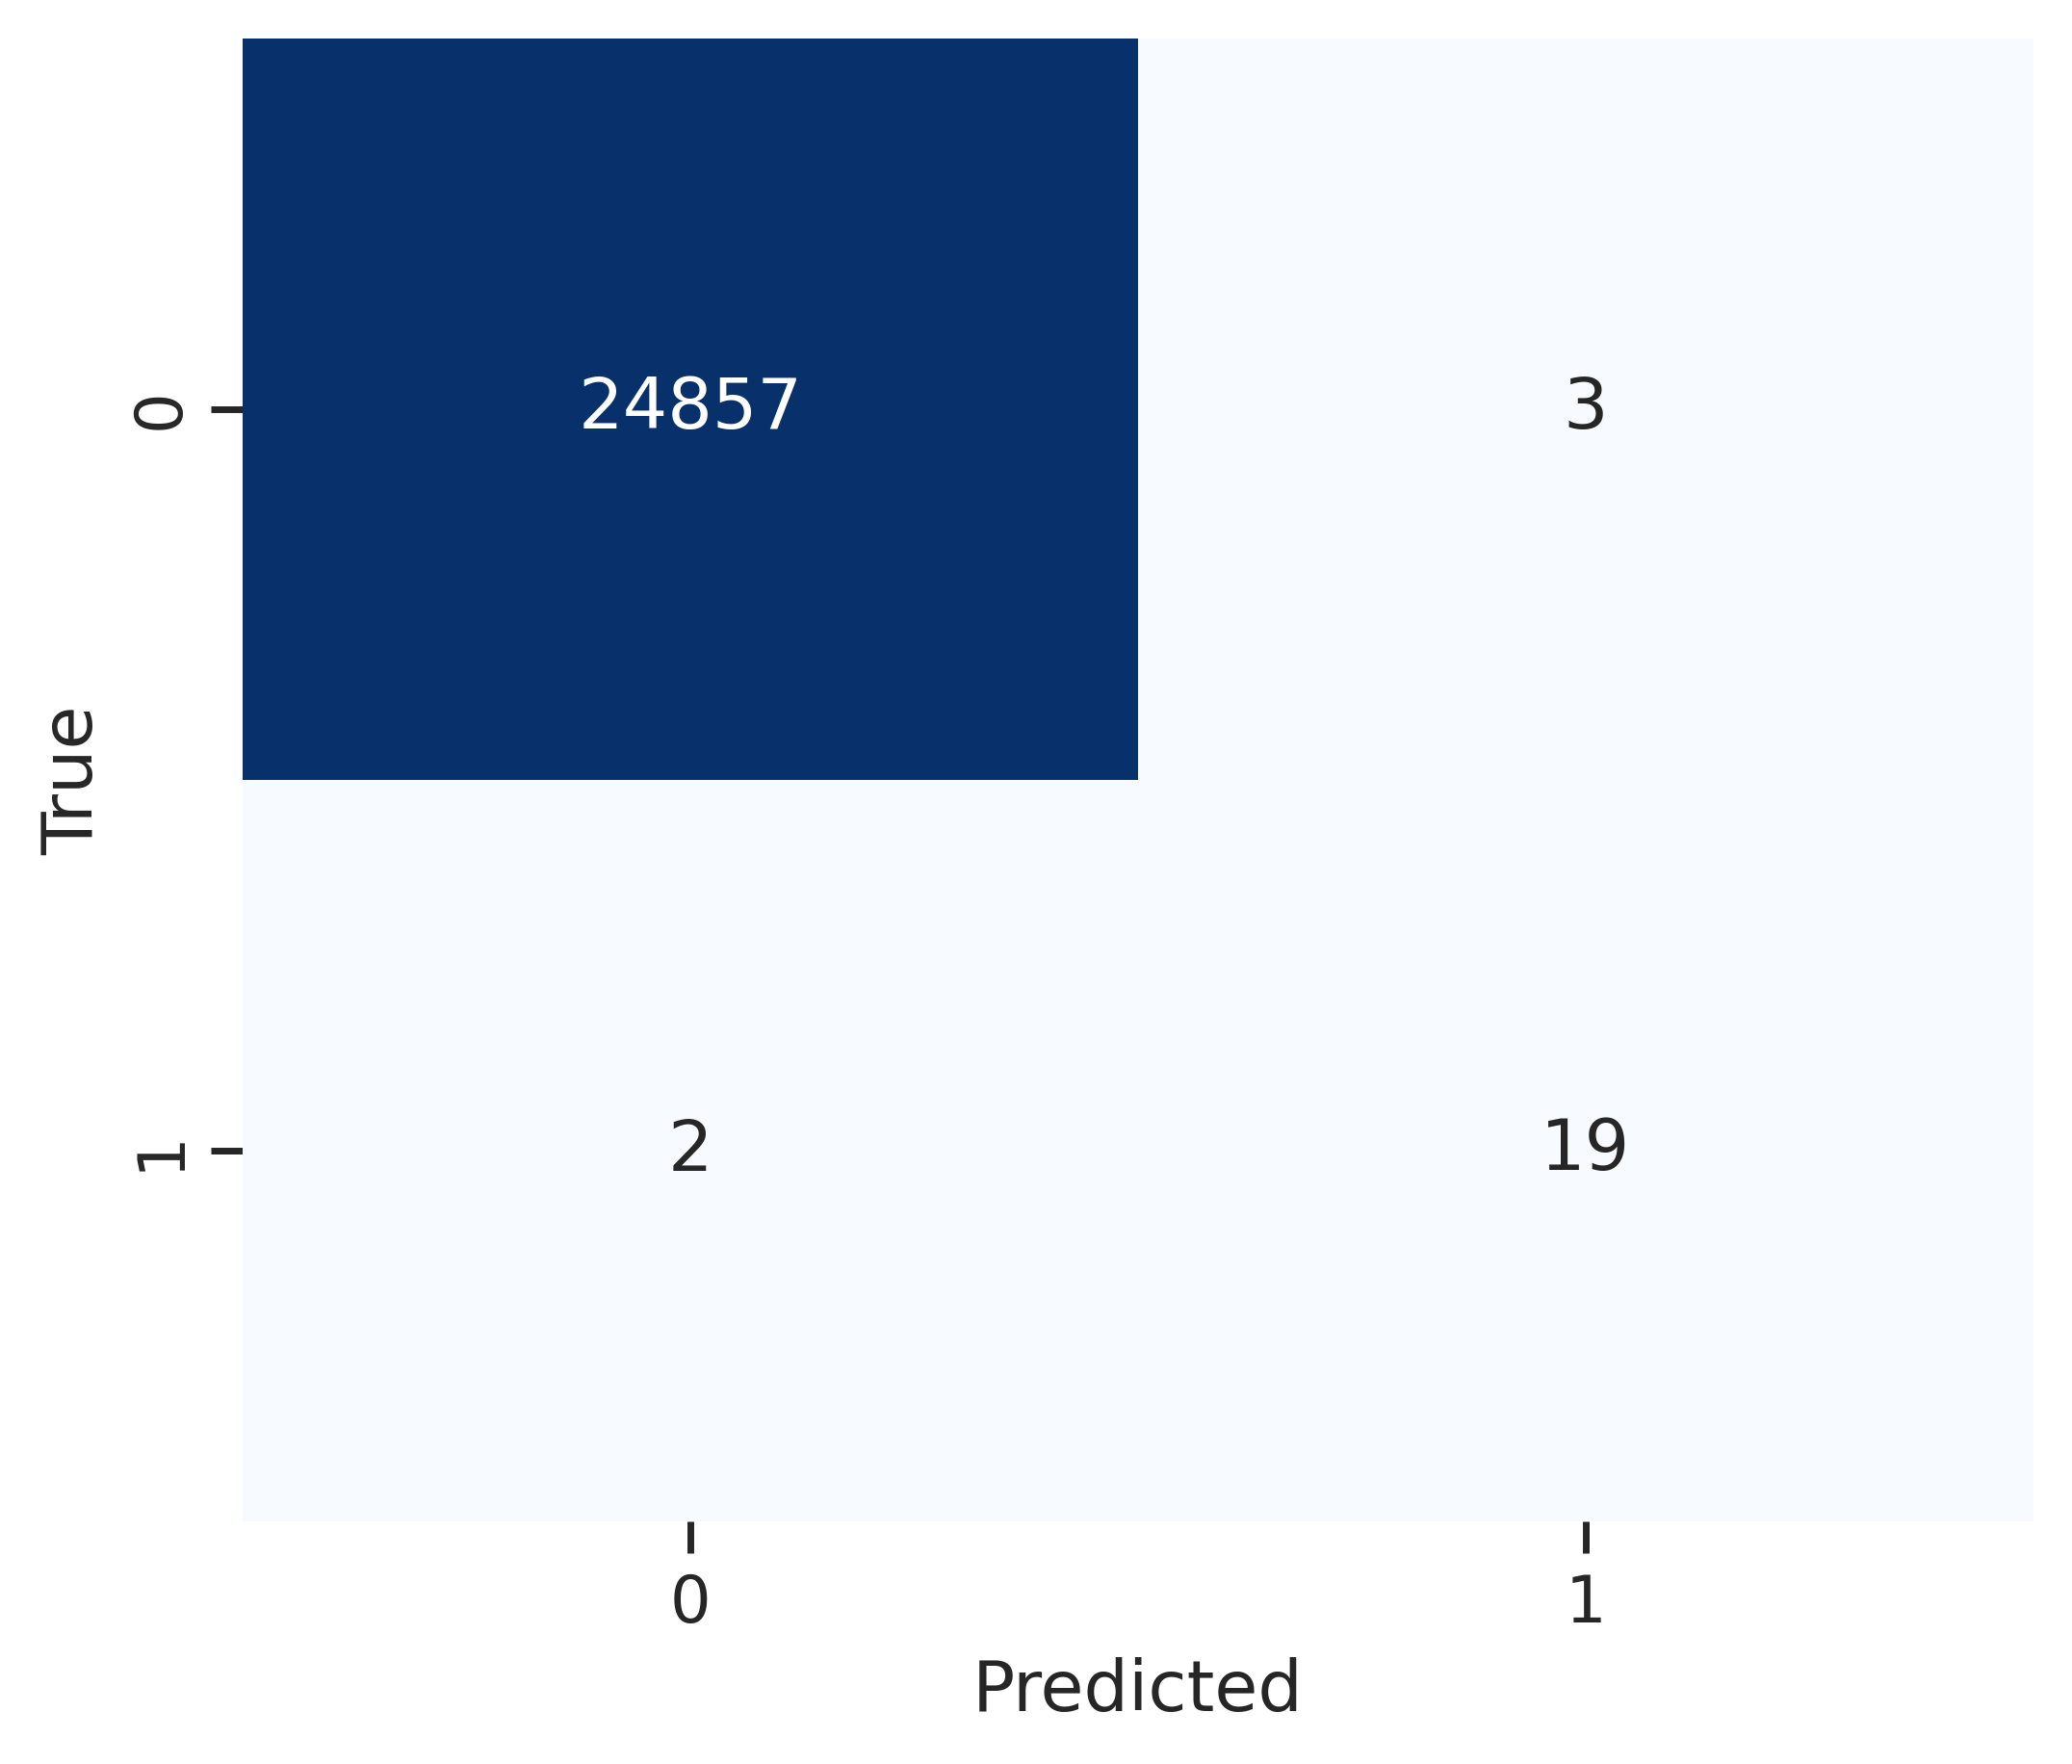

Evaluating models: 100%|██████████| 1/1 [01:50<00:00, 110.77s/it]
2025-08-19 16:05:17,037 [INFO] ✅ Evaluation complete
2025-08-19 16:05:17,040 [INFO] Training models (seed=0)



Running models for window size 10 seconds, tuning with fn_factor=2


Training (seed=0):   0%|          | 0/1 [00:00<?, ?it/s]2025-08-19 16:06:05,299 [INFO] Saved tuned model and CV results for QUANT to results/model_cache
2025-08-19 16:06:05,300 [INFO] QUANT: threshold tuned to 0.40
Evaluating models:   0%|          | 0/1 [00:00<?, ?it/s]

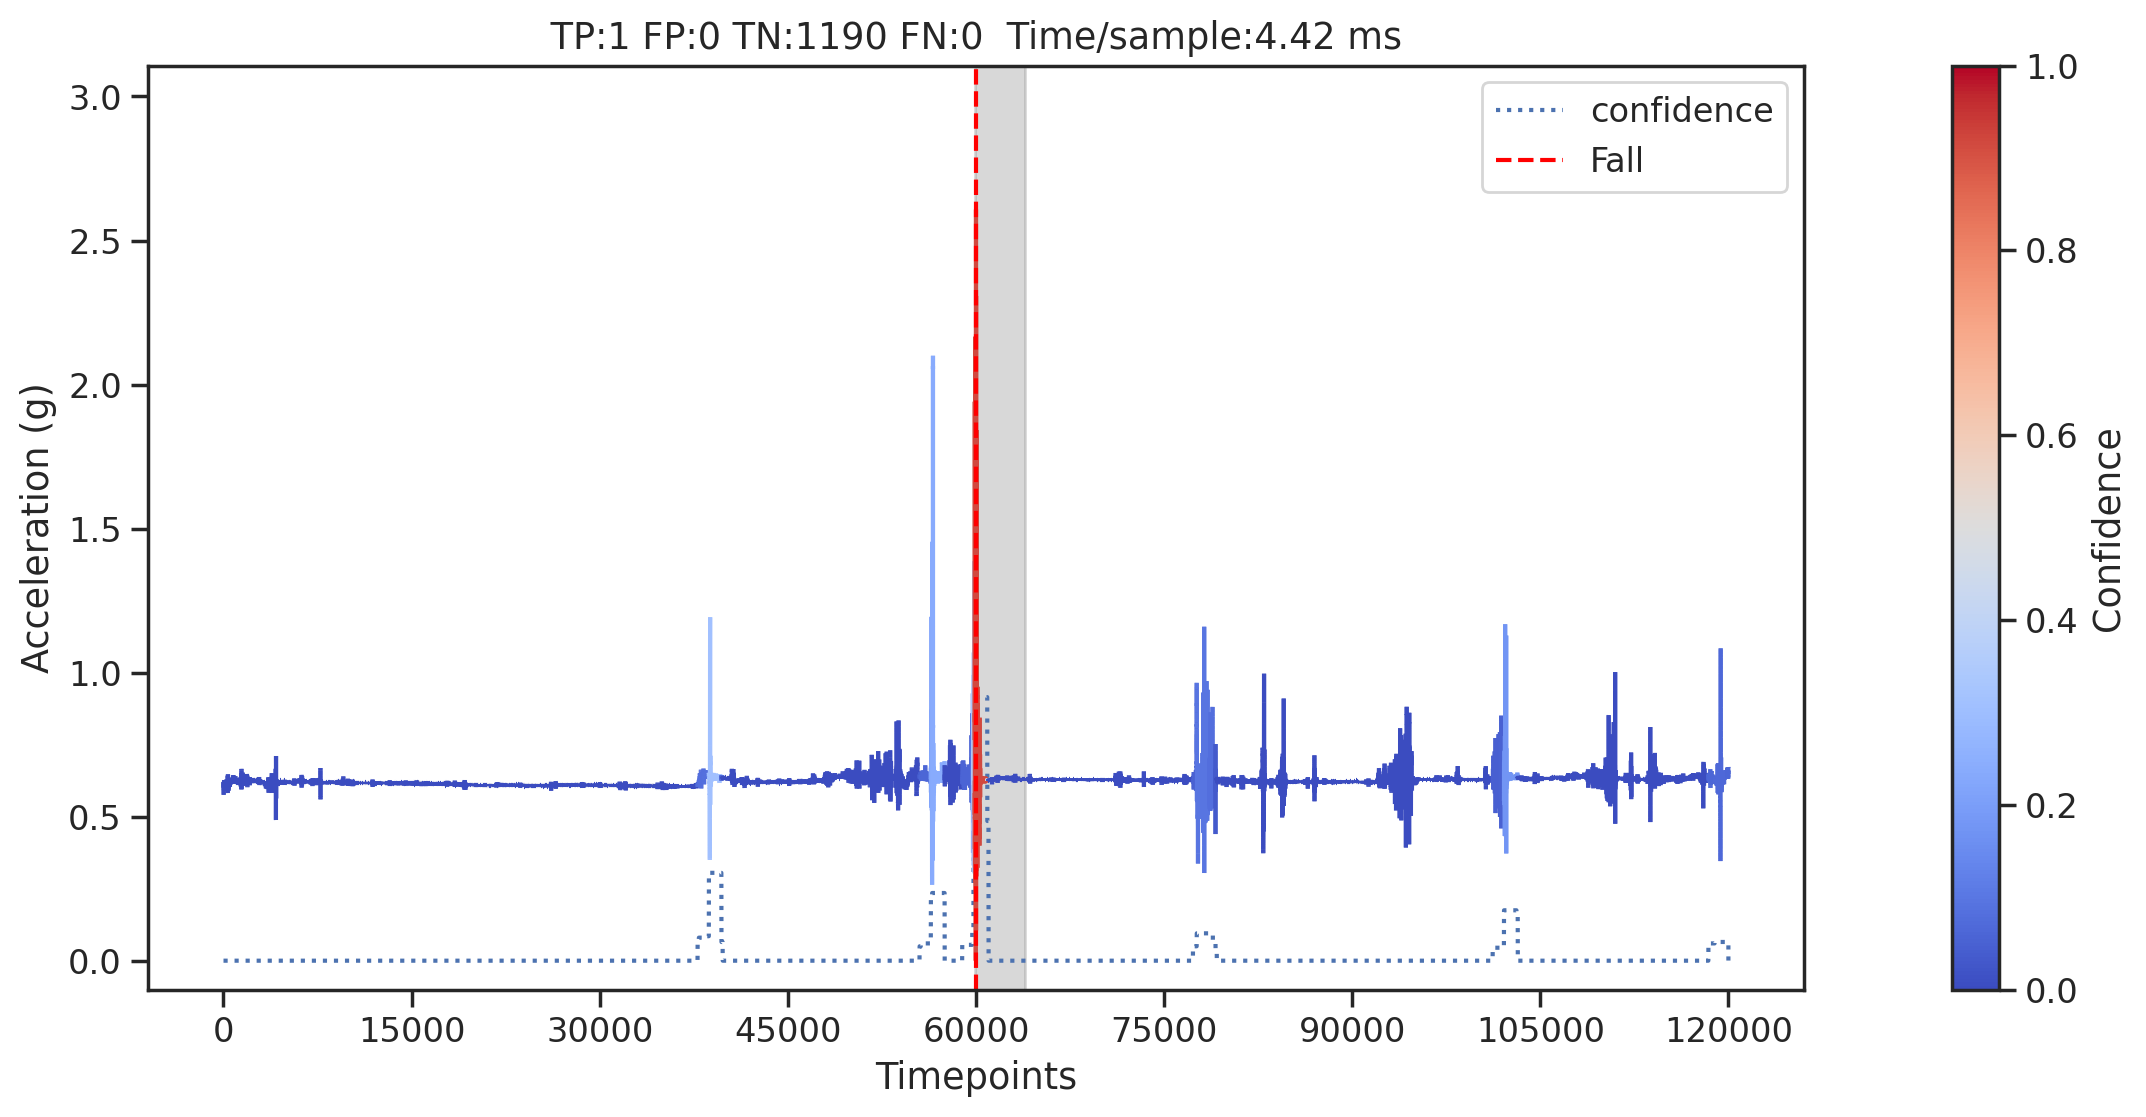

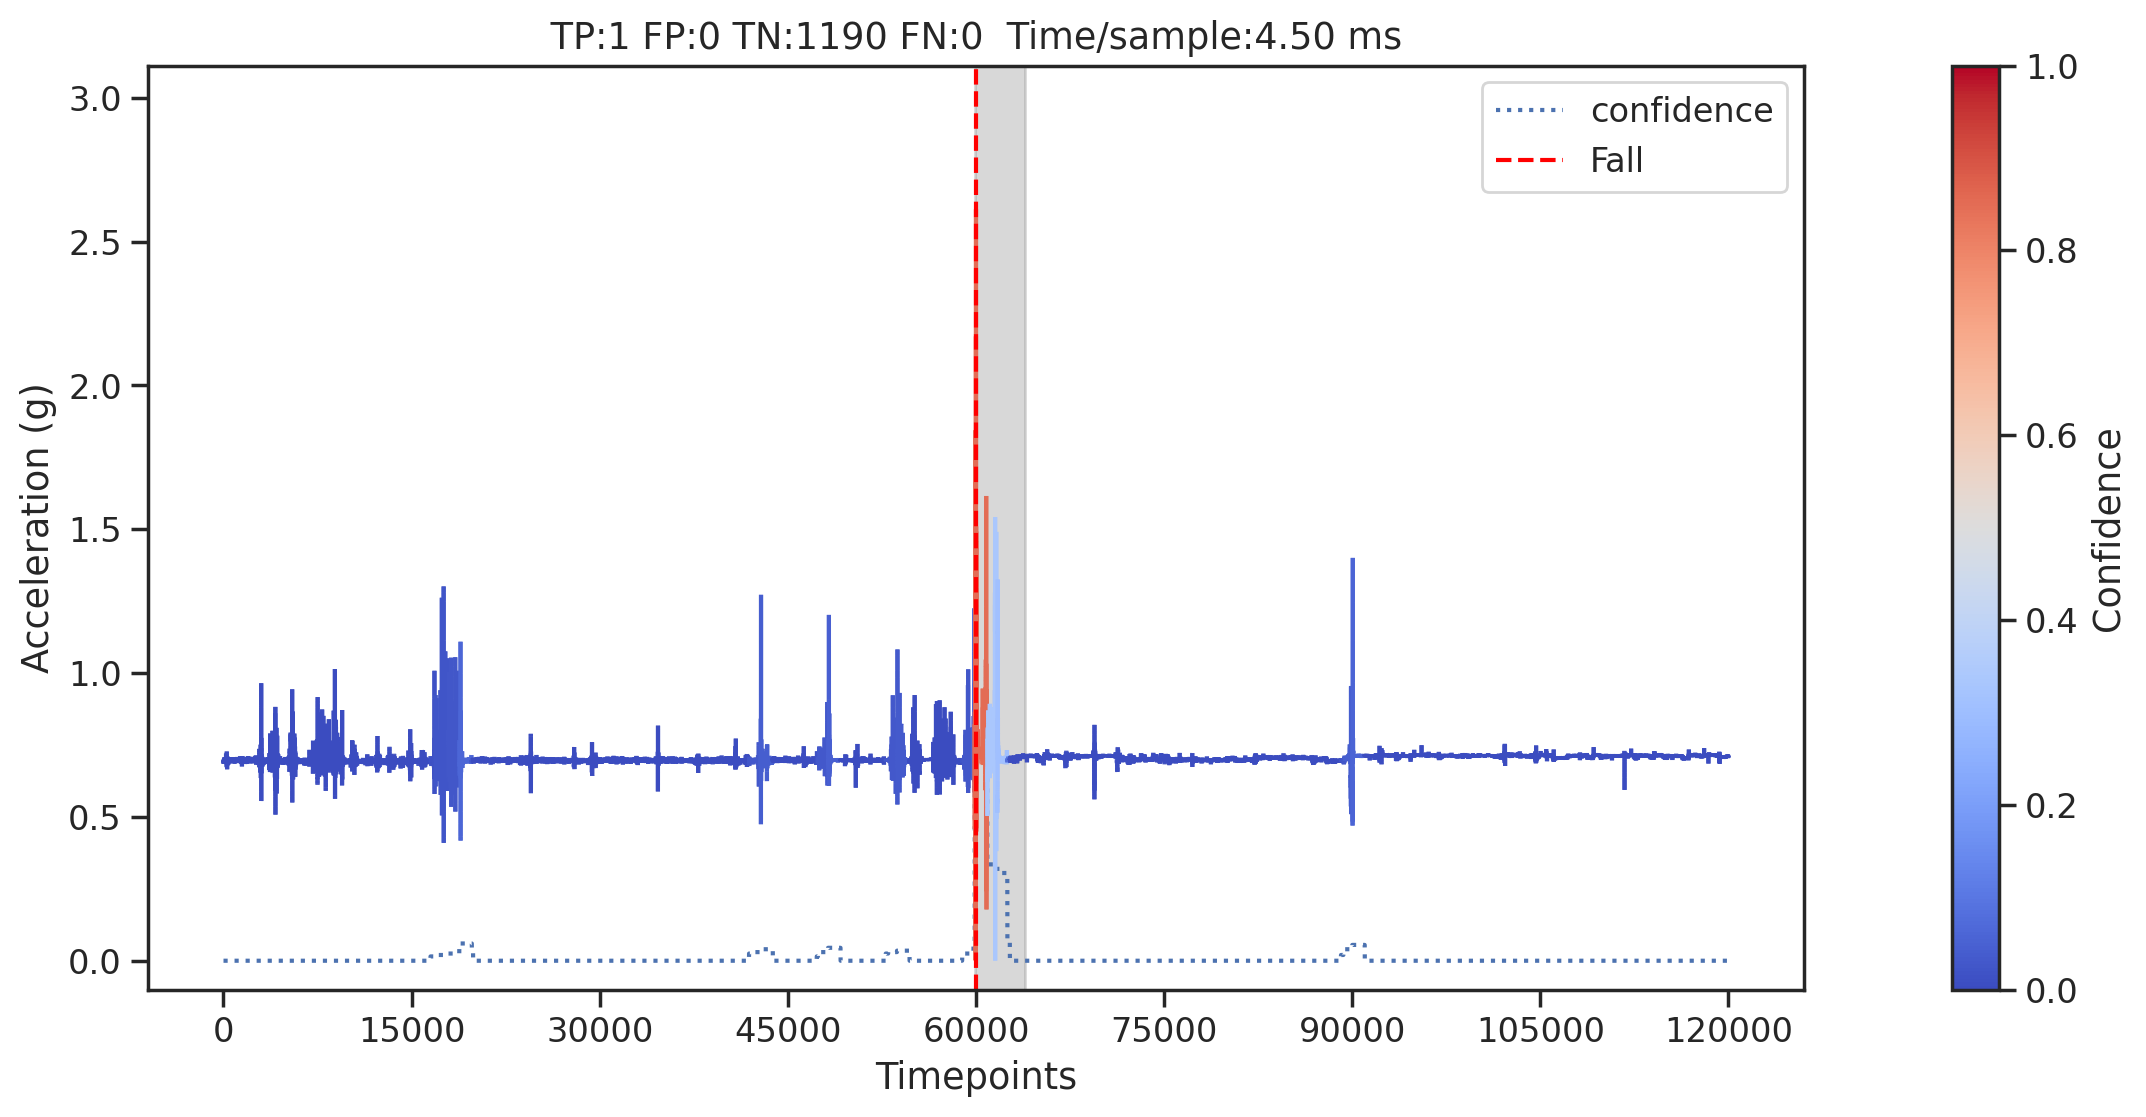

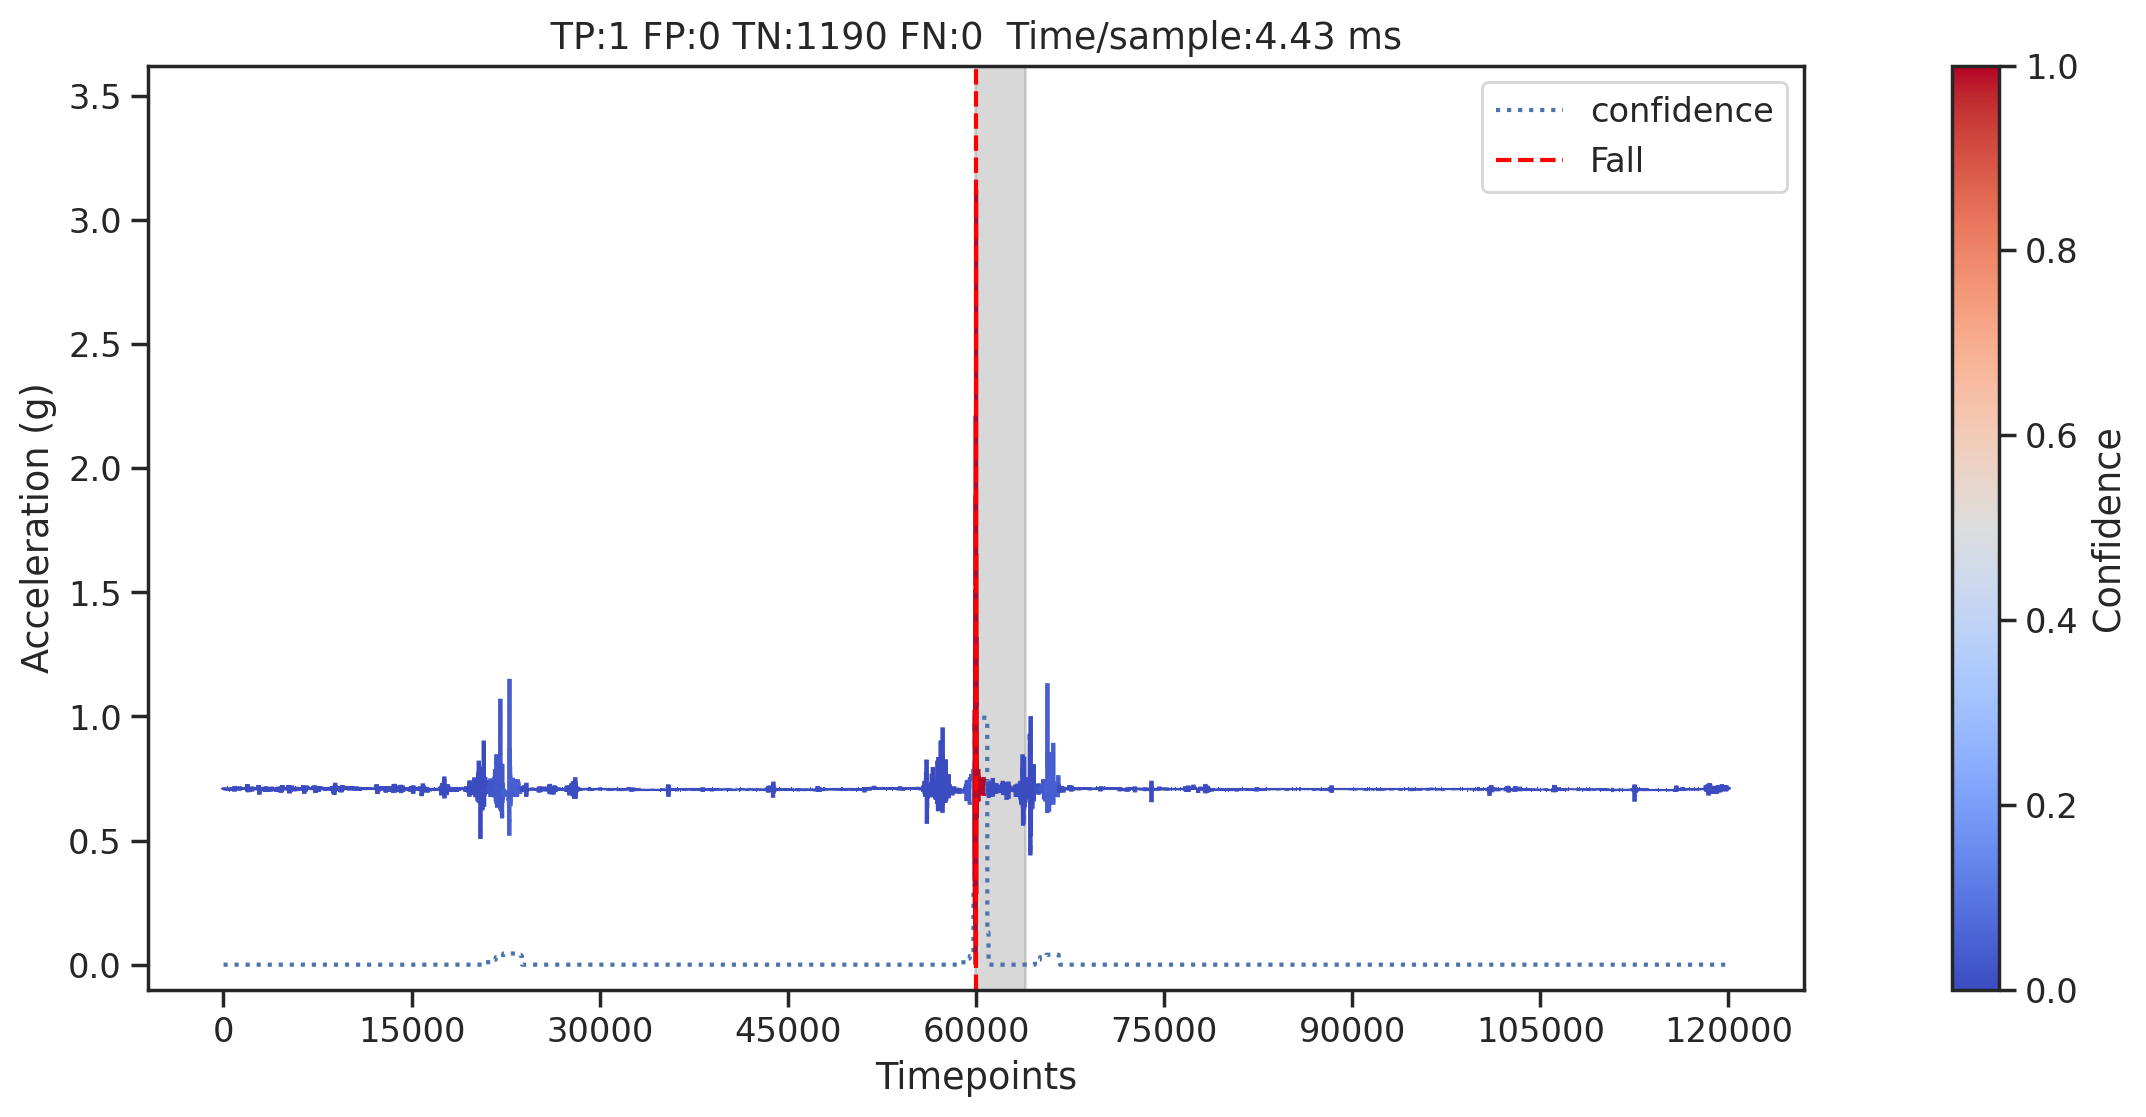

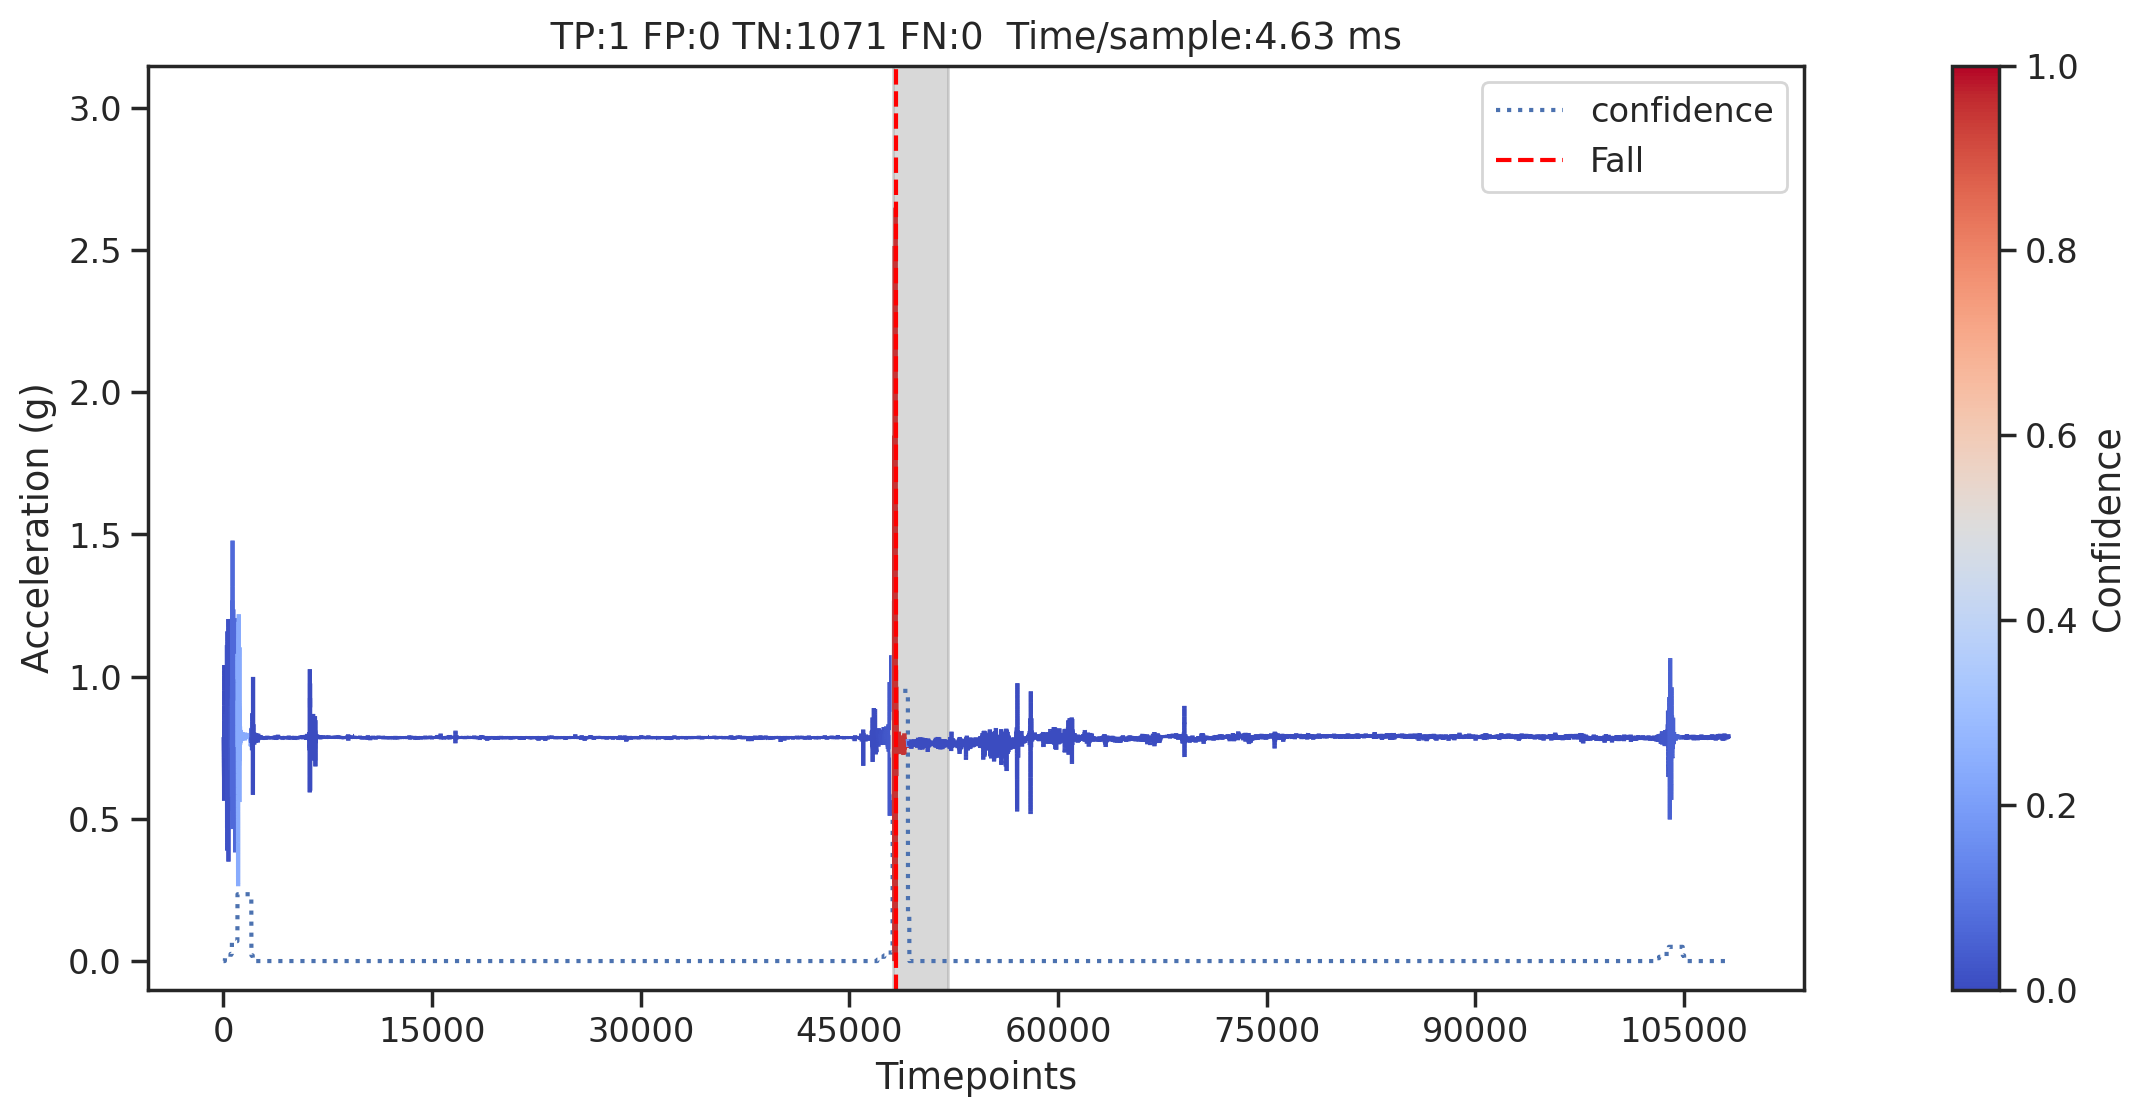

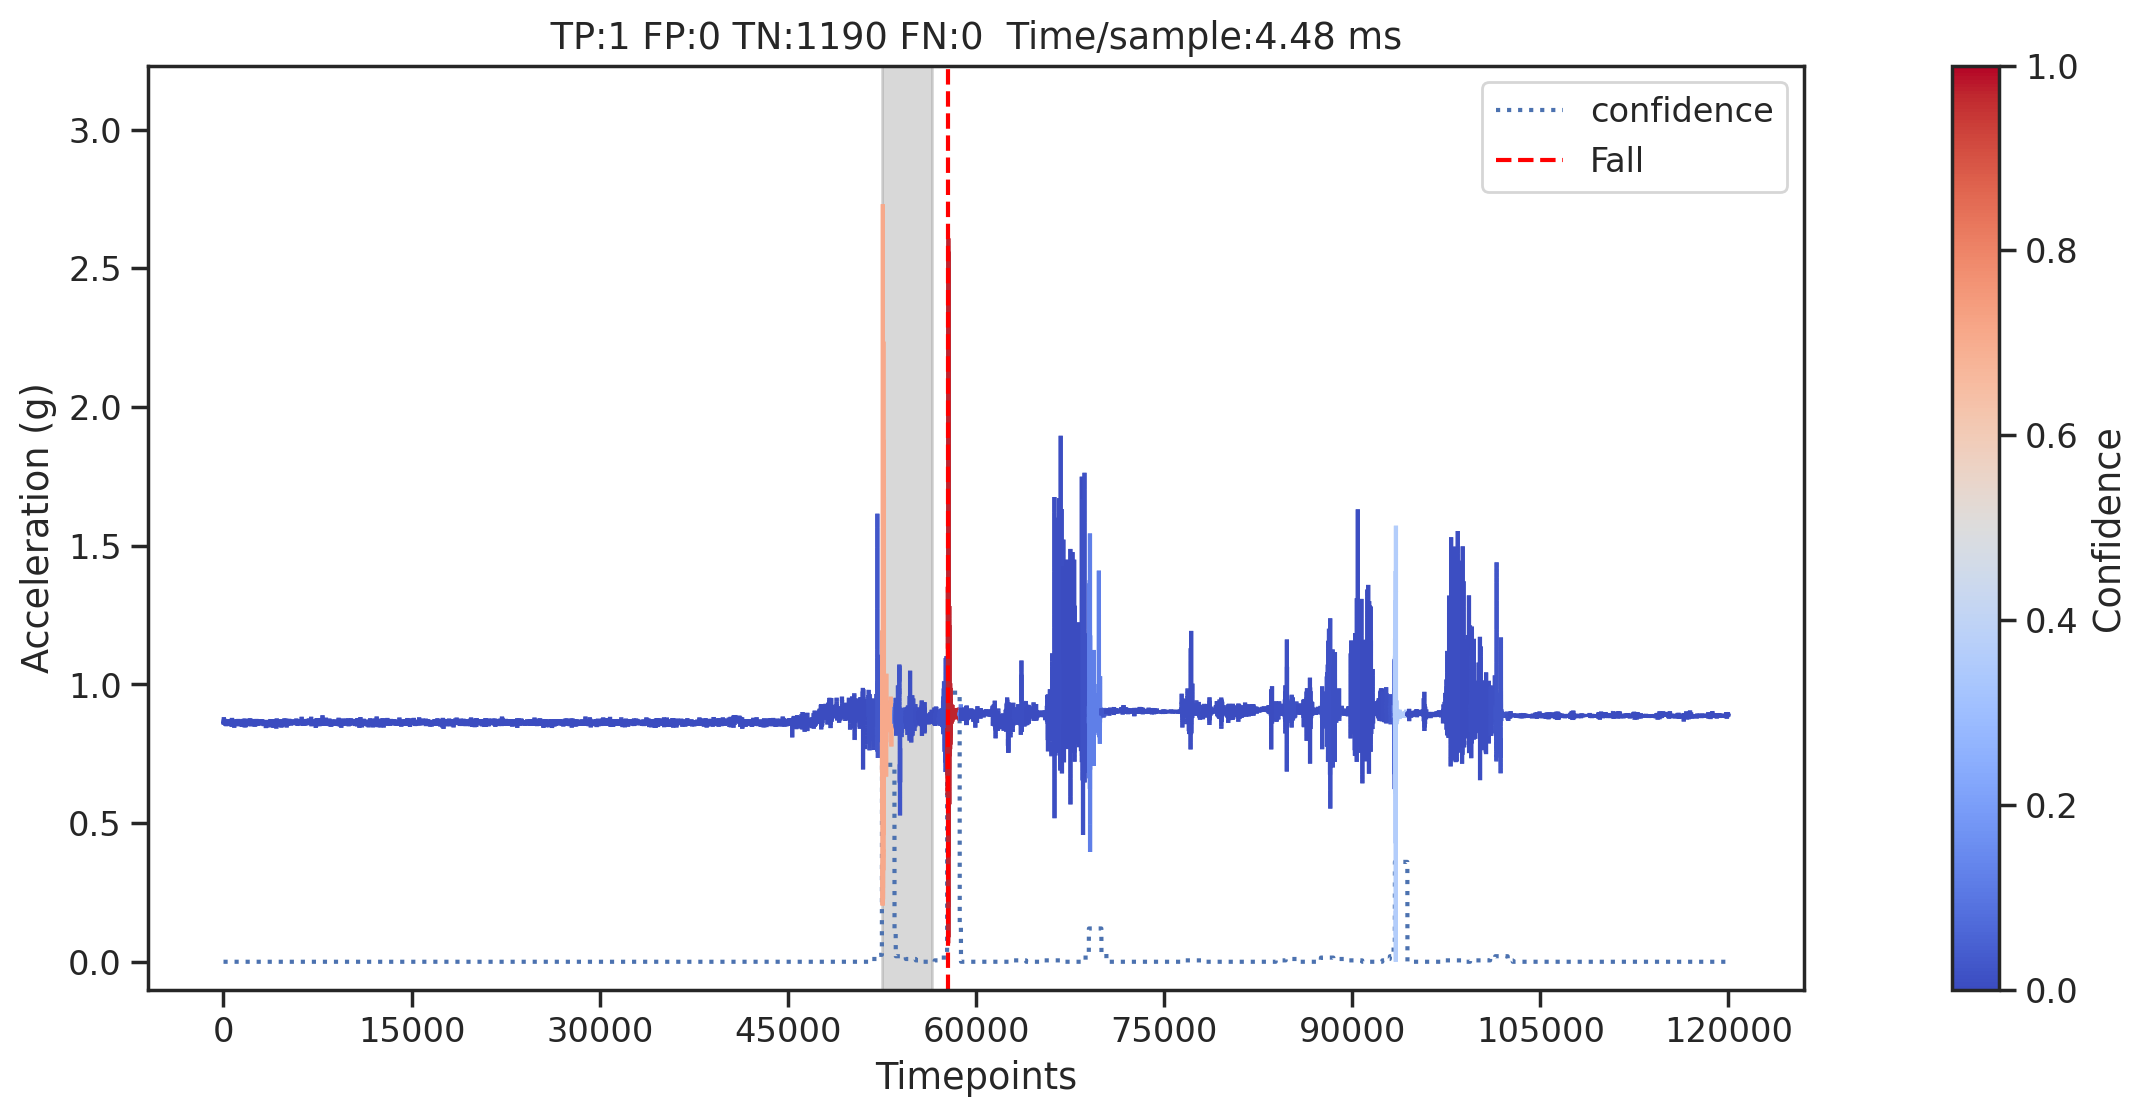

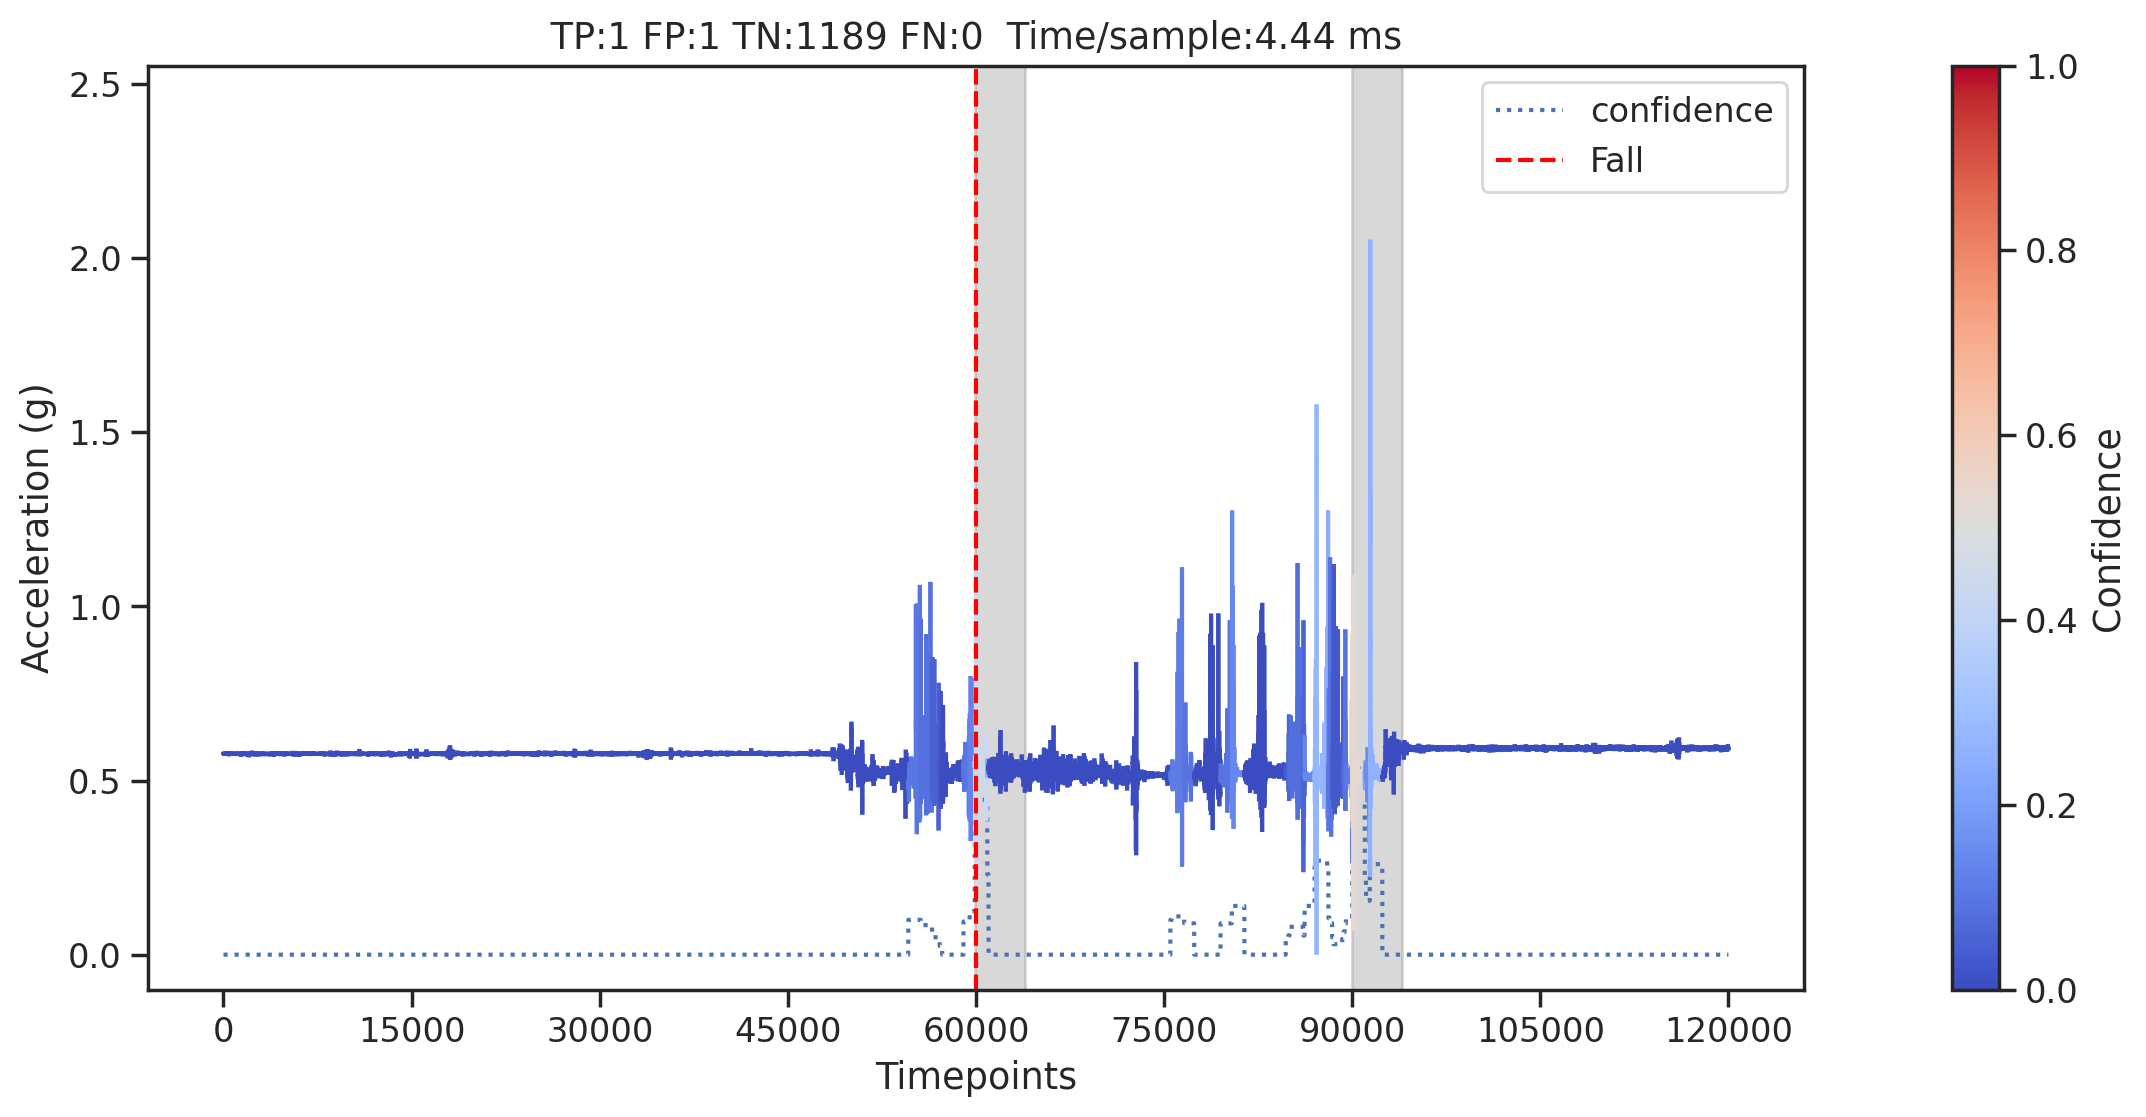

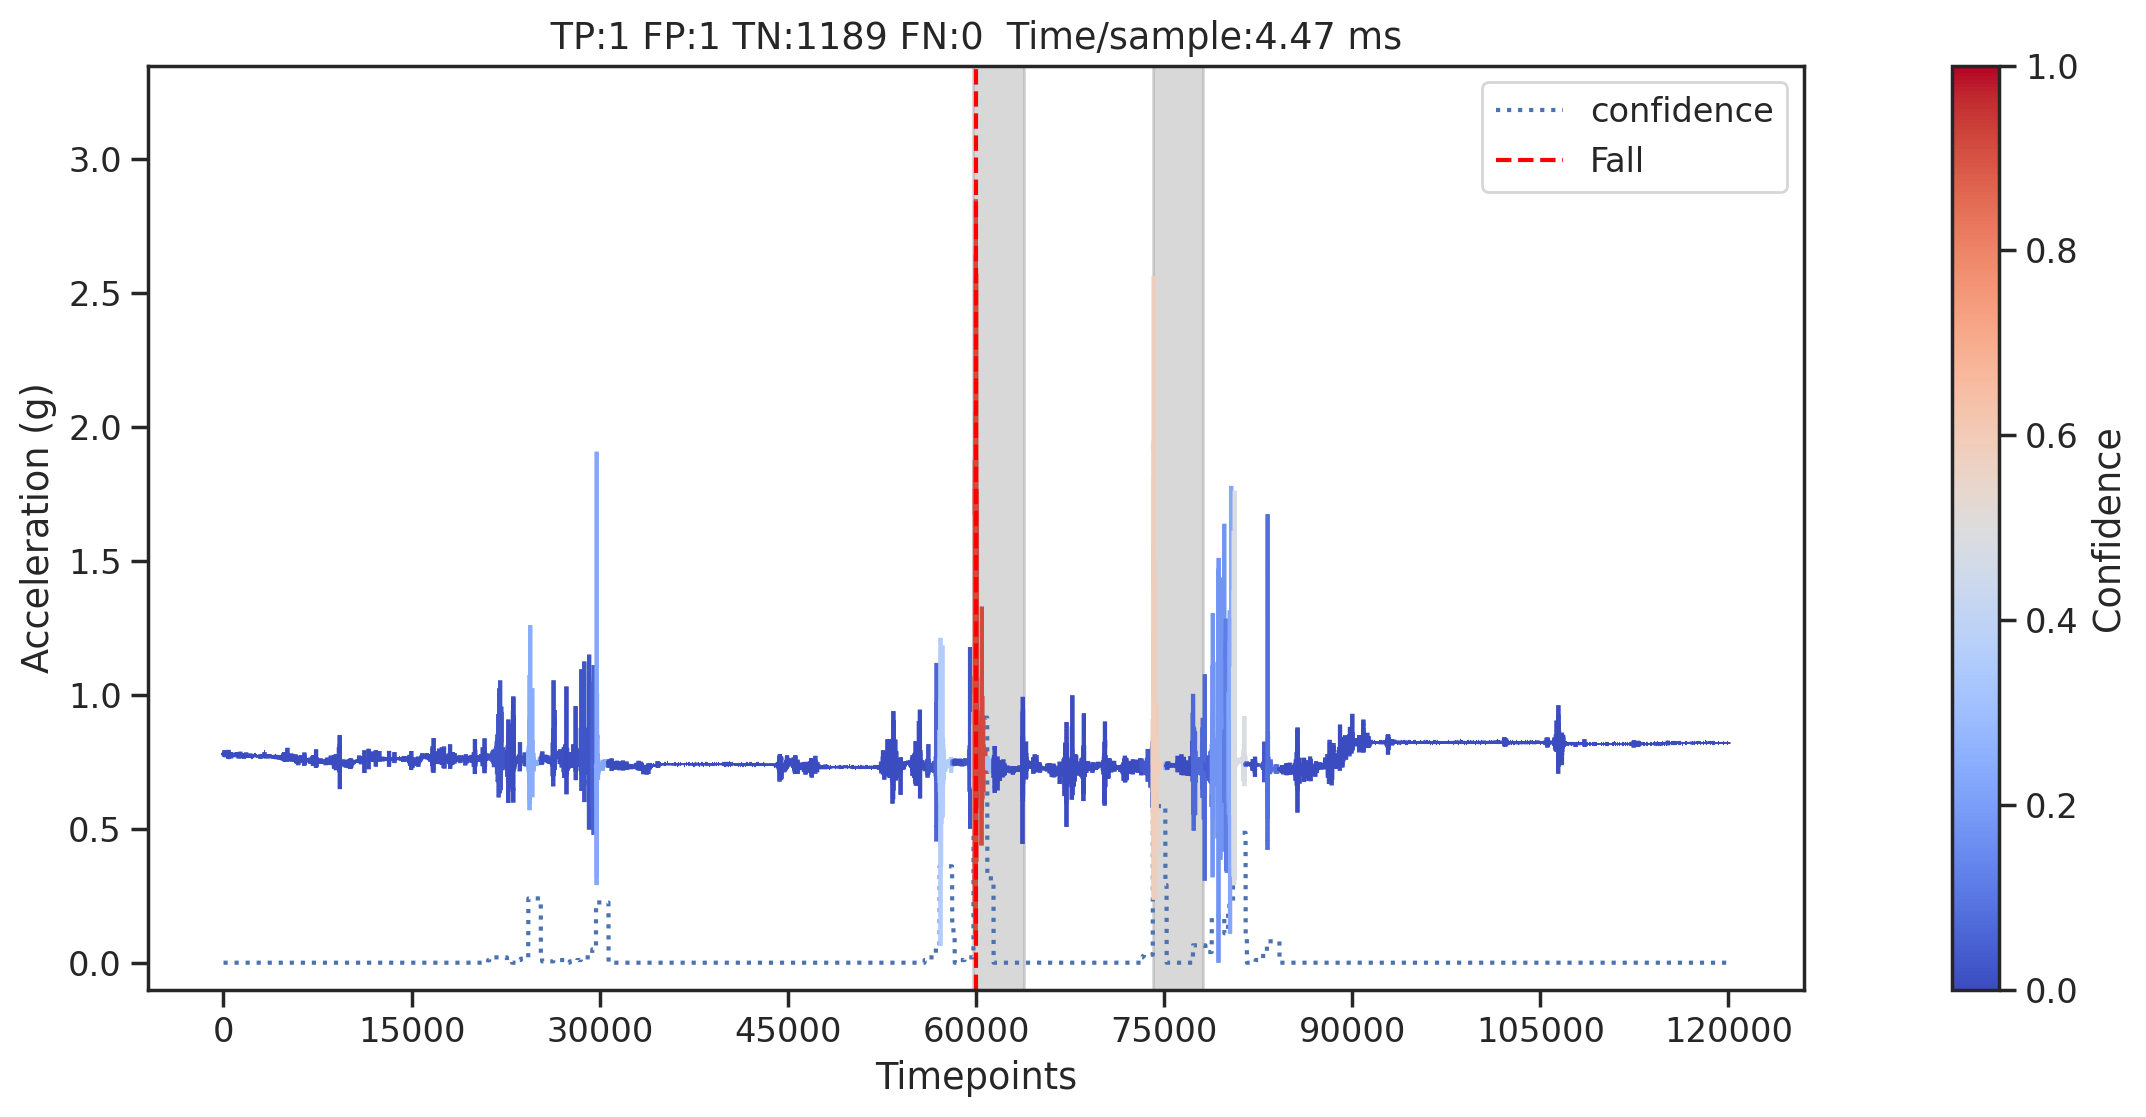

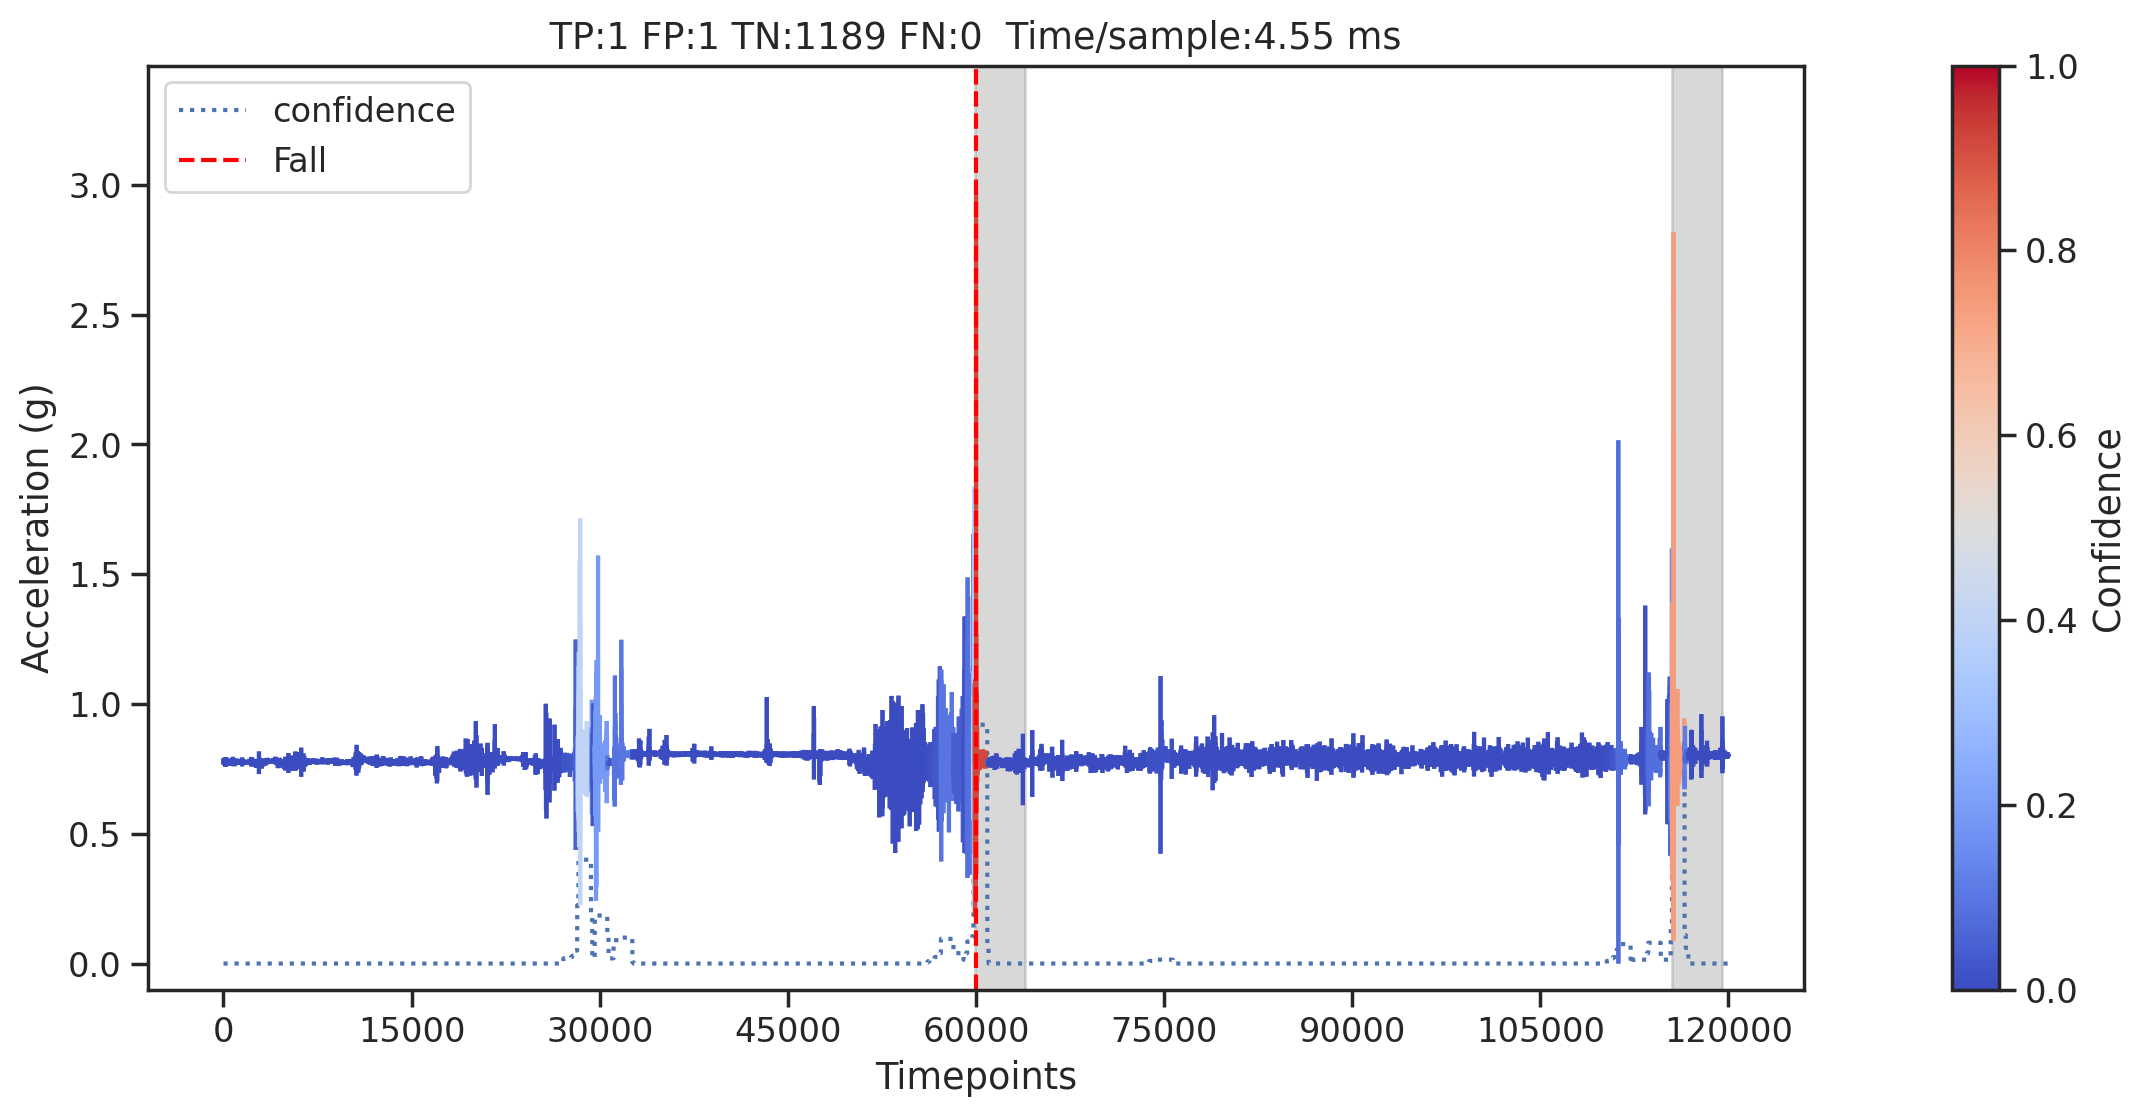

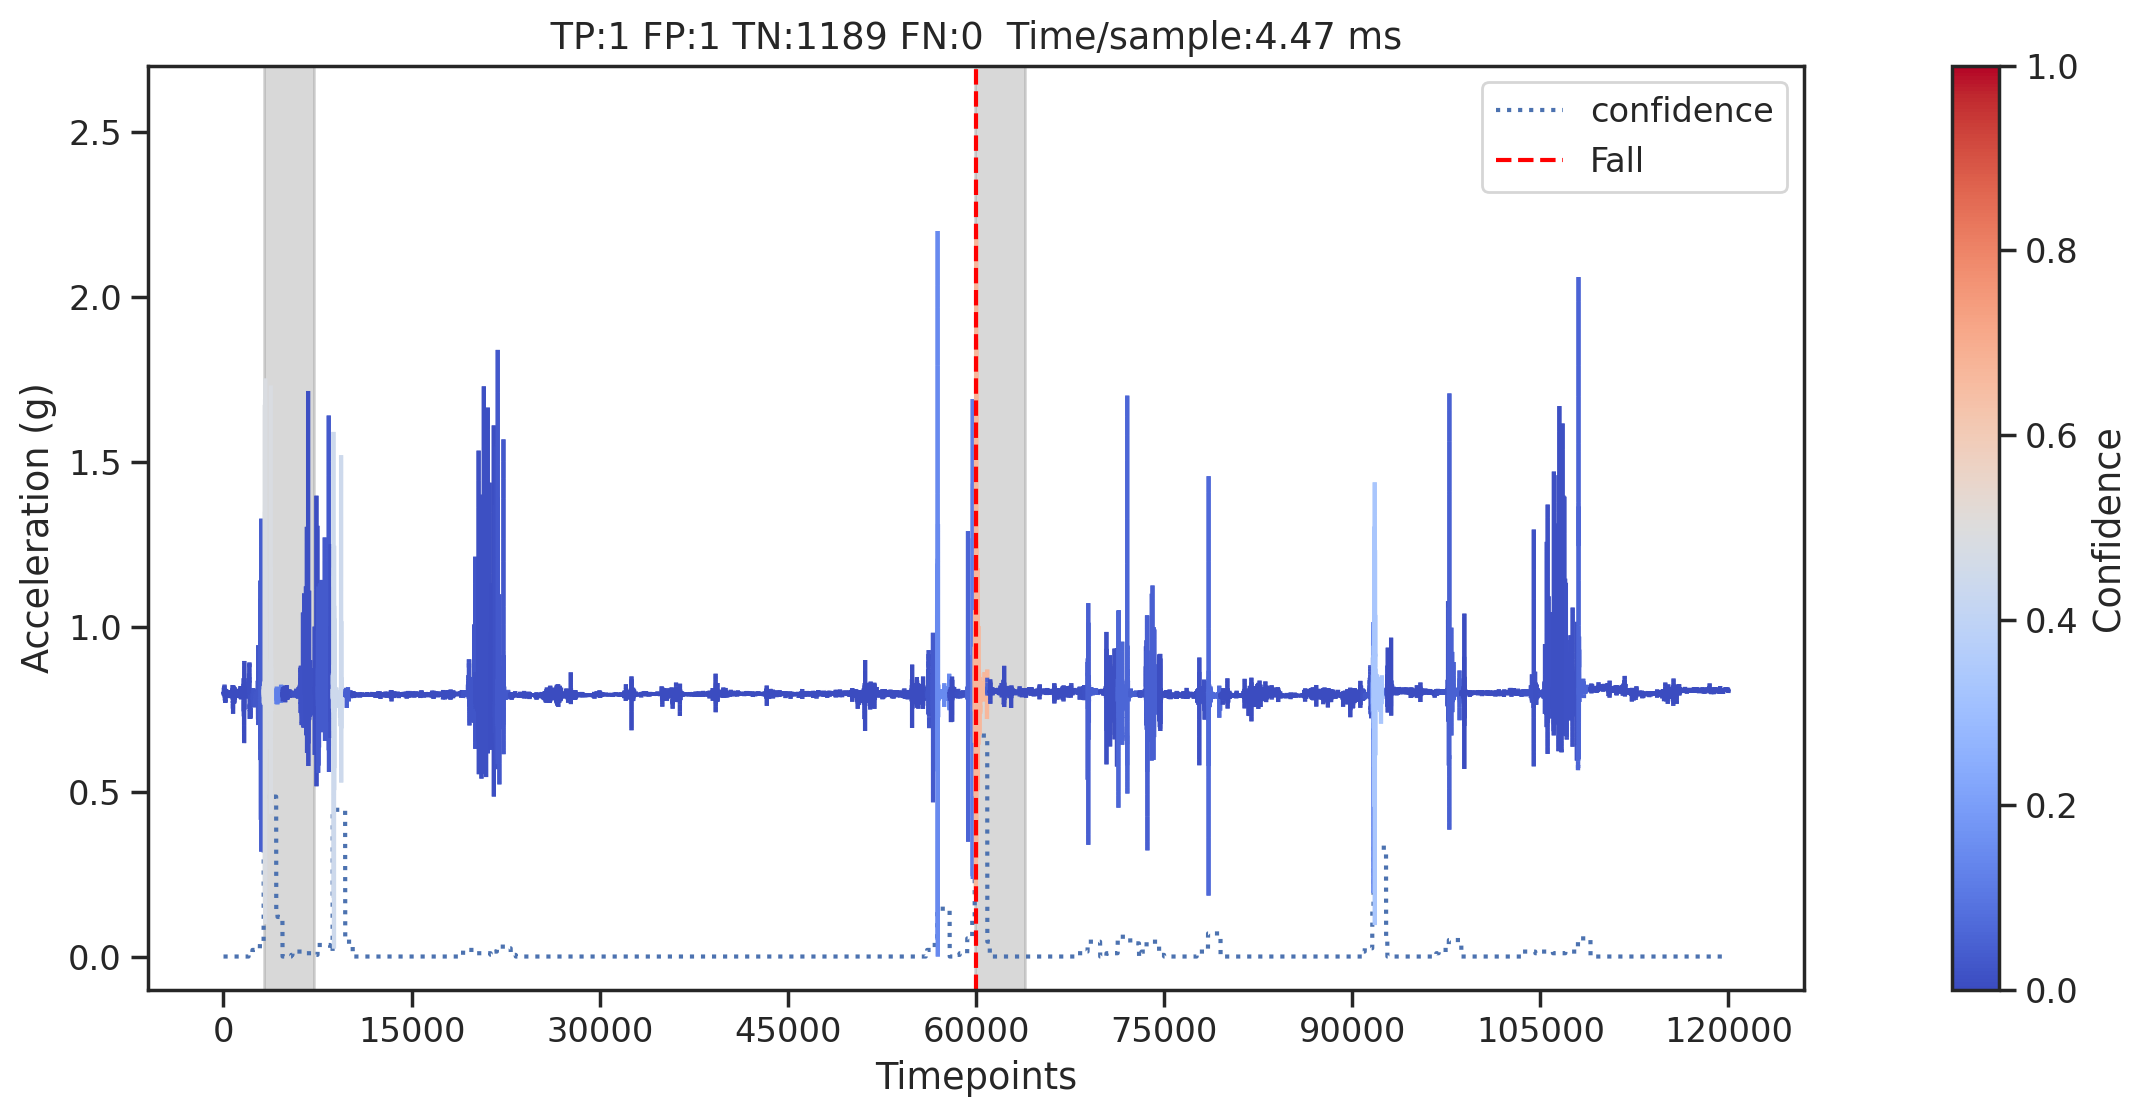

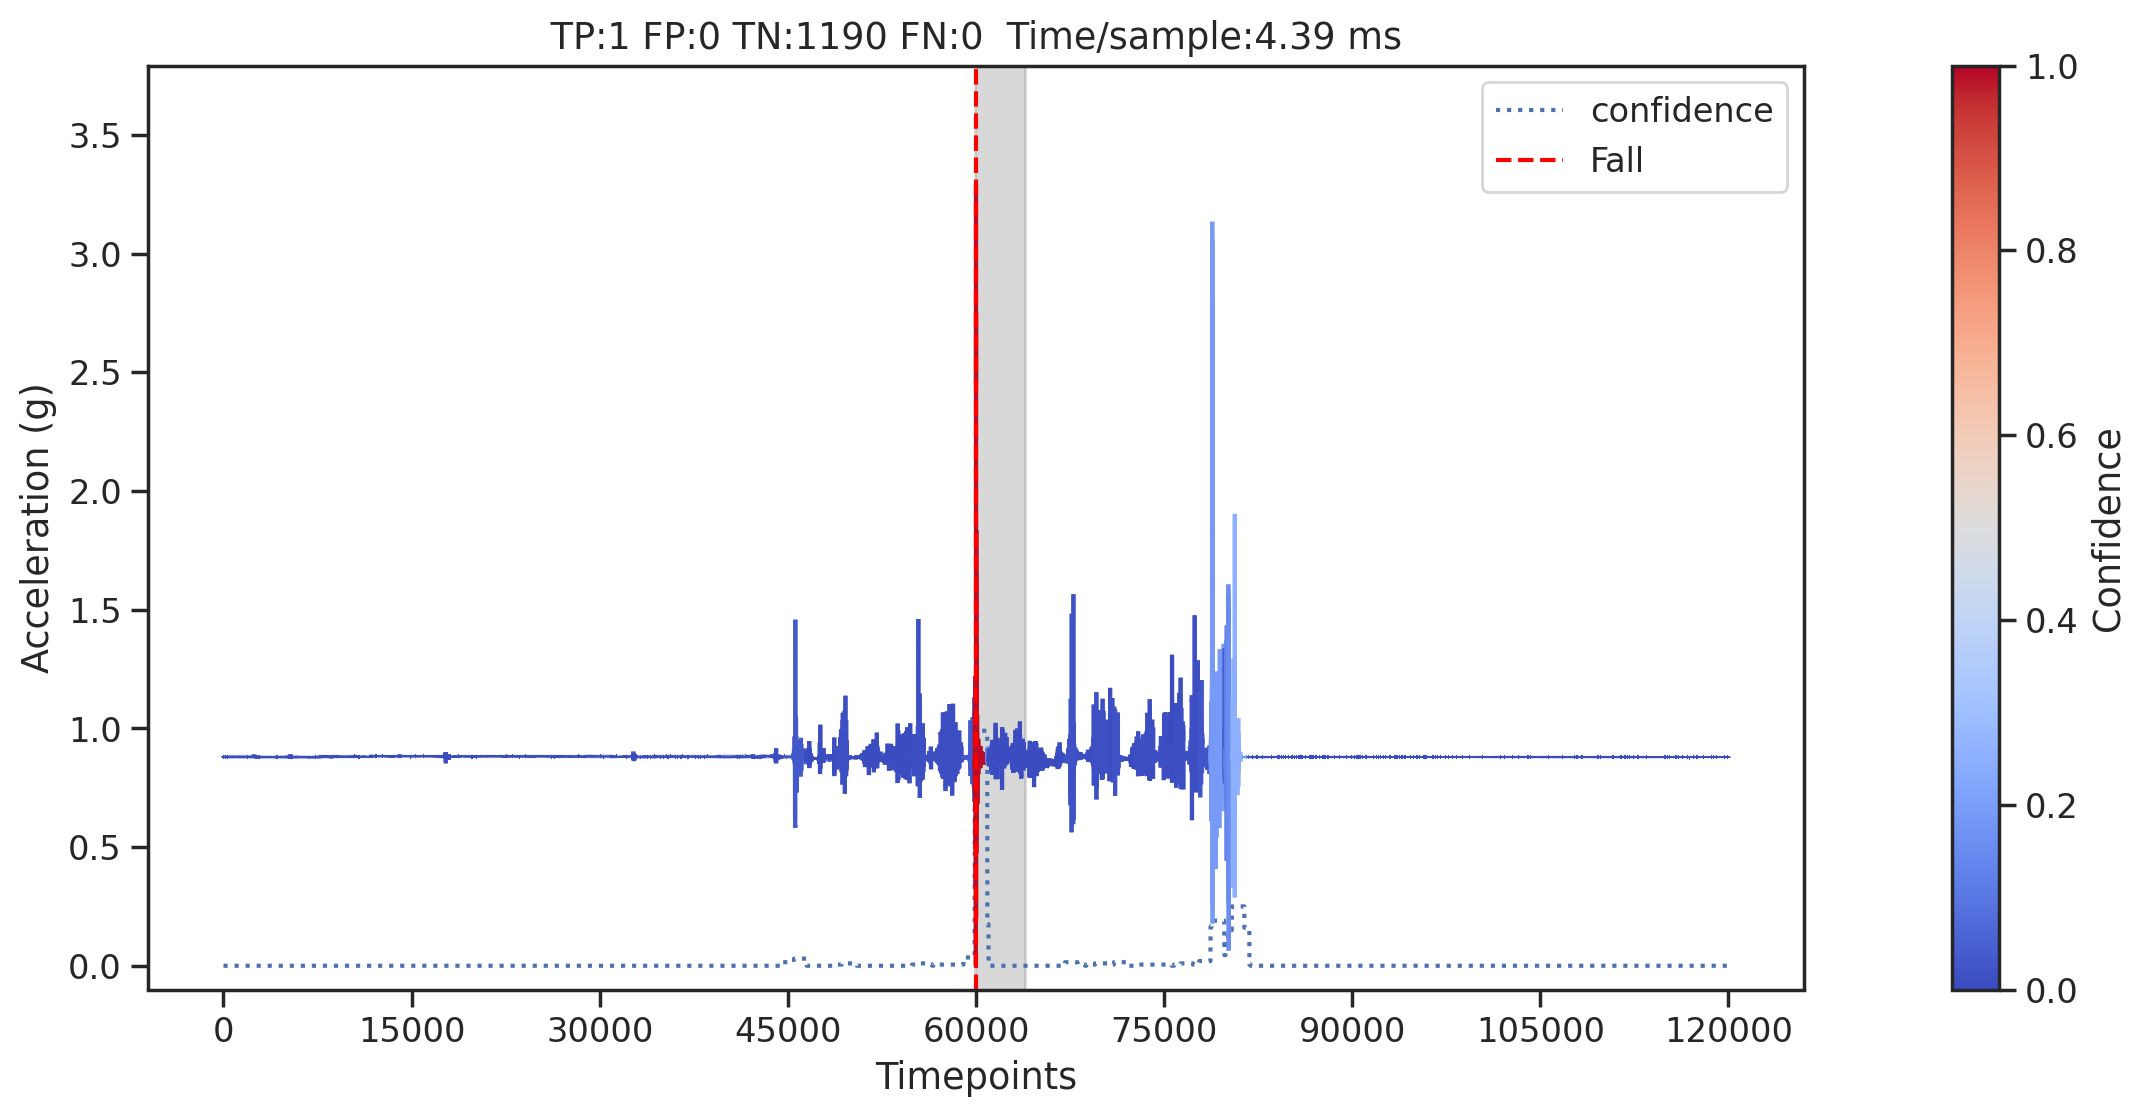

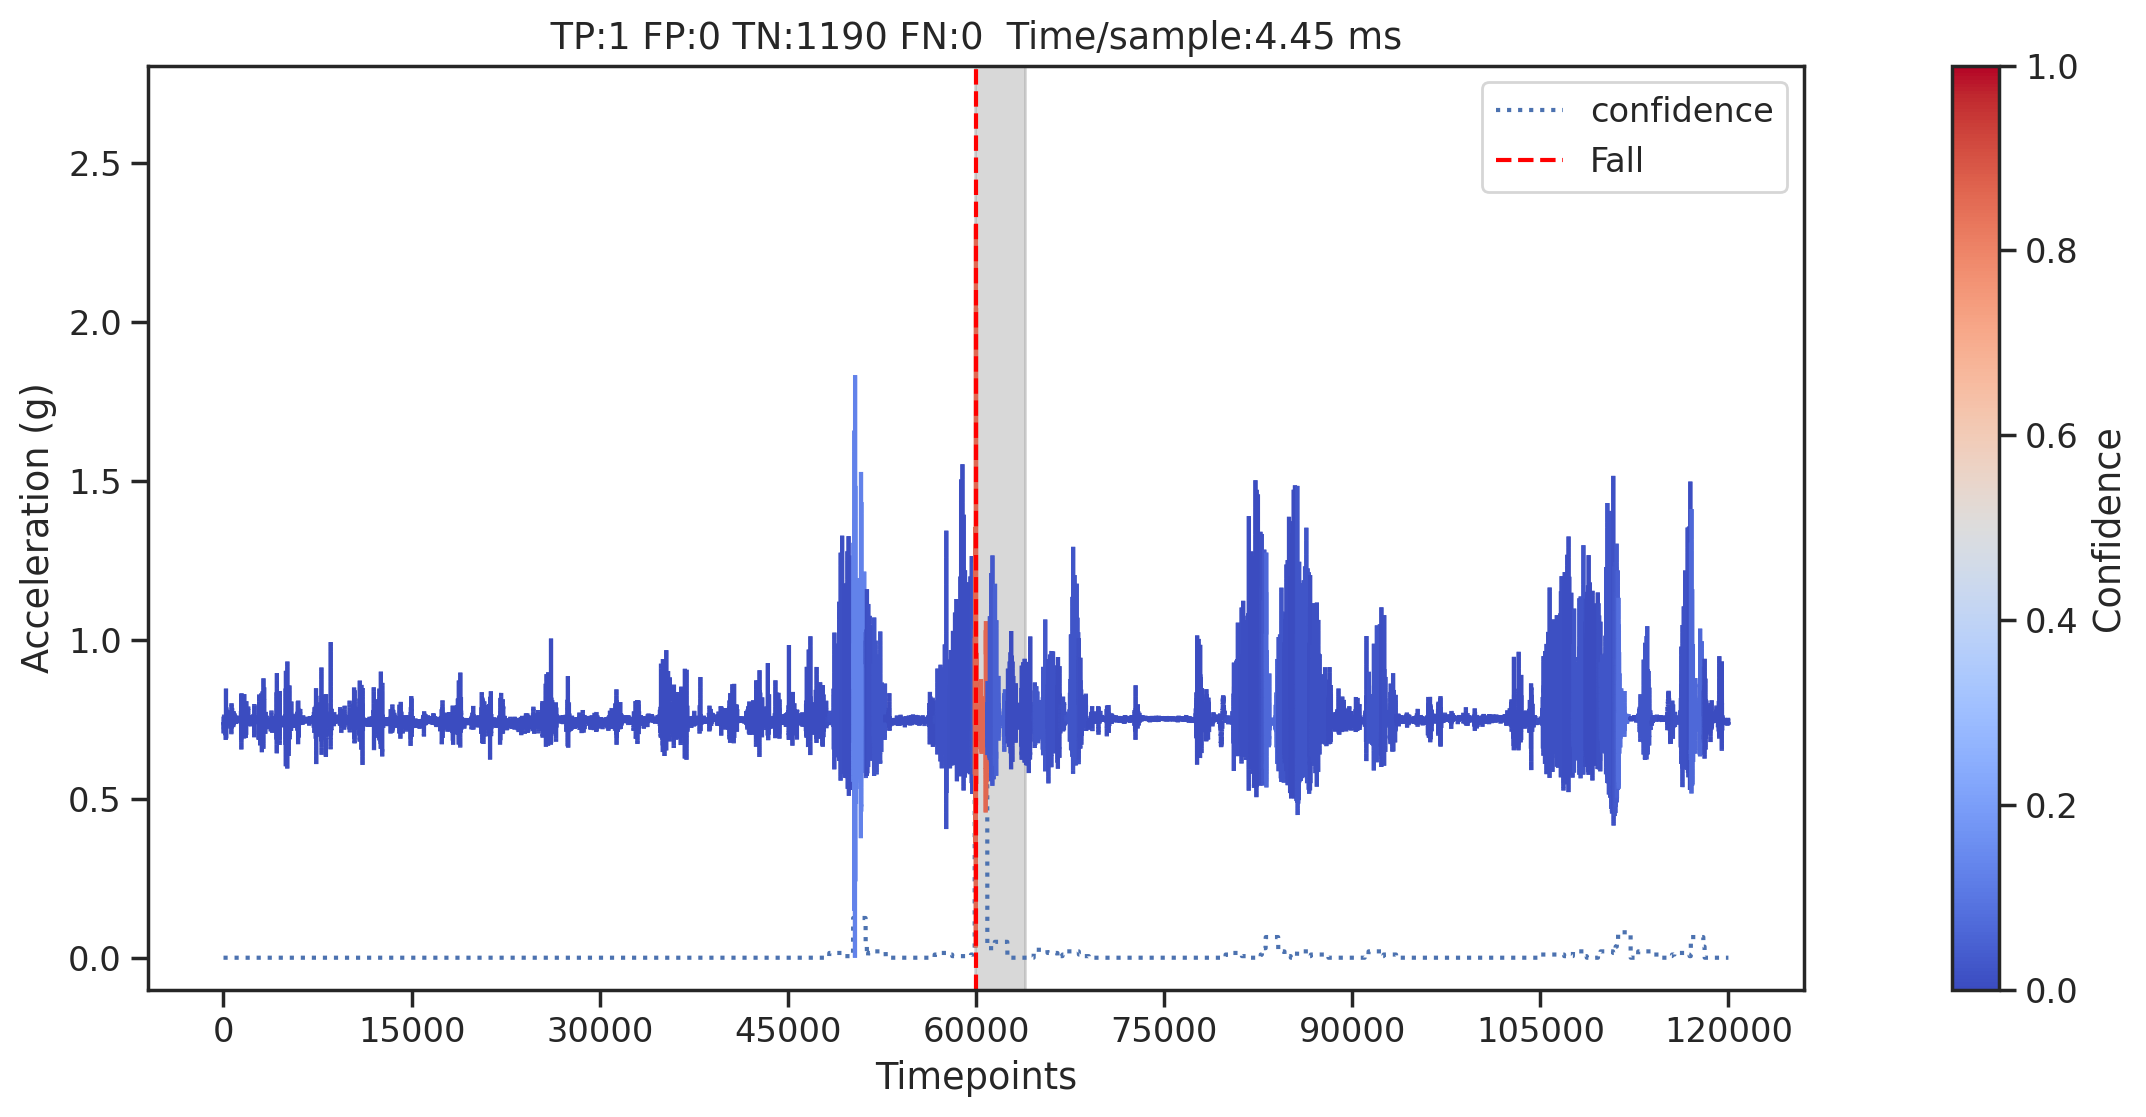

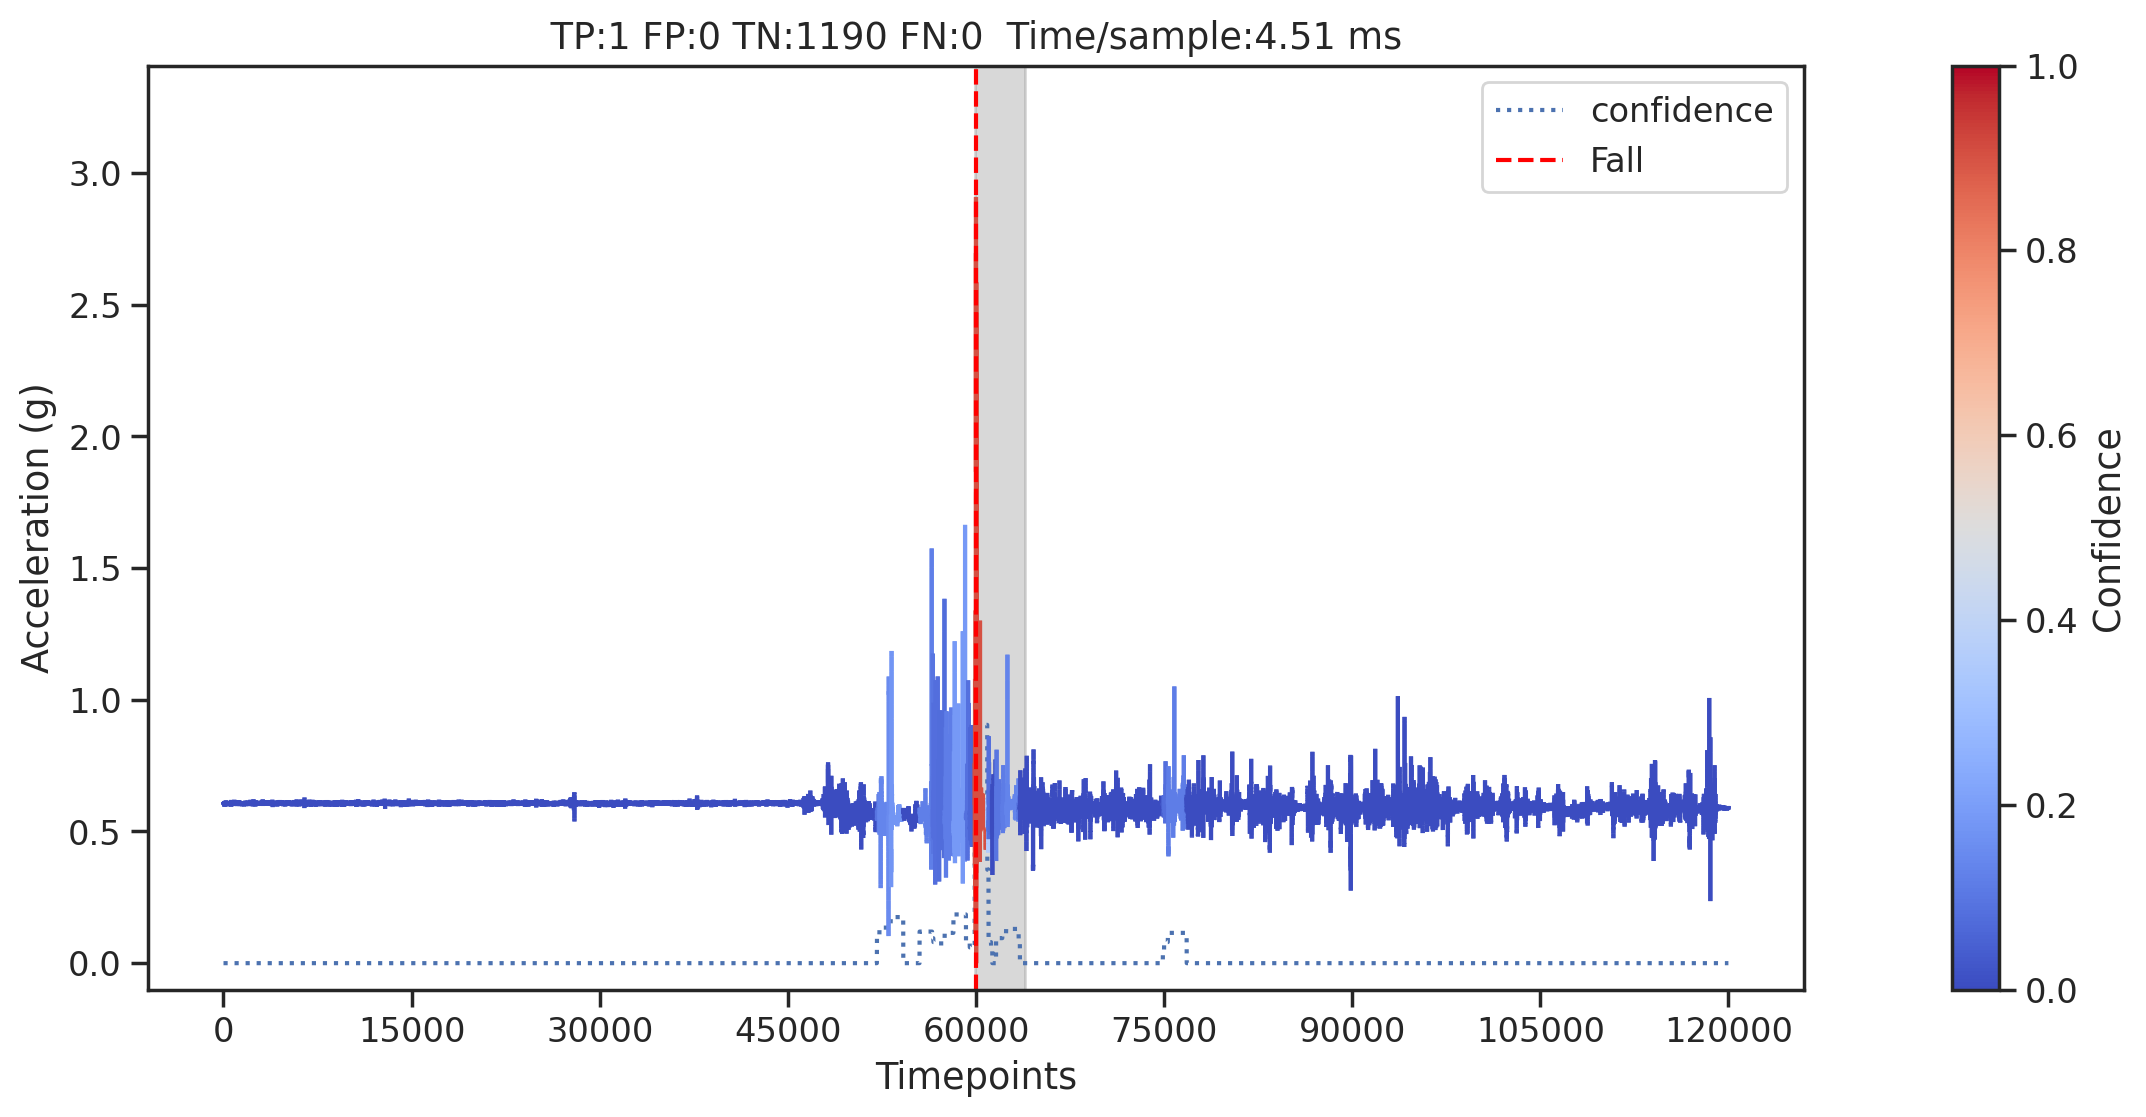

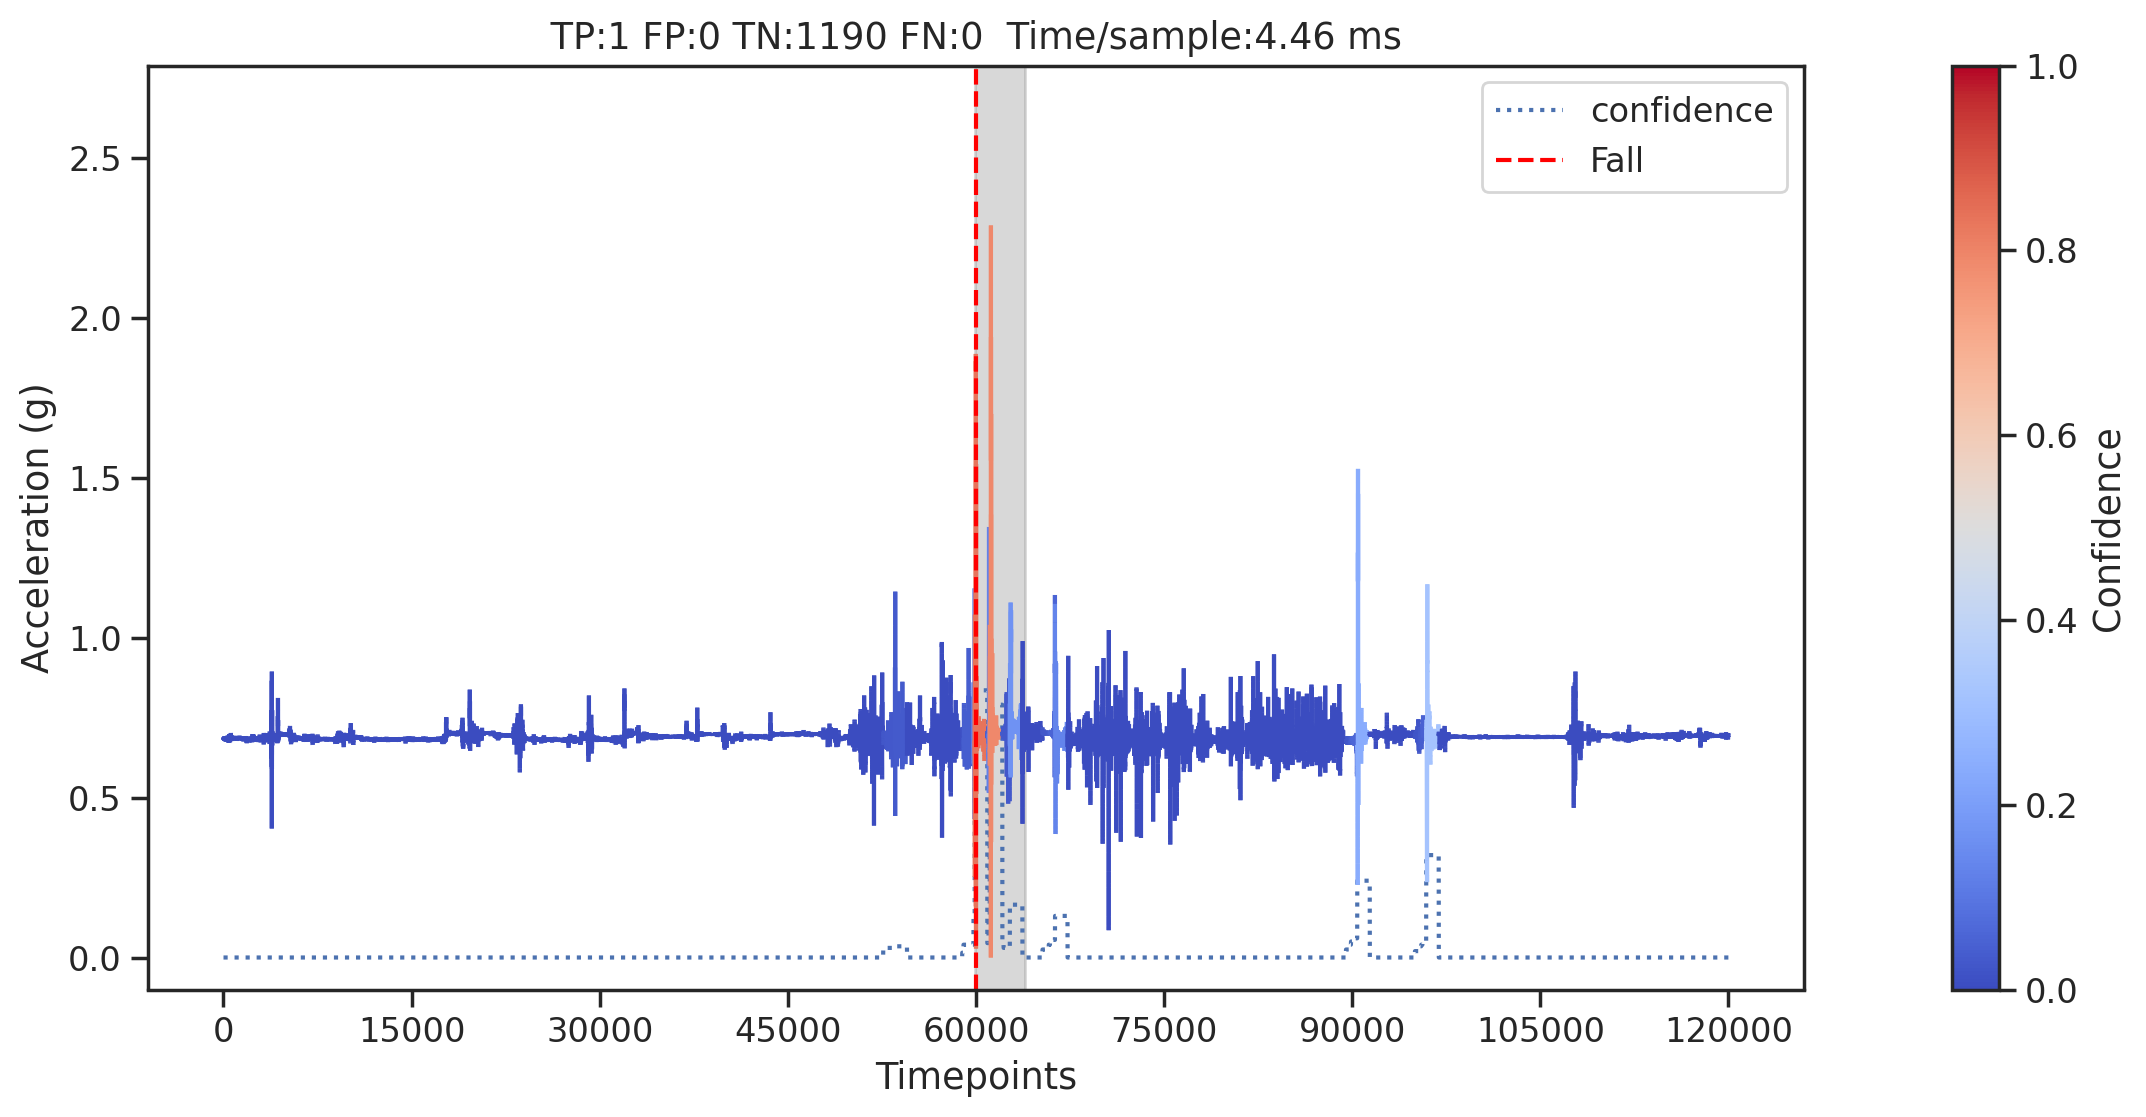

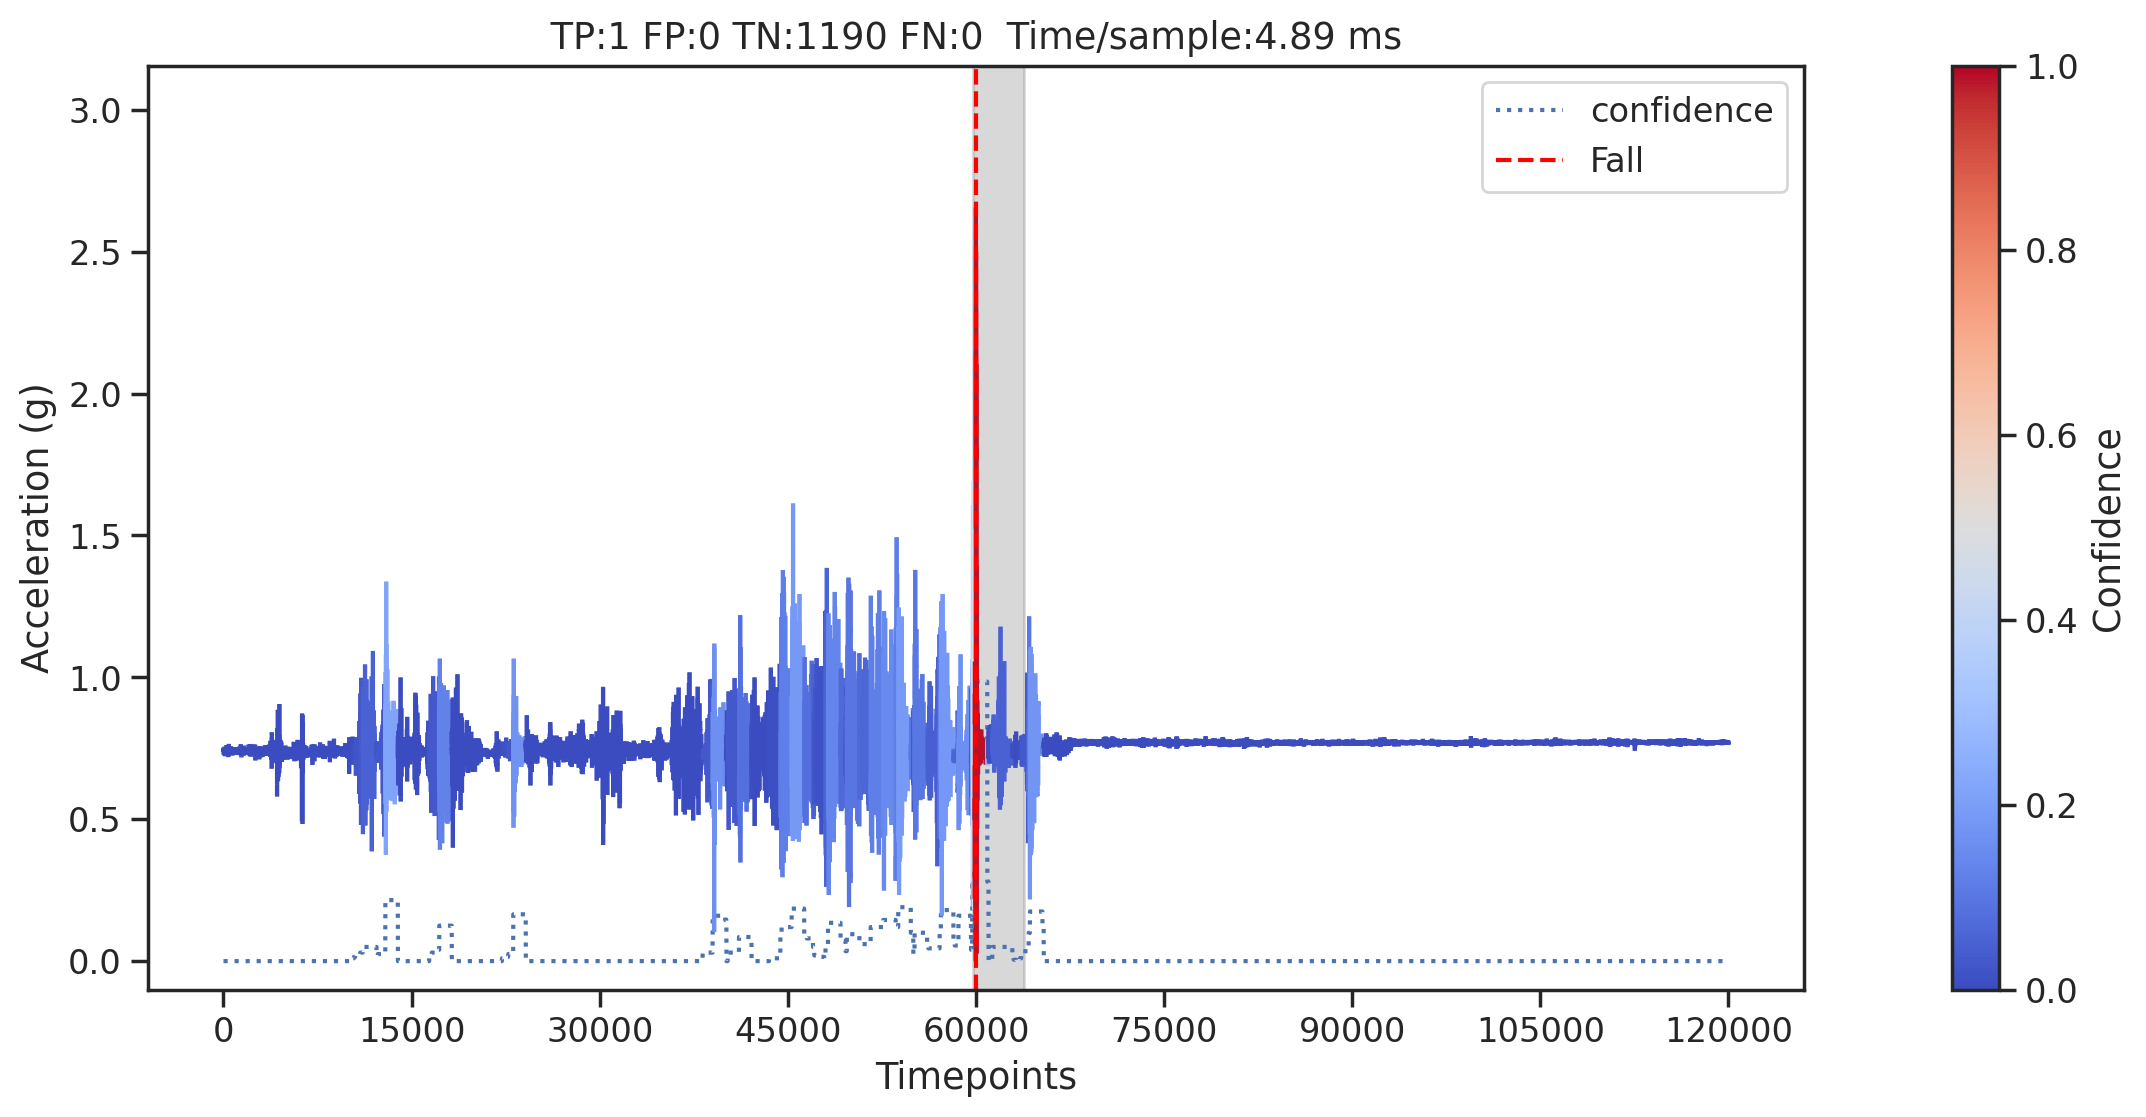

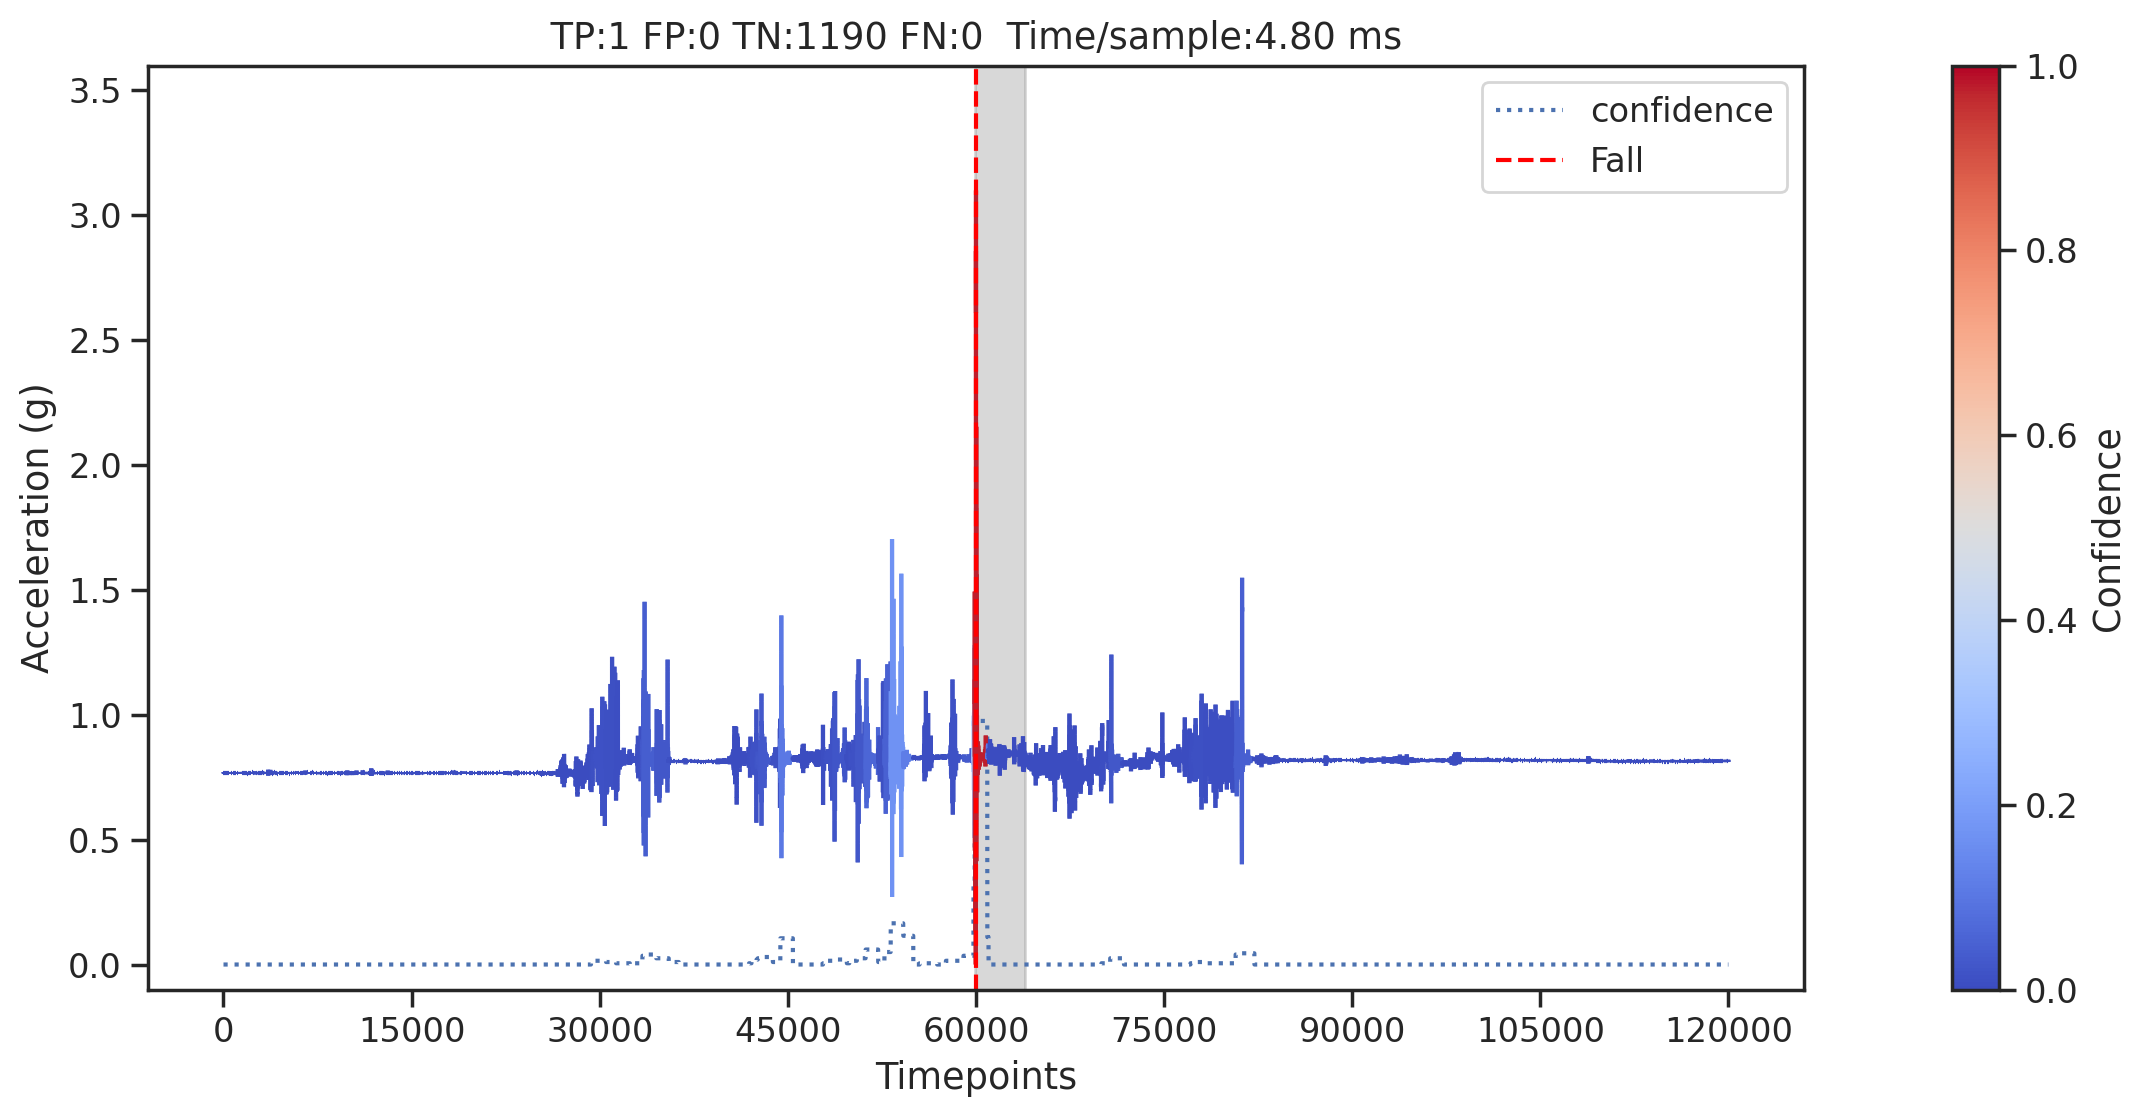

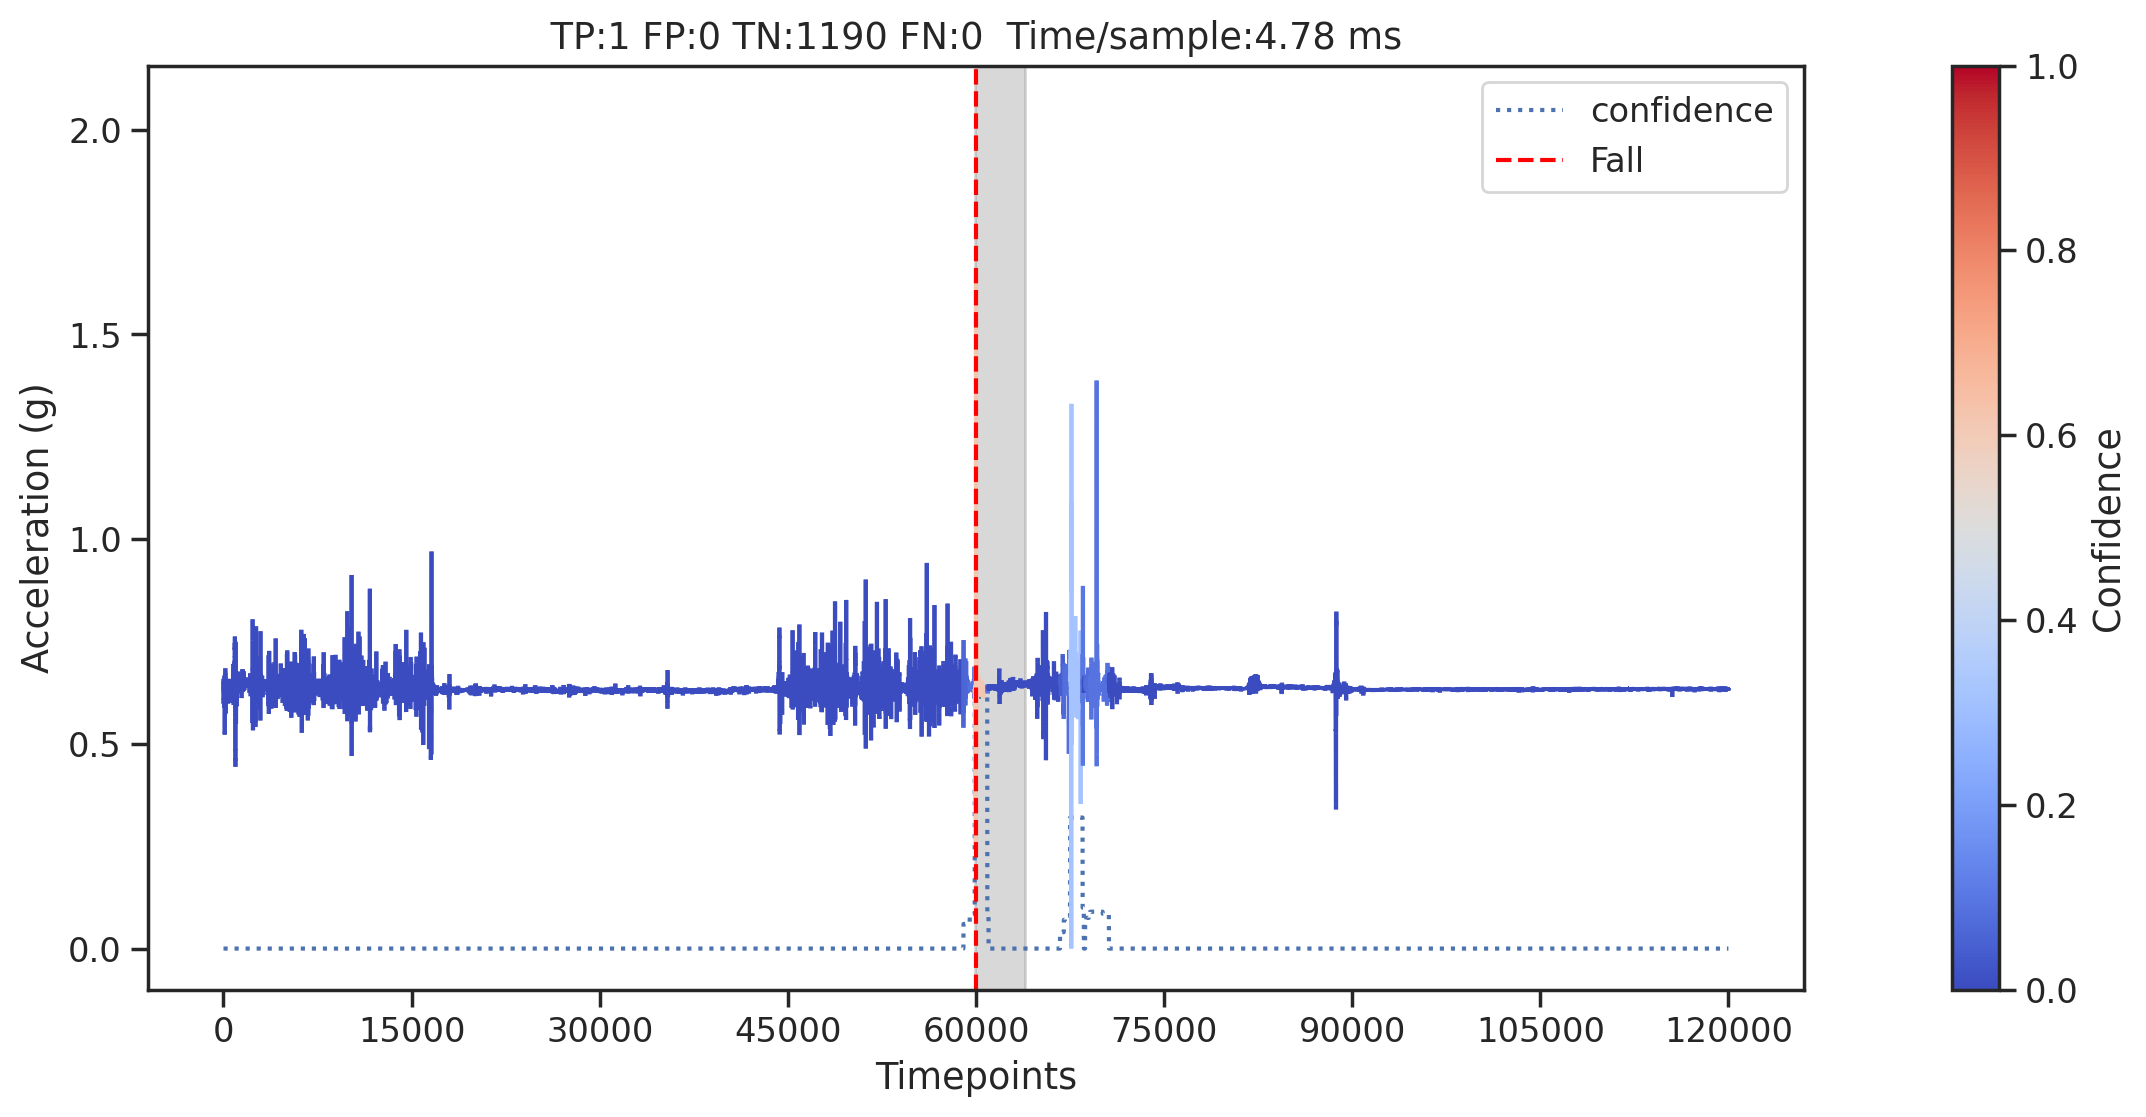

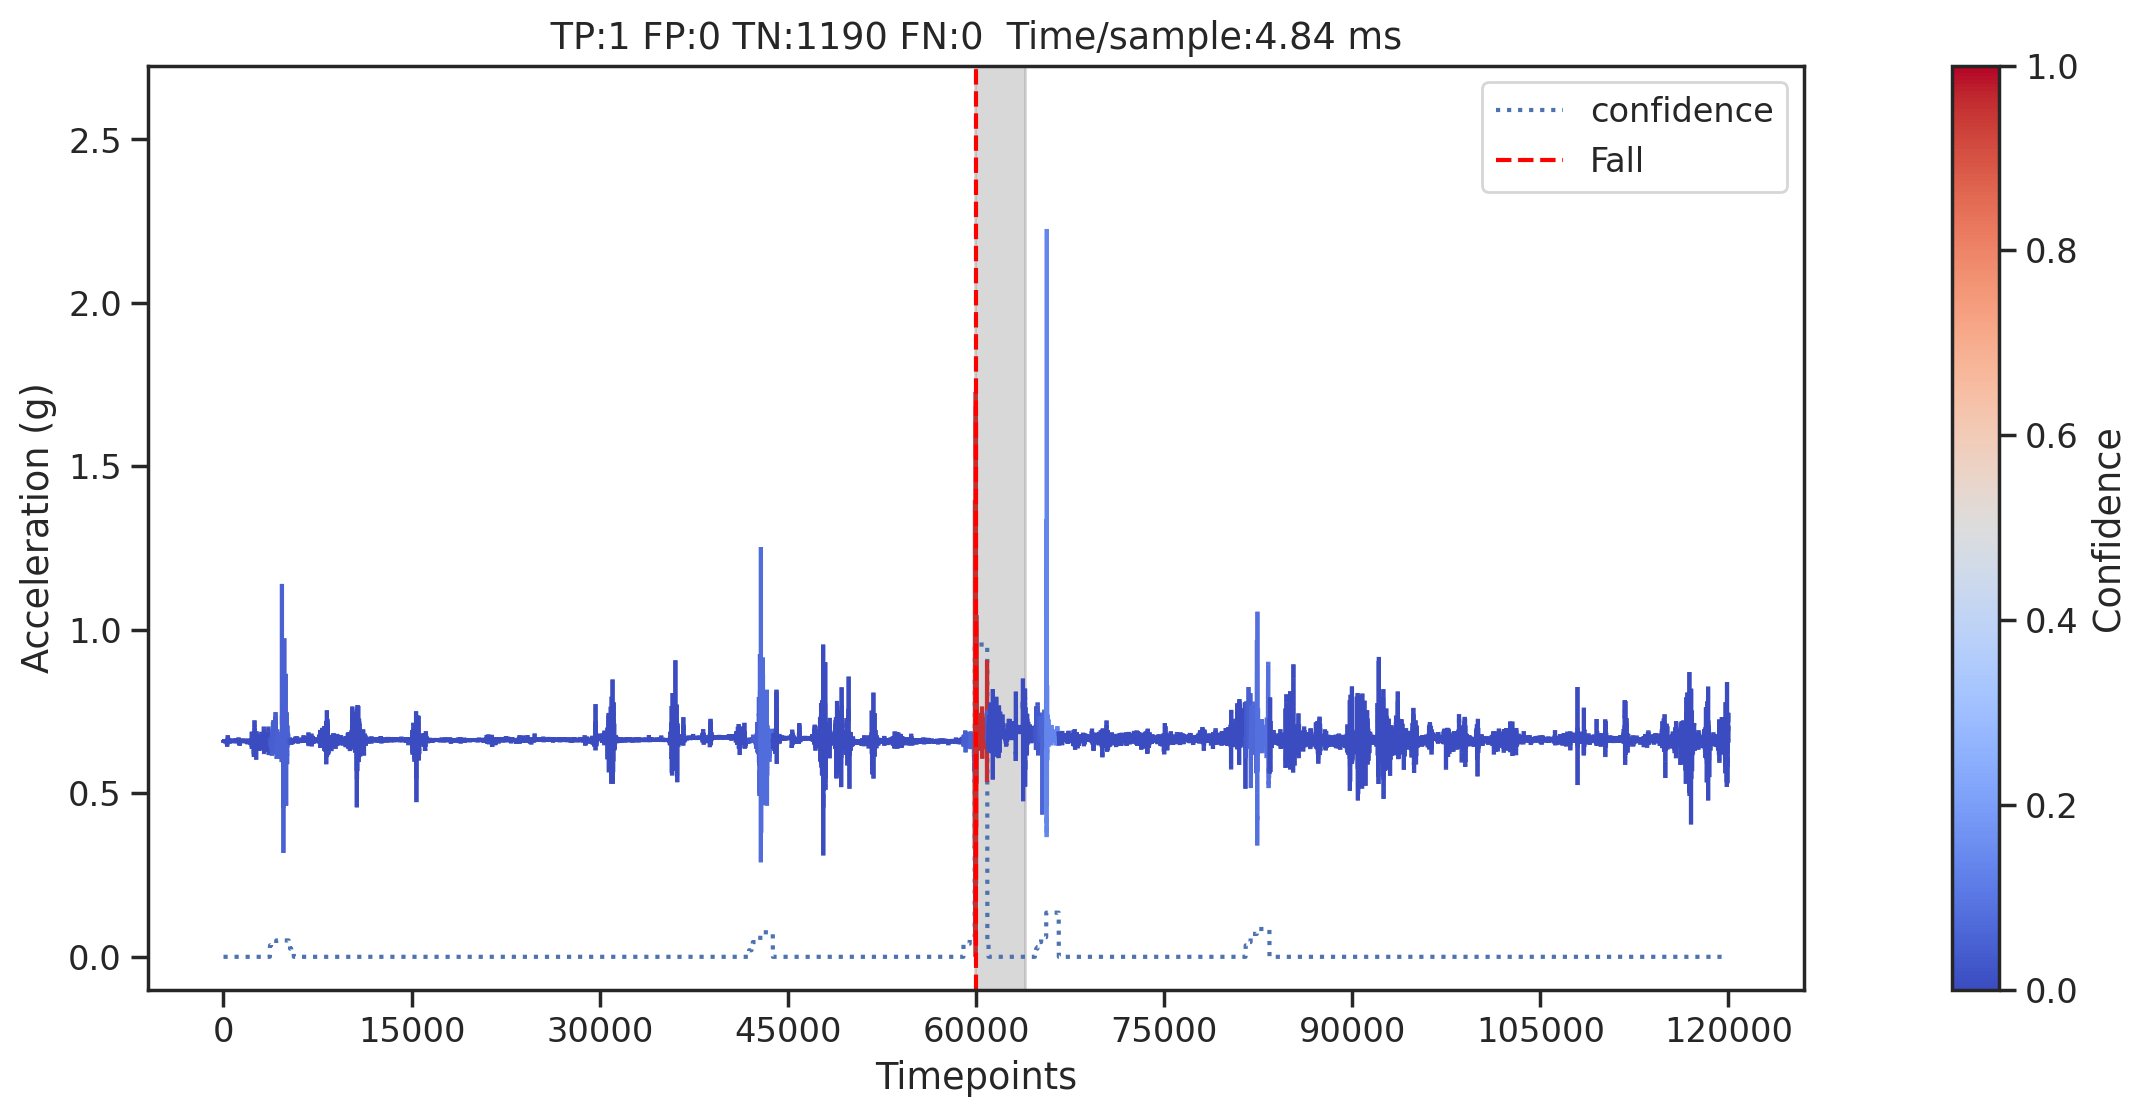

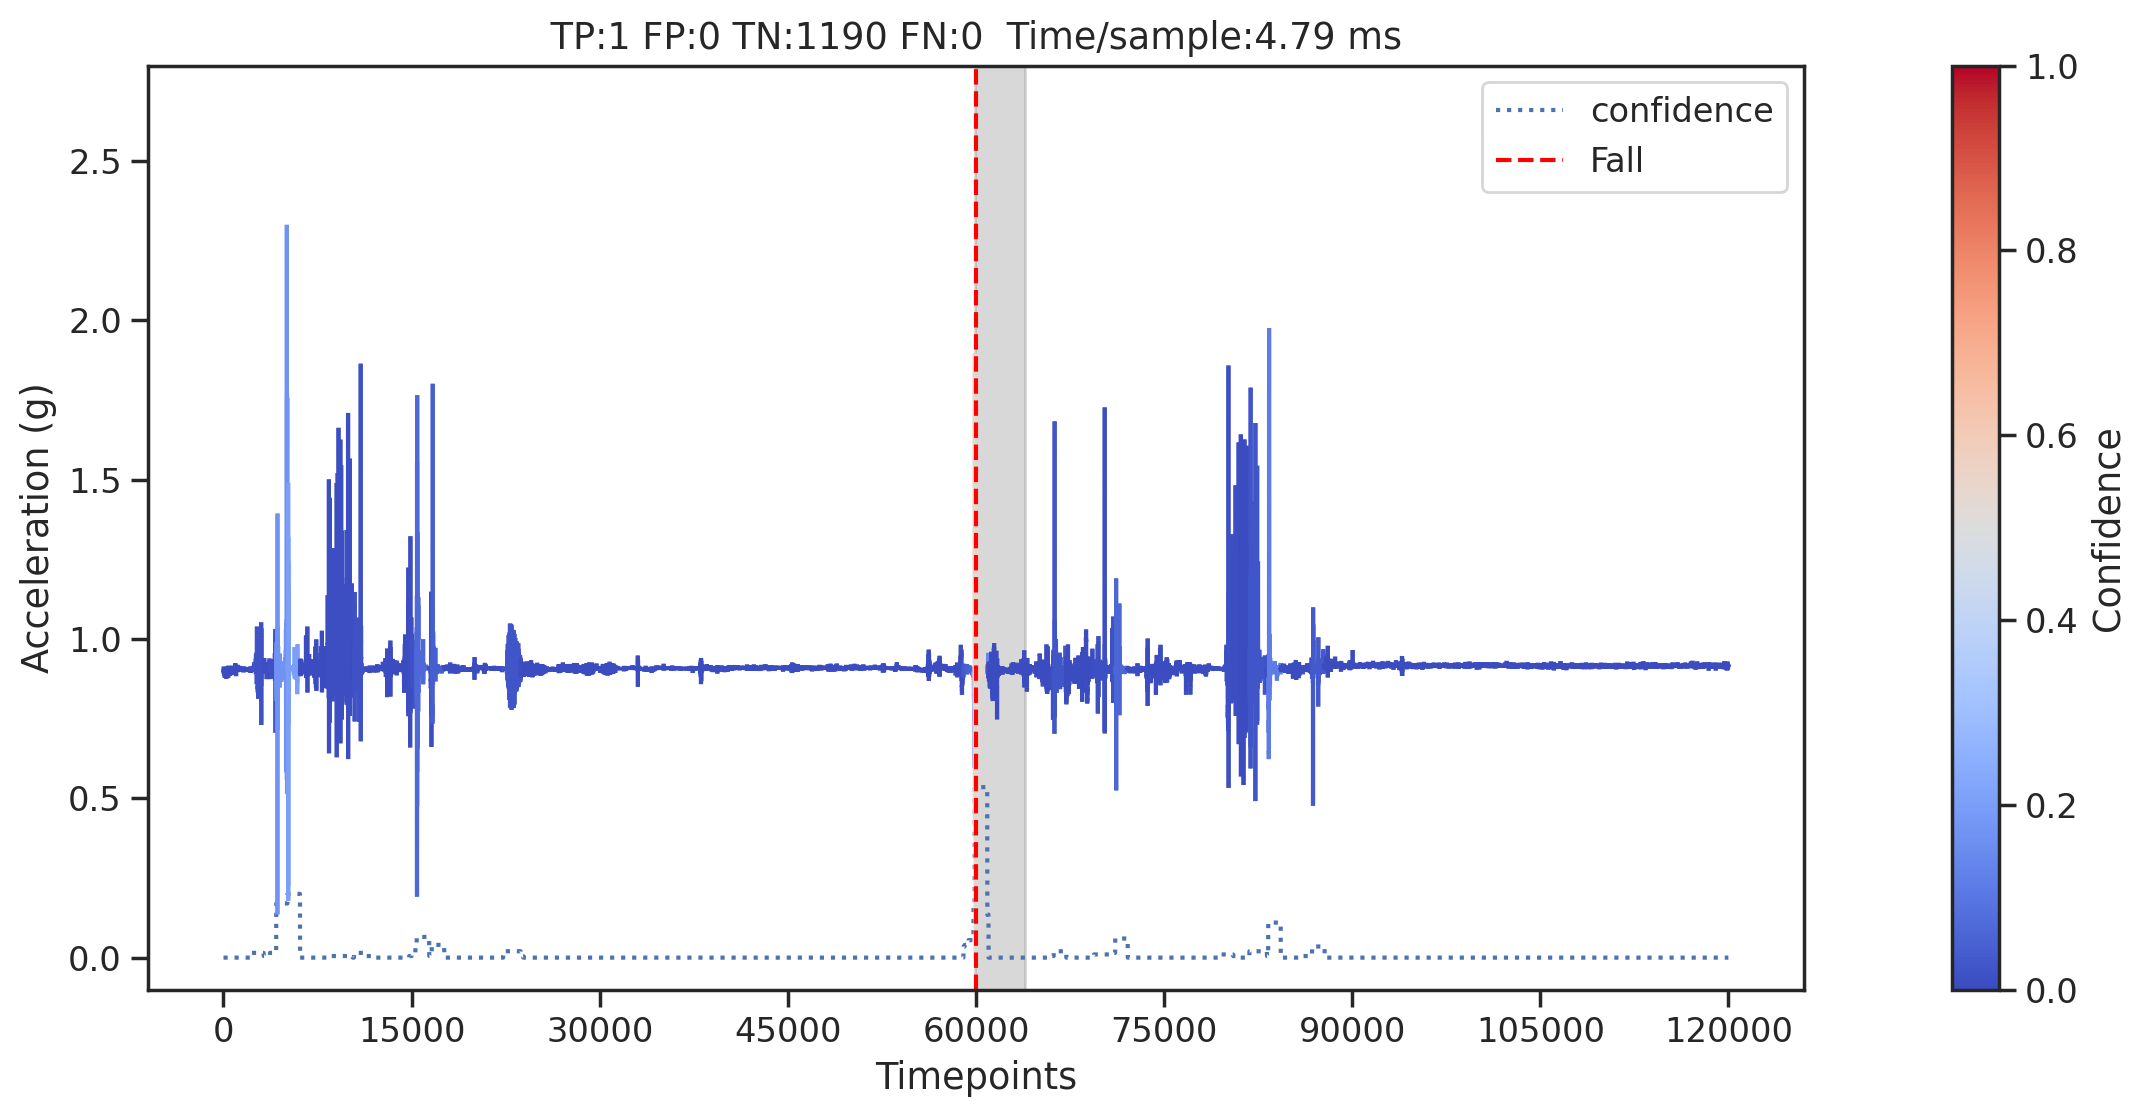

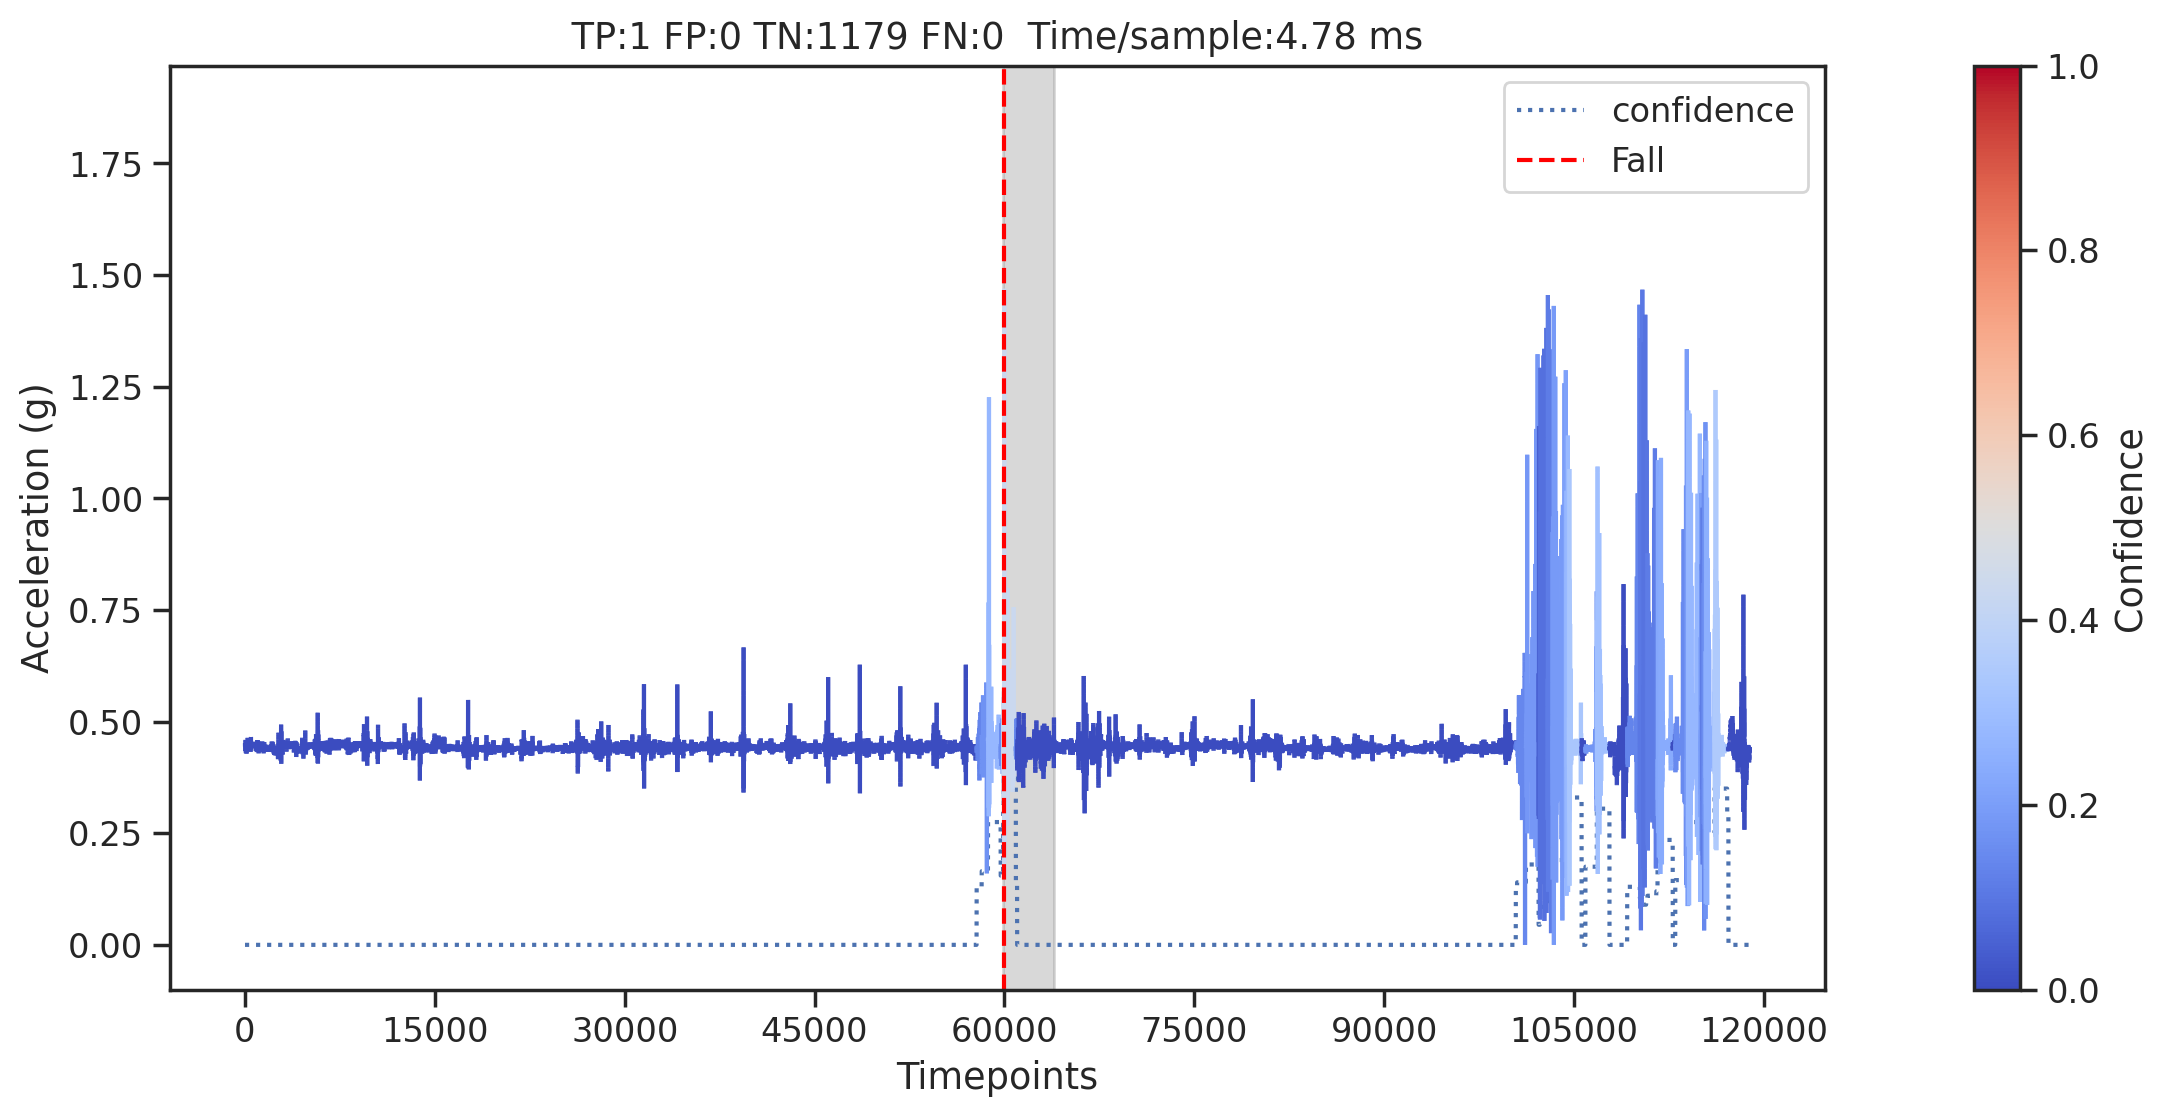

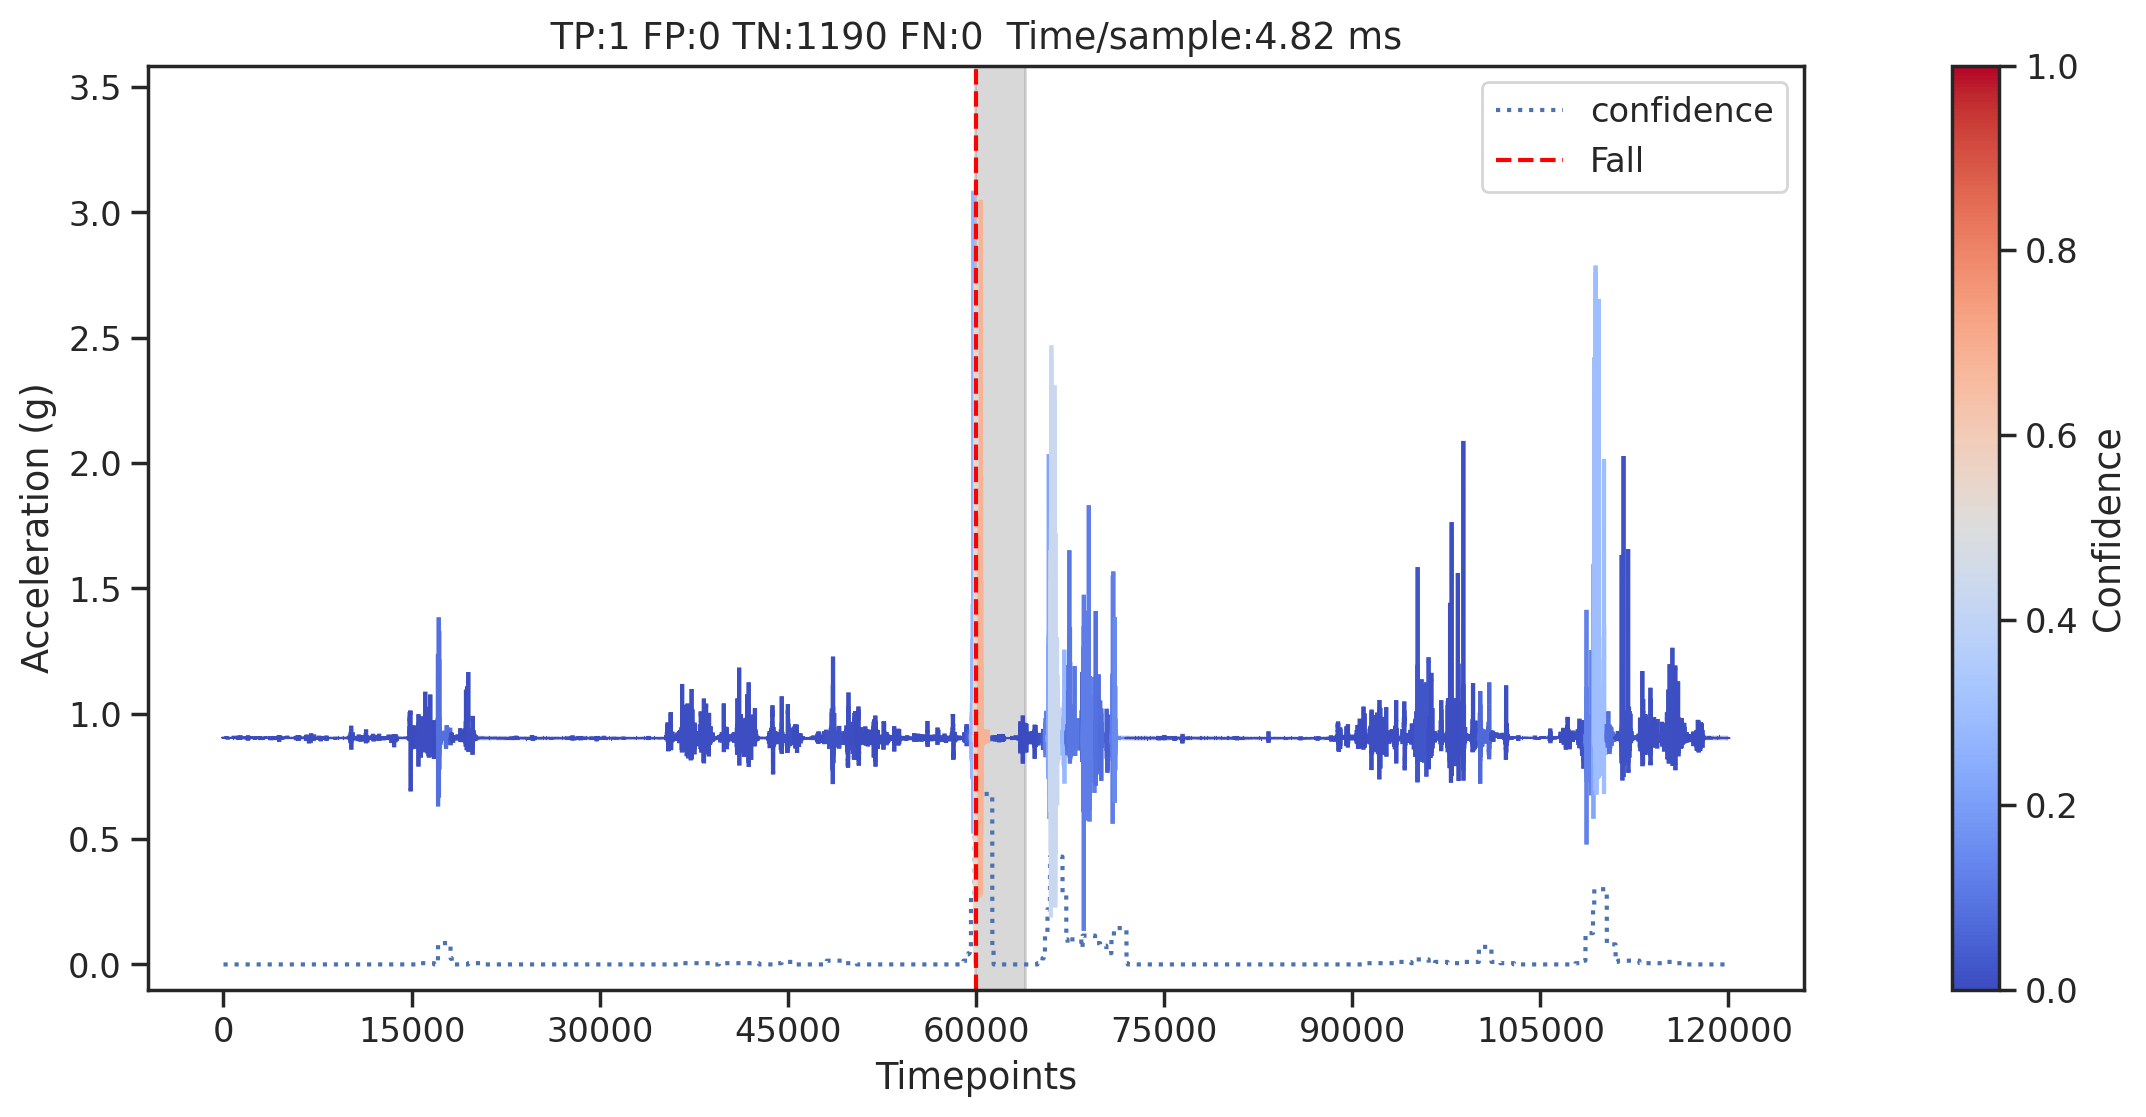

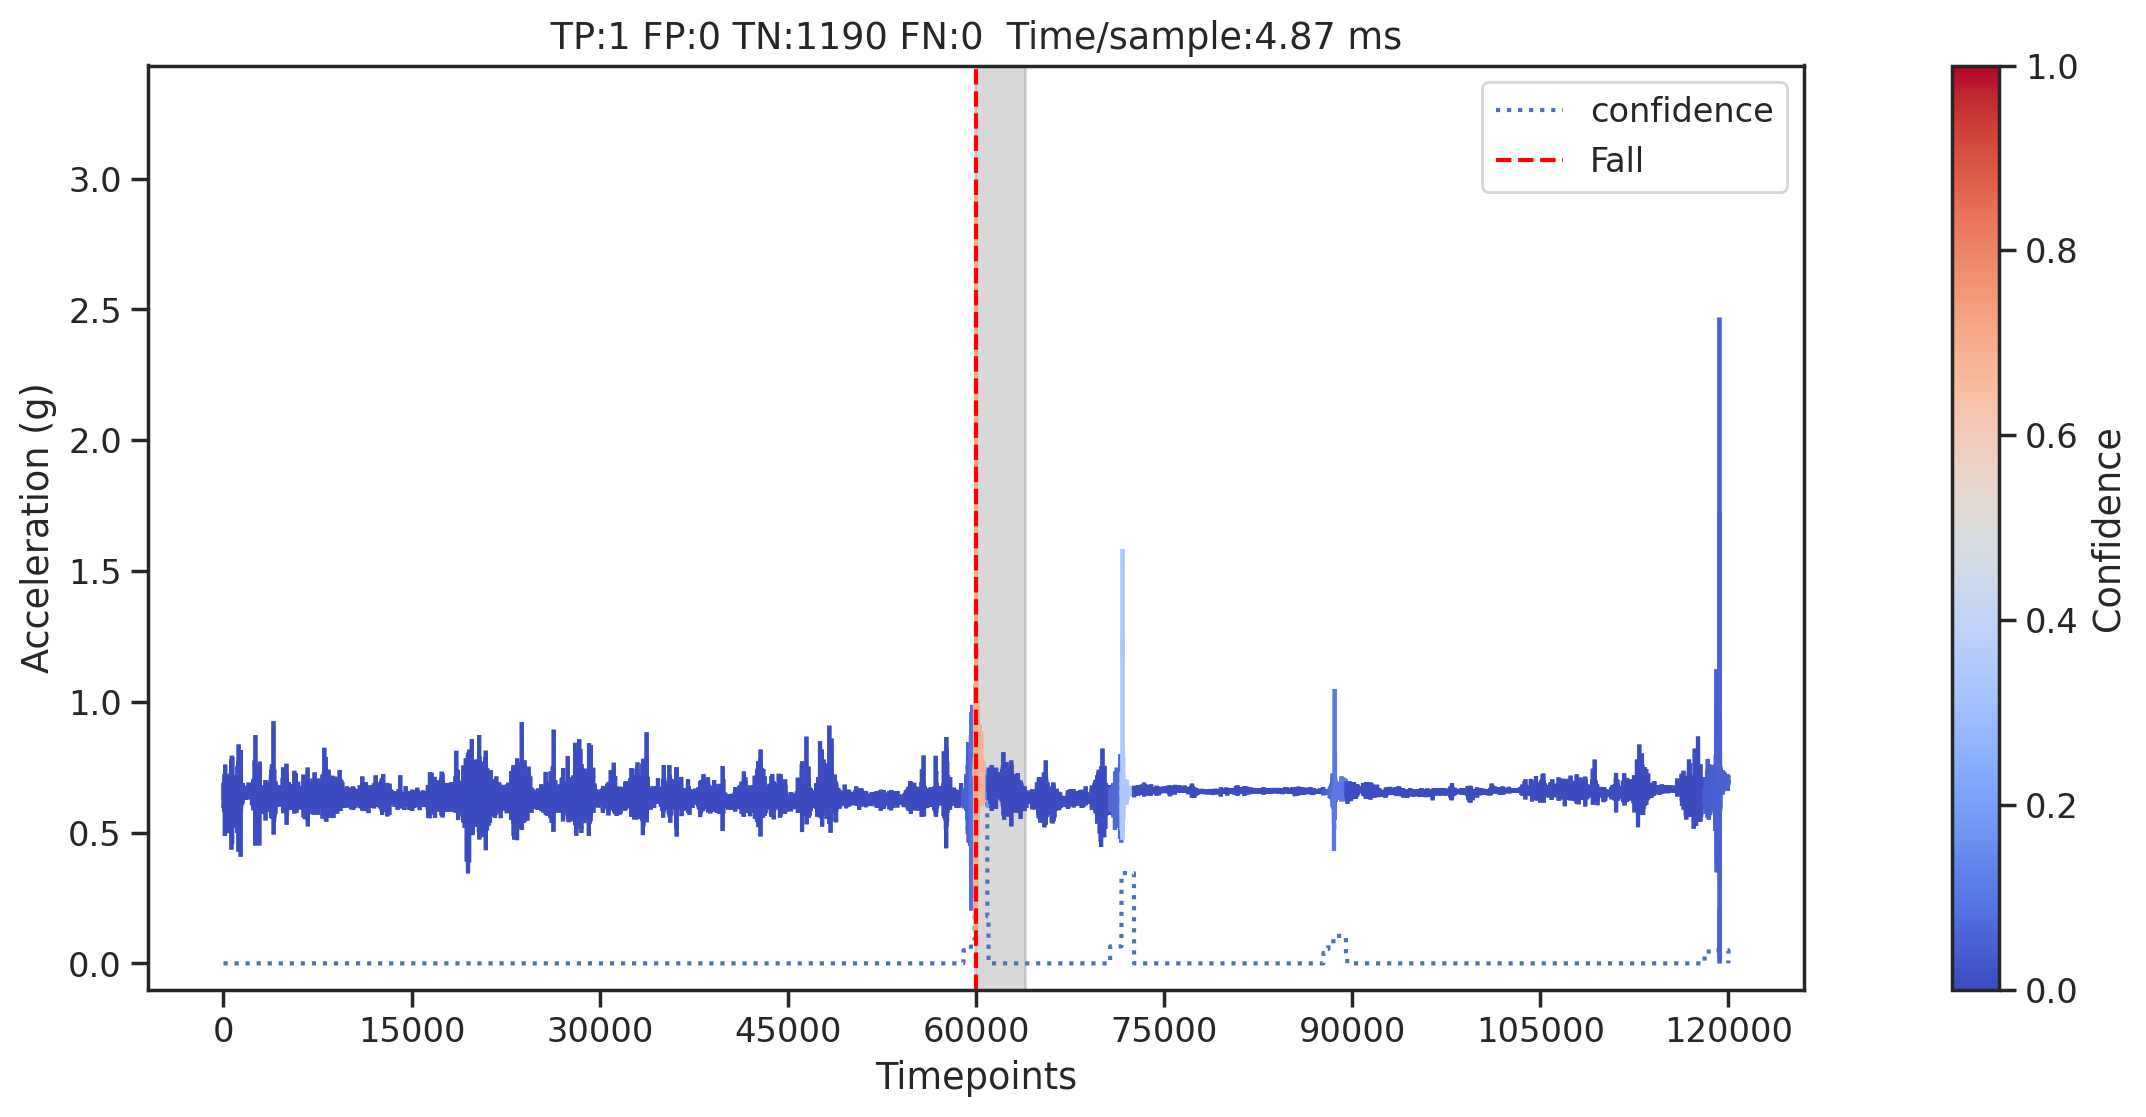

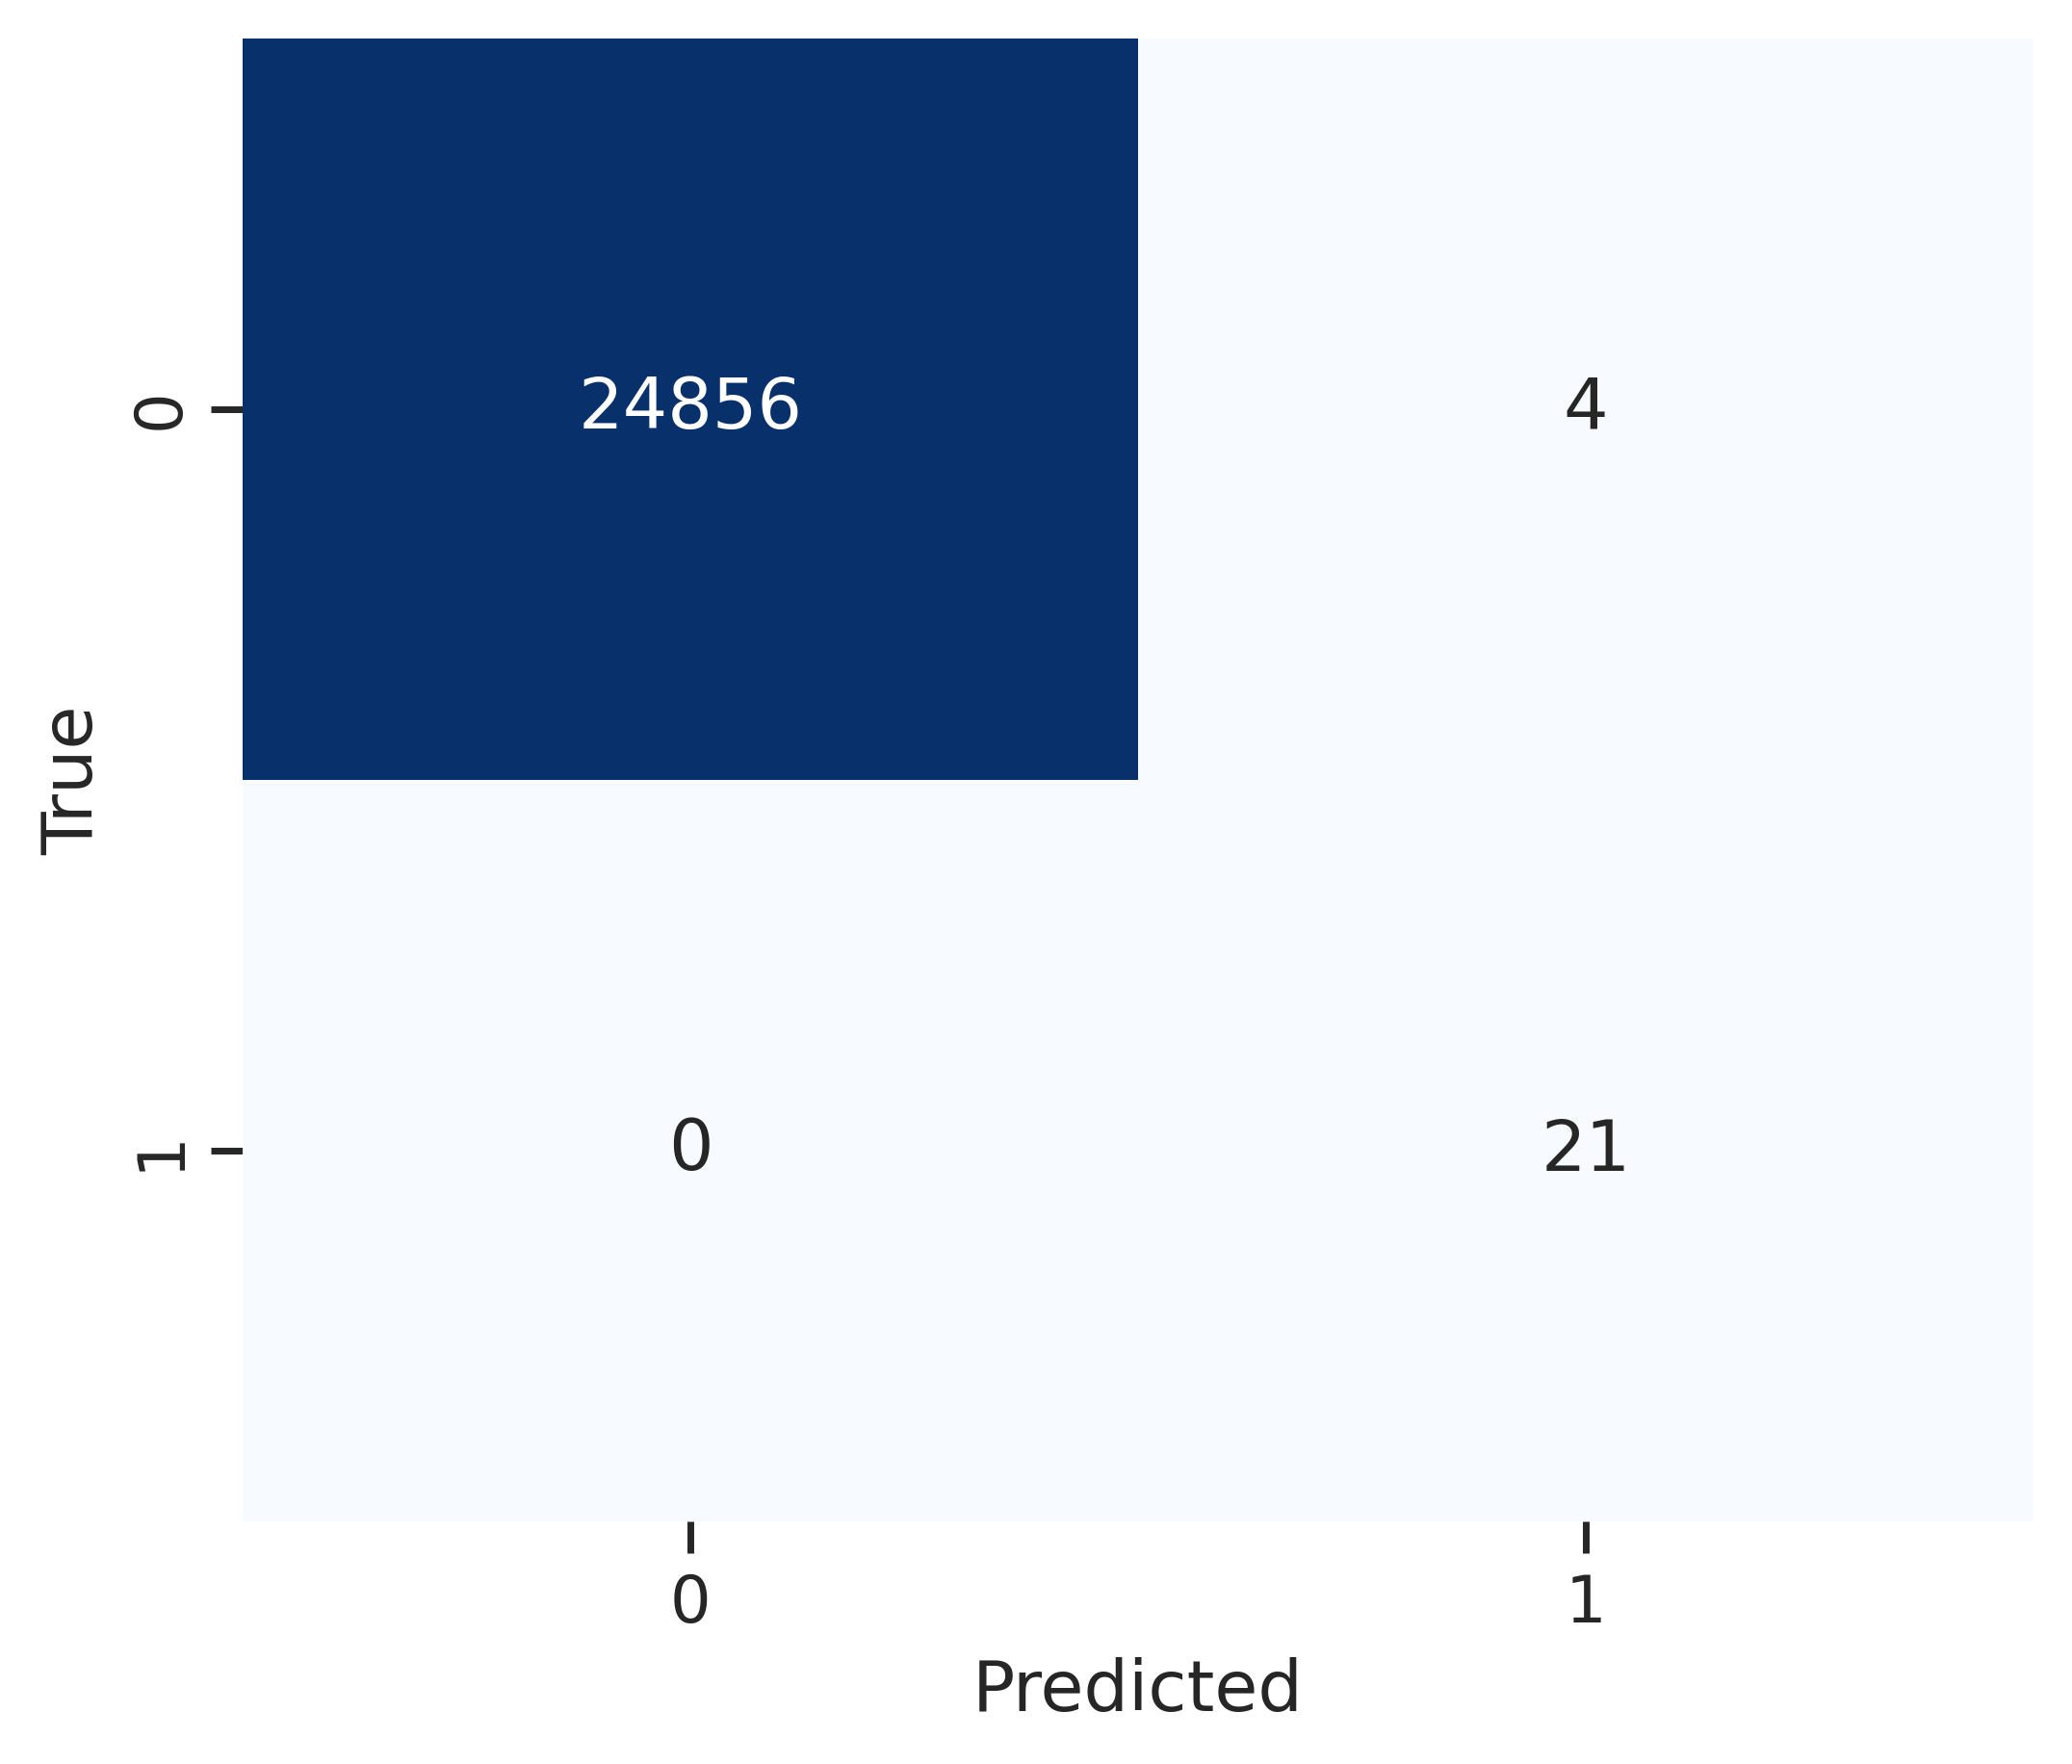

Evaluating models: 100%|██████████| 1/1 [01:51<00:00, 111.50s/it]
2025-08-19 16:07:56,806 [INFO] ✅ Evaluation complete


In [15]:
from scripts.model_runner import run_models

quant_thresh_metrics = []
quant = get_model_specs(subset=['QUANT'])
w = 10 # seconds
for t in [False, True]:
	if t:
		print(f"Running models for window size {w} seconds, tuning with fn_factor=2")
	else:
		print(f"Running models for window size {w} seconds, no tuning")
	X_tr, X_te, y_tr, y_te = datasets[w]
	res = run_models(
		X_tr, X_te, y_tr, y_te,
		model_specs=quant,
		verbose=True,
		ensemble_models=False,
		ensemble_by_kind=False,
		window_size=w,
		tune_threshold=t,
		fn_factor=2,
		saved_tuned_dir=CACHE,
		plot=True,
		save_confusion_matrix=True,
		save_detection_plot_dir=FIG_DIR
	)
	res["window_size"] = w
	res["fn_factor"] = 2
	quant_thresh_metrics.append(res)
	print("")
quant_thresh_df = pd.concat(quant_thresh_metrics, ignore_index=True)
quant_thresh_df.to_csv(RES_DIR / "quant_thresh_metrics_19August.csv", index=False)

In [6]:
quant_thresh_df = pd.read_csv(RES_DIR / "quant_thresh_metrics_19August.csv")
quant_thresh_df

model  seed  window_size   runtime     delay  precision    recall  \
0  QUANT     0           10  4.461270 -1.582857   0.863636  0.904762   
1  QUANT     0           10  4.607384 -3.630476   0.840000  1.000000   

   specificity  f1-score       auc  false alarm rate  miss rate      gain  \
0     0.999879  0.883721  0.952321          0.430776   0.287184 -0.000019   
1     0.999839  0.913043  0.999920          0.574367   0.000000 -0.000011   

    thresh  fn_factor  
0  0.50000          2  
1  0.40404          2

2025-08-27 12:39:07,359 [INFO] Training models (seed=0)


Running models for window size 10 seconds, tuning with fn_factor=2


Training (seed=0):   0%|          | 0/1 [00:00<?, ?it/s]2025-08-27 12:39:55,693 [INFO] Saved tuned model and CV results for QUANT to results/model_cache
2025-08-27 12:39:55,693 [INFO] QUANT: threshold tuned to 0.40
Evaluating models:   0%|          | 0/1 [00:00<?, ?it/s]

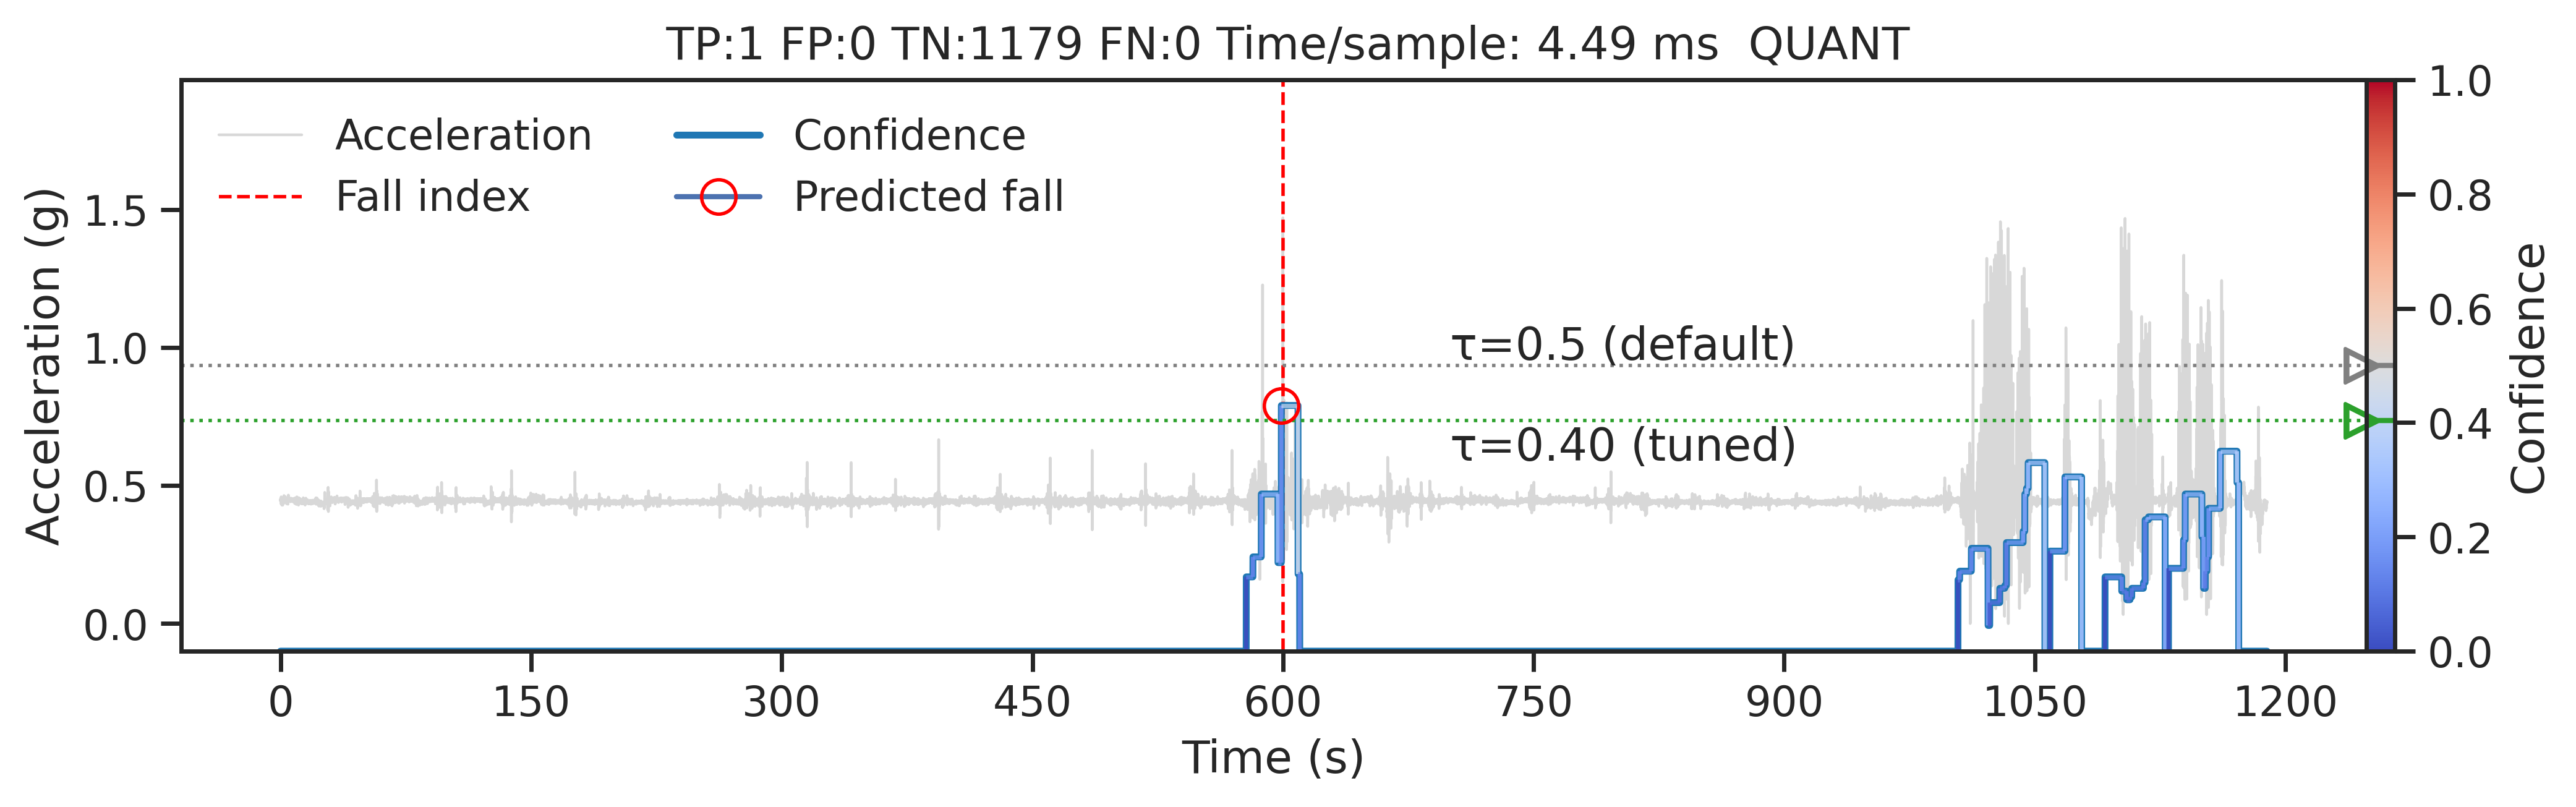

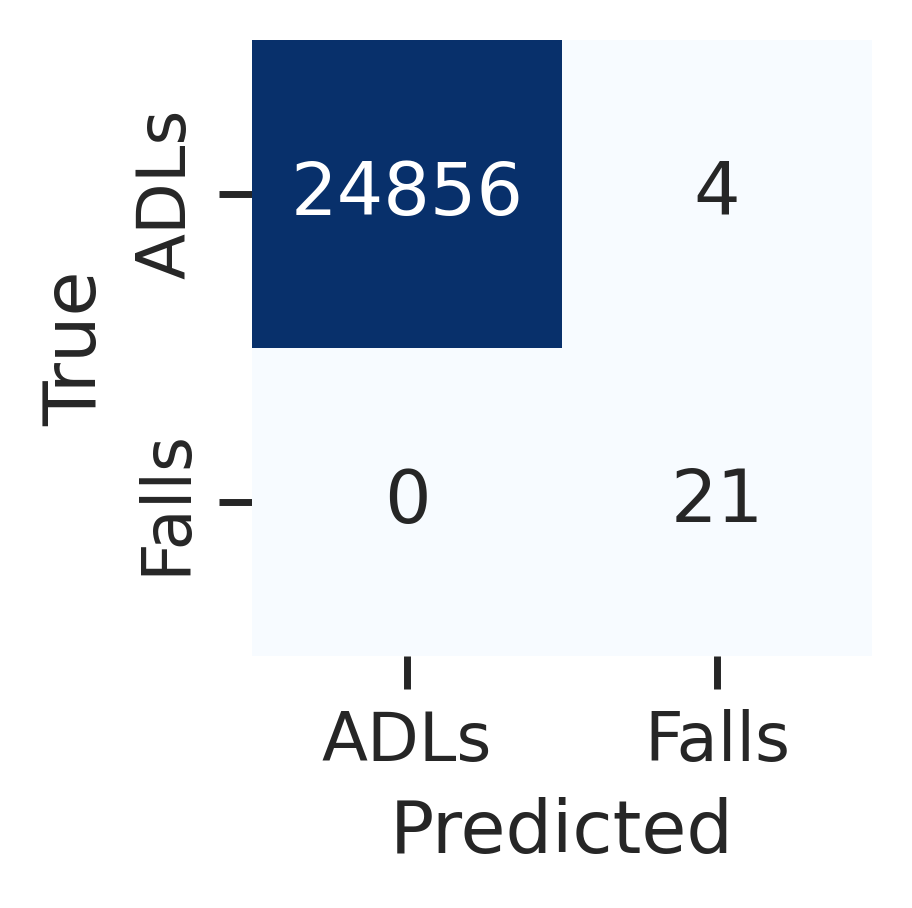

Evaluating models: 100%|██████████| 1/1 [00:16<00:00, 16.06s/it]
2025-08-27 12:40:11,757 [INFO] ✅ Evaluation complete


In [29]:
from scripts.model_runner import run_models

quant_thresh_metrics = []
quant = get_model_specs(subset=['QUANT'])
w = 10 # seconds
for t in [True]:
	if t:
		print(f"Running models for window size {w} seconds, tuning with fn_factor=2")
	else:
		print(f"Running models for window size {w} seconds, no tuning")
	X_tr, X_te, y_tr, y_te = datasets[w]
	res = run_models(
		X_tr, X_te, y_tr, y_te,
		model_specs=quant,
		verbose=True,
		ensemble_models=False,
		ensemble_by_kind=False,
		window_size=w,
		tune_threshold=t,
		fn_factor=2,
		saved_tuned_dir=CACHE,
		plot=True,
		save_confusion_matrix=True,
		save_detection_plot_dir=FIG_DIR
	)
	res["window_size"] = w
	res["fn_factor"] = 2
	quant_thresh_metrics.append(res)
	print("")
quant_thresh_df = pd.concat(quant_thresh_metrics, ignore_index=True)
quant_thresh_df.to_csv(RES_DIR / "quant_thresh_metrics_26August.csv", index=False)

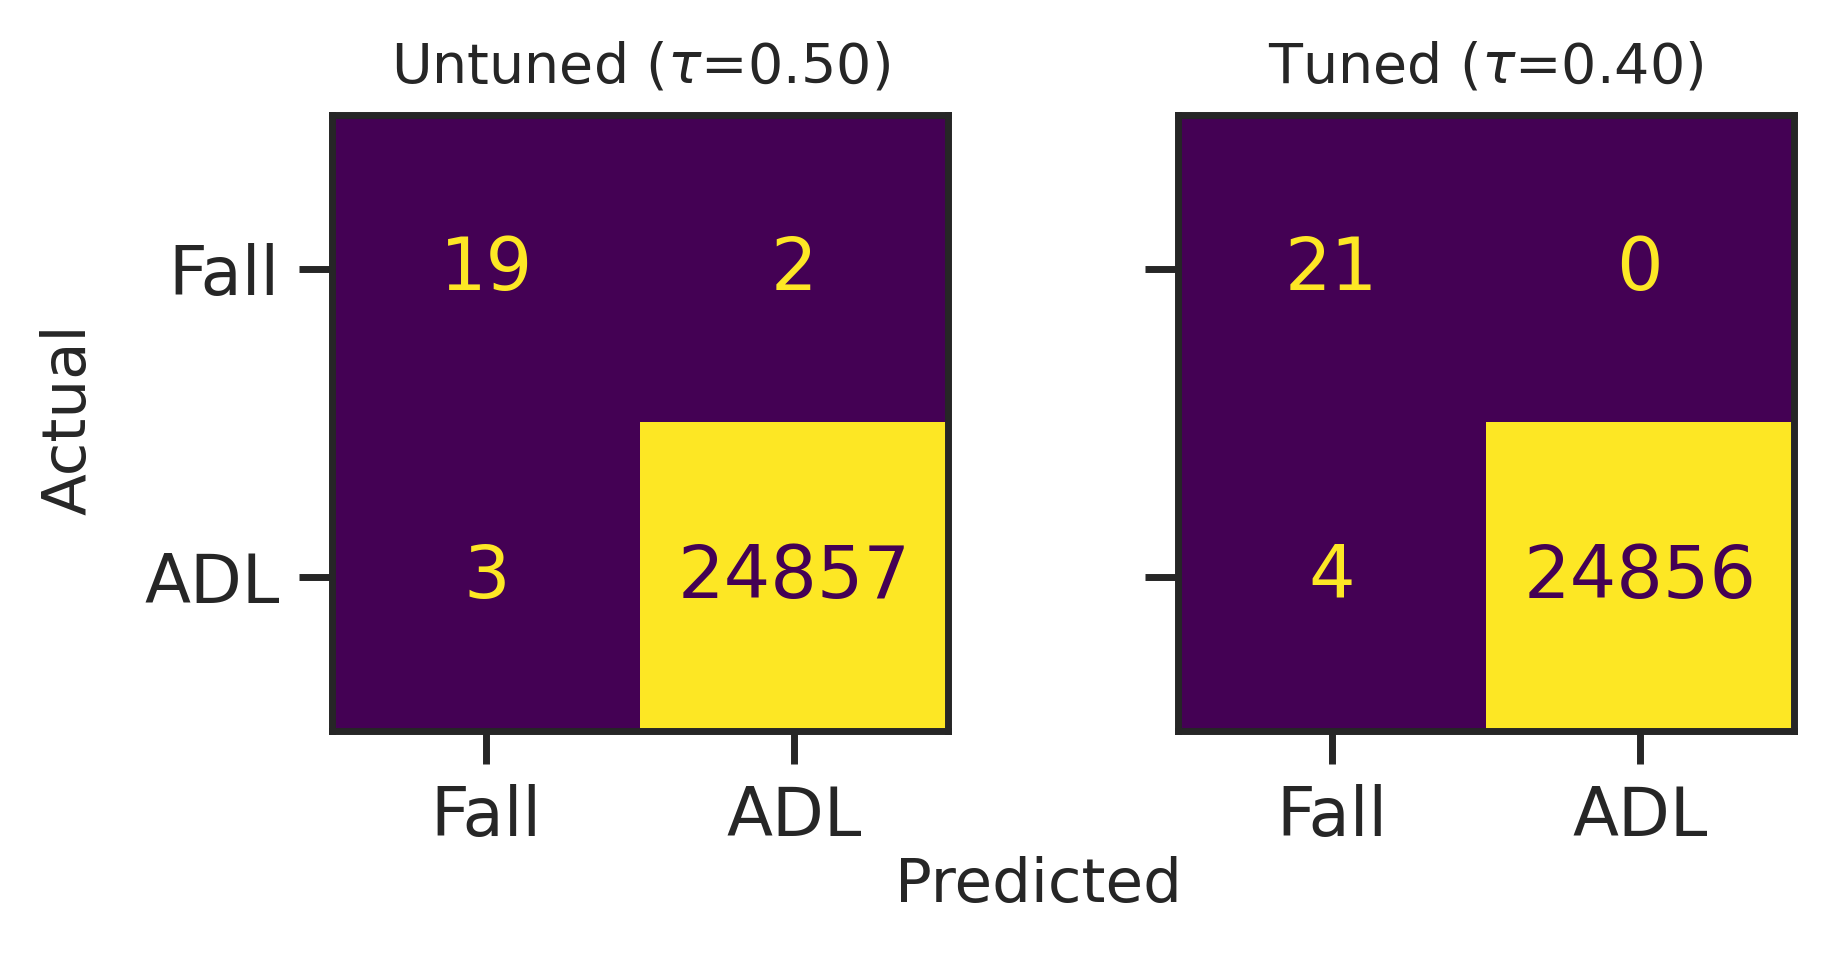

In [42]:
from matplotlib.pylab import f
from sklearn.metrics import ConfusionMatrixDisplay

# conventional order of CM is [TP, FN,
# 							   FP, TN]
untuned_cm = np.array([[19, 2], [3, 24857]])
tuned_cm = np.array([[21, 0], [4, 24856]])
labels = ["Fall", "ADL"]
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=400,
                        sharey=True)
ConfusionMatrixDisplay(
    untuned_cm, display_labels=labels).plot(ax=axs[0], colorbar=False)
ConfusionMatrixDisplay(
    tuned_cm, display_labels=labels).plot(ax=axs[1], colorbar=False)
axs[0].set_title(r"Untuned ($\tau$=0.50)", fontsize=10)
axs[1].set_title(r"Tuned ($\tau$=0.40)", fontsize=10)
for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.supxlabel("Predicted", y=-0.12, fontsize=11)
fig.supylabel("Actual", x=0.001, fontsize=11) # shift down
plt.savefig(FIG_DIR / "confusion_matrix.pdf", bbox_inches='tight')
plt.show()